IMPORT PACKAGES

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from statsmodels.stats.multitest import fdrcorrection
import matplotlib_venn
from venny4py.venny4py import *
from scipy import stats
import math
from matplotlib.lines import Line2D
from matplotlib.text import Text
from sklearn.preprocessing import RobustScaler,MinMaxScaler,StandardScaler
import lightgbm as lgb
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBClassifier
import pickle
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
import matplotlib
import random
import unicodeit
from matplotlib.colors import LinearSegmentedColormap
import umap
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from scipy.stats import shapiro

DEFINE FUNCTION

In [2]:
def histogram_entropy(data, bins=500):
    # Create histogram
    hist, bin_edges = np.histogram(data, bins=bins, density=True)

    # Normalize histogram to represent a probability density function
    hist = hist / hist.sum()
    
    # Remove zero entries to avoid log(0)
    hist = hist[hist > 0]
    
    # Calculate entropy
    entropy = -np.sum(hist * np.log(hist))
    
    return entropy

In [3]:
#Hàm wilcoxon mới
def STATS_binary(df_1,df_2,col_start,name_1,name_2,groups_PADJ=[]):
    # import pandas as pd
    # import numpy as np
    # from statsmodels.stats.multitest import fdrcorrection
    # from scipy import stats
    # import math
    Mean_1,Mean_2,Median_1,Median_2,Feature,P_value,AUC,Log2FC, Log2FC_Median=[],[],[],[],[],[],[],[],[]
    SD_1,SD_2,CVpct_1,CVpct_2=[],[],[],[]
    Entropy_1,Entropy_2=[],[]
    for i in range(col_start,df_1.shape[1]):
        #Mean
        m1=np.mean(list(df_1.iloc[:,i]))
        m2=np.mean(list(df_2.iloc[:,i]))
        Mean_1+=[m1]
        Mean_2+=[m2]
        #Median
        me1=np.median(list(df_1.iloc[:,i]))
        me2=np.median(list(df_2.iloc[:,i]))
        Median_1+=[me1]
        Median_2+=[me2]
        #P-value
        P_value+=[stats.ranksums(df_1.iloc[:,i],df_2.iloc[:,i])[1]]
        #Log2FC
        if m1 !=0 and m2 !=0:
            Log2FC+=[math.log2(abs(m2/m1))]
        else:
            Log2FC+=[0]

        if me1 !=0 and me2 !=0:
            Log2FC_Median+=[math.log2(abs(me2/me1))]
        else:
            Log2FC_Median+=[0]
        #Features
        Feature+=[df_1.columns[i]]
        #AUC
        AUC+=[metrics.roc_auc_score([0]*len(df_1)+[1]*len(df_2), list(df_1.iloc[:,i])+list(df_2.iloc[:,i]))]
        #SD and CV%
        sd1=np.std(list(df_1.iloc[:,i]))
        sd2=np.std(list(df_2.iloc[:,i]))
        SD_1+=[sd1]
        SD_2+=[sd2]
        if m1 != 0:
            CVpct_1+=[sd1/m1*100]
        else: 
            CVpct_1+=[np.NaN]
        if m2 != 0:
            CVpct_2+=[sd2/m2*100]
        else: 
            CVpct_2+=[np.NaN]
        #Entropy
        Entropy_1+=[histogram_entropy(data=list(df_1.iloc[:,i]),bins=int(len(df_1)/2))]
        Entropy_2+=[histogram_entropy(data=list(df_2.iloc[:,i]),bins=int(len(df_2)/2))]
    else:
        result=pd.DataFrame({'FEATURES':Feature,
                             'Mean of '+name_1:Mean_1,
                             'Mean of '+name_2:Mean_2,
                             'Median of '+name_1:Median_1,
                             'Median of '+name_2:Median_2,
                             'SD of '+name_1:SD_1,
                             'SD of '+name_2:SD_2,
                             'CV% of '+name_1:CVpct_1,
                             'CV% of '+name_2:CVpct_2,
                             'Entropy of '+name_1:Entropy_1,
                             'Entropy of '+name_2:Entropy_2, 
                             'Log2FC of '+name_1+' vs '+name_2:Log2FC,
                             'Log2FC Median of '+name_1+' vs '+name_2:Log2FC_Median,
                             'P of '+name_1+' vs '+name_2:P_value})
        #Adjust p-value
        PADJ=[]
        for g in groups_PADJ:
            filtered_result=result[result['FEATURES'].str.startswith(g)]
            if len(filtered_result)>0:
                PADJ+=list(fdrcorrection(filtered_result['P of '+name_1+' vs '+name_2])[1])
            else:
                PADJ+=[] 
        result['PADJ of '+name_1+' vs '+name_2]=PADJ
        result['Round_Mean of '+name_1]=result.apply(lambda row: round(row['Mean of '+name_1],2),axis=1)
        result['Round_Mean of '+name_2]=result.apply(lambda row: round(row['Mean of '+name_2],2),axis=1)
        result['-log10(p-value) of '+name_1+' vs '+name_2]=result.apply(lambda row: -math.log10(row['PADJ of '+name_1+' vs '+name_2]),axis=1)
        result['Distance of '+name_1+' vs '+name_2]=result.apply(lambda row: row['Mean of '+name_2]-row['Mean of '+name_1],axis=1)
        result['AUC of '+name_1+' vs '+name_2]=AUC
        result['AUCADJ of '+name_1+' vs '+name_2]=result.apply(lambda row: row['AUC of '+name_1+' vs '+name_2] if row['Log2FC of '+name_1+' vs '+name_2]>=0 else 1-row['AUC of '+name_1+' vs '+name_2],axis=1)
    return result
def STATS_features(df,pair,groups_PADJ=[],col_start=5):
    # import pandas as pd
    Cancer=df[df['Type']!='Healthy']
    Major=df[(df["Type"]=='Breast')|(df["Type"]=='Gastric')|(df["Type"]=='Colorectal')|(df["Type"]=='Liver')|(df["Type"]=='Lung')]
    Rare=df[(df["Type"]!='Breast')&(df["Type"]!='Gastric')&(df["Type"]!='Colorectal')&(df["Type"]!='Liver')&(df["Type"]!='Lung')]#|(df["Type"]=='Biliary tract')|(df["Type"]=='Kidney')|(df["Type"]=='Laryngeal'))]
    Healthy=df[df['Type']=='Healthy']
    Breast=df[df["Type"]=='Breast']
    Cervical=df[df["Type"]=='Cervical']
    Colorectal=df[df["Type"]=='Colorectal']
    Endometrial=df[df["Type"]=='Endometrial']
    Esophageal=df[df["Type"]=='Esophageal']
    Gastric=df[df["Type"]=='Gastric']
    Head_and_neck=df[df["Type"]=='Head and neck']
    Liver=df[df["Type"]=='Liver']
    Lung=df[df["Type"]=='Lung']
    Ovarian=df[df["Type"]=='Ovarian']
    Pancreatic=df[df["Type"]=='Pancreatic']
    Biliary_tract=df[df["Type"]=='Biliary tract']
    Laryngeal=df[df["Type"]=='Laryngeal']

    Group={
            'Cancer':Cancer,
            'Major':Major,
            'Rare':Rare,
            'Healthy':Healthy,
            'Breast':Breast,
            'Cervical':Cervical,
            'Colorectal':Colorectal,
            'Endometrial':Endometrial,
            'Esophageal':Esophageal,
            'Gastric':Gastric,
            'Head and neck':Head_and_neck,
            'Liver':Liver,
            'Lung':Lung,
            'Ovarian':Ovarian,
            'Pancreatic':Pancreatic,
            'Biliary tract':Biliary_tract,
            'Laryngeal':Laryngeal
            }
    result=pd.DataFrame()
    for p in pair:
        name_1=p.split(' vs ')[0]
        name_2=p.split(' vs ')[1]
        stats_bi=STATS_binary(df_1=Group[name_1],df_2=Group[name_2],col_start=col_start,name_1=name_1,name_2=name_2,groups_PADJ=groups_PADJ)
        result=pd.concat([result,stats_bi],axis=1)
    else:
        result = result.loc[:,~result.columns.duplicated()].copy()
    return result

def introundup(a):
    import math
    b=math.ceil(a)
    c=len(str(b))
    d=pow(10,c-1)
    e=a/d
    f=math.ceil(e)
    g=f*d
    return g
def features_include(features,lst_fea,fsm,f_group):
    df=pd.DataFrame({'FEATURES':list(lst_fea)})
    Number=[]
    for f in features:
        Number+=[len(df[df['FEATURES'].str.startswith(f)])]
    fea_include=pd.DataFrame({'FEATURES':features,fsm+' | '+f_group:Number})
    return fea_include

Volcanofea

In [4]:
def volcanofea(f,pair=['Lung vs Heathy'],alpha=0.05,show_region=False):
    data=stats_fea[f]
    data.index=data.FEATURES
    custom_lines = [Line2D([0], [0],marker='o',color='w', markerfacecolor='gray', markersize=5),
                        # Line2D([0], [0],marker='o', color='w', markerfacecolor='green', markersize=5),
                        # Line2D([0], [0],marker='o', color='w', markerfacecolor='orange', markersize=5),
                        Line2D([0], [0],marker='o', color='w', markerfacecolor='blue', markersize=5),
                        Line2D([0], [0],marker='o', color='w', markerfacecolor='r', markersize=5)]
    for p in pair:
        col_log='Log2FC of '+p
        col_PADJ='-log10(p-value) of '+p
        cols=[]
        for r in data['FEATURES']:
            if data.loc[r,'PADJ of '+p] >=alpha:
                cols+=['gray']
            elif data.loc[r,'PADJ of '+p] < alpha:
                if data.loc[r,col_log] >= 0:
                    cols+=['r']
                else:
                    cols+=['b']
        plt.figure(figsize=(6,6))
        x=data[col_log]
        y=data[col_PADJ]
        sb.scatterplot(x=x,y=y,c=cols,linewidth=0.5,edgecolor='black')
        plt.axvline(x=0, color='gray', label='axvline - full height',ls='--')
        left, right = plt.xlim()
        plt.axhline(y=-math.log10(alpha), color='green', label='axhline - full height',ls='--')
        plt.xlabel(u'log\u2082(fold change of means '+p.split(' vs ')[1]+'/'+ p.split(' vs ')[0]+')')
        plt.ylabel(unicodeit.replace('-log_1_0(adjusted p-value)'))
        plt.title('Volcano plot - '+f+' - '+p)
        # plt.yticks(np.arange(0,8,1))
        # plt.xticks(np.arange(-0.1,0.4,0.1))
        se_cols=pd.Series(cols)
        count=se_cols.value_counts()
        lst=[]
        for j, i in zip(['gray','b','r'],['No change','Down','Up']):    
            lst+=[i+' ('+str(count.get(j, 0))+')']
        plt.legend(custom_lines,lst,title='Change',loc='center left', bbox_to_anchor=(1, 0.2))
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        
        lst_name_show=list(data[((data[col_log]<=-0.1)|(data[col_log]>=0.015))]['FEATURES'])
        if show_region:
            region_name = list(data['FEATURES'])
            for i, txt in enumerate(region_name):
                if txt in lst_name_show:
                    plt.text(x[i],y[i],txt,fontsize=8,color='red')

AUCplotfea

In [5]:
def AUCplotfea(f,pair=['Lung vs Healthy'],alpha=0.05): 
    custom_lines = [Line2D([0], [0],marker='o',color='w', markerfacecolor='gray', markersize=5),
                            # Line2D([0], [0],marker='o', color='w', markerfacecolor='green', markersize=5),
                            # Line2D([0], [0],marker='o', color='w', markerfacecolor='orange', markersize=5),
                            Line2D([0], [0],marker='o', color='w', markerfacecolor='blue', markersize=5),
                            Line2D([0], [0],marker='o', color='w', markerfacecolor='r', markersize=5)]
    for p in pair:
        df=stats_fea[f][['FEATURES','PADJ of '+p,'Log2FC of '+p,'AUCADJ of '+p]]
        if f=='TM_RATIO_SHORT_LONG' or f=='TM_RATIO_SHORT_TOTAL' or f=='TMD':
            df.index=[int(i.split('_')[-1]) for i in df['FEATURES']]
            df.sort_index(inplace=True)
            x=[i.split('_')[-1] for i in list(df['FEATURES'])]
        else:
            df.index=[int(i.split('_')[2]) for i in df['FEATURES']]
            df.sort_index(inplace=True)
            x=[i.split('_')[2] for i in list(df['FEATURES'])]
        # data_concatenate=stats_fea['All_features']
        col_PADJ='PADJ of '+p
        col_L2FC='Log2FC of '+p
        cols=[]
        for i in list(df.iloc[:,0]):
            PADJ_split=df[df[df.columns[0]]==i][col_PADJ].reset_index(drop=True)[0]
            # PADJ_concatenate=data_concatenate[data_concatenate[data_concatenate.columns[0]]==i][col_PADJ].reset_index(drop=True)[0]
            L2FC_split=df[df[df.columns[0]]==i][col_L2FC].reset_index(drop=True)[0]
            if PADJ_split < alpha and L2FC_split <0:
                cols.append('b')
            elif PADJ_split < alpha and L2FC_split >=0:
                cols.append('r')
            elif PADJ_split >= alpha:
                cols.append('gray')

        plt.figure(figsize=(10,5))
        sb.scatterplot(data=df,x=x,y=list(df['AUCADJ of '+p]),c=cols)
        plt.yticks(np.arange(0.3,1.05,0.05))
        plt.xticks([])
        plt.xlabel('Regions')
        plt.ylabel('AUC')
        plt.title('AUC of '+f+' features - '+p)
        se_cols=pd.Series(cols)
        count=se_cols.value_counts()
        lst=[]
        for j, i in zip(['gray','b','r'],['No change','Down','Up']):    
            lst+=[i+' ('+str(count.get(j, 0))+')']
        plt.legend(custom_lines,lst,title='Change',loc='center left', bbox_to_anchor=(1, 0.5))
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)

Variability

In [6]:
def Varplotfea(f,pair=['Lung vs Healthy'],sig=False,alpha=0.05,VAR='AUC',ytick=[0,110,10],fea_compare='TMD',show_region=False,region_to_show=[]): 
    custom_lines = [Line2D([0], [0],marker='o',color='w', markerfacecolor='gray', markersize=5),
                            # Line2D([0], [0],marker='o', color='w', markerfacecolor='green', markersize=5),
                            # Line2D([0], [0],marker='o', color='w', markerfacecolor='orange', markersize=5),
                            Line2D([0], [0],marker='o', color='w', markerfacecolor='blue', markersize=5),
                            Line2D([0], [0],marker='o', color='w', markerfacecolor='r', markersize=5)]
    for p in pair:
        df=stats_fea[f][['FEATURES',
                        'PADJ of '+p,
                        'Log2FC of '+p,
                        'AUCADJ of '+p,
                        # 'CV% of Healthy',
                        # 'Entropy of Healthy',
                        'CV% of '+p.split(' vs ')[0],
                        'CV% of '+p.split(' vs ')[1],
                        'Entropy of '+p.split(' vs ')[0],
                        'Entropy of '+p.split(' vs ')[1],                        
                        ]]
        df.fillna(0,inplace=True)
        mean_=[np.mean(list(df[VAR+' of '+p.split(' vs ')[0]])),np.mean(list(df[VAR+' of '+p.split(' vs ')[1]]))]
        if sig:
            df=df[df['PADJ of '+p]<alpha]          

        if f=='TM_RATIO_SHORT_LONG' or f=='TM_RATIO_SHORT_TOTAL':
            df.index=[int(i.split('_')[-1]) for i in df['FEATURES']]
            df.sort_index(inplace=True)
            x=[i.split('_')[-1] for i in list(df['FEATURES'])]
        elif f in ['TM_CNA','TM_flen','TM_EM']:
            df.index=[int(i.split('_')[2]) for i in df['FEATURES']]
            df.sort_index(inplace=True)
            x=[i.split('_')[2] for i in list(df['FEATURES'])]
        elif f =='GWMD' or f=='CNA':
            x=[i for i in list(df['FEATURES'])]
        else:
            df.index=[int(i.split('_')[1]) for i in df['FEATURES']]
            df.sort_index(inplace=True)
            x=[i.split('_')[1] for i in list(df['FEATURES'])]

        # data_concatenate=stats_fea['All_features']
        col_PADJ='PADJ of '+p
        col_L2FC='Log2FC of '+p
        cols=[]
        for i in list(df.iloc[:,0]):
            PADJ_split=df[df[df.columns[0]]==i][col_PADJ].reset_index(drop=True)[0]
            # PADJ_concatenate=data_concatenate[data_concatenate[data_concatenate.columns[0]]==i][col_PADJ].reset_index(drop=True)[0]
            L2FC_split=df[df[df.columns[0]]==i][col_L2FC].reset_index(drop=True)[0]
            if PADJ_split < alpha and L2FC_split <0:
                cols.append('b')
            elif PADJ_split < alpha and L2FC_split >=0:
                cols.append('r')
            elif PADJ_split >= alpha:
                cols.append('gray')

        
        if VAR == 'AUC':
            plt.figure(figsize=(10,5))
            sb.scatterplot(data=df,x=x,y=list(df[VAR+'ADJ of '+p]),c=cols)
            plt.yticks(np.arange(0.3,1.05,0.05))
            plt.xticks([])
            plt.xlabel('Regions (features)')
            plt.ylabel(VAR)
            plt.title(VAR+' of '+f+' features - '+p)
        else:
            for i in [0,1]:
                plt.figure(figsize=(10,5))
                y=list(df[VAR+' of '+p.split(' vs ')[i]])
                sb.scatterplot(data=df,x=x,y=y,c=cols,markers='.')
                # plt.axhline(y=np.mean(list(df[VAR+' of Healthy'])), color='magenta', label='axvline - full height',ls='--')
                # plt.axhline(y=np.mean(list(stats_fea[fea_compare][VAR+' of '+p.split(' vs ')[i]])), color='red', label='axvline - full height',ls='--')
                plt.axhline(y=mean_[i], color='black', label='axvline - full height',ls='--')
                # plt.text(x=len(x)*1.06, y=np.mean(list(df[VAR+' of Healthy']))+ytick[2]/10, s='Average in Healthy', fontsize=12,color='magenta')
                # plt.text(x=len(x)*1.06, y=np.mean(list(stats_fea[fea_compare][VAR+' of '+p.split(' vs ')[i]])), s='Average in '+fea_compare+' of '+p.split(' vs ')[i], fontsize=12,color='red')
                plt.text(x=len(x)*1.06, y=mean_[i]-ytick[2]/3, s='Average in '+p.split(' vs ')[i], fontsize=12)
                plt.yticks(np.arange(ytick[0],ytick[1],ytick[2]))
                plt.xticks([])
                plt.xlabel('Regions (features)')
                plt.ylabel(VAR)
                plt.title(VAR+' of '+f+' features - '+p.split(' vs ')[i])

                se_cols=pd.Series(cols)
                count=se_cols.value_counts()
                lst=[]
                for j, i in zip(['gray','b','r'],['No change','Down','Up']):    
                    lst+=[i+' ('+str(count.get(j, 0))+')']
                plt.legend(custom_lines,lst,title='Change',loc='upper left', bbox_to_anchor=(1, 1))
                plt.gca().spines['top'].set_visible(False)
                plt.gca().spines['right'].set_visible(False)
                
                if show_region:
                    region_name = list(df['FEATURES'])
                    for i, txt in enumerate(region_name):
                        if txt in region_to_show:
                            plt.text(x[i],y[i],txt,fontsize=8,color='red')

        se_cols=pd.Series(cols)
        count=se_cols.value_counts()
        lst=[]
        for j, i in zip(['gray','b','r'],['No change','Down','Up']):    
            lst+=[i+' ('+str(count.get(j, 0))+')']
        plt.legend(custom_lines,lst,title='Change',loc='upper left', bbox_to_anchor=(1, 1))
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)

PCAsigfea

In [7]:
def PCAsigfea(DATA,SAMPLES,stats_fea,dict_cols,p='A vs B',f='TMD',
              sig=True,alpha=0.05,show_ID=False,IDs=[],
              plot_pct_explain=False,top_pc=2,
              yticks=[0,5,1],xticks=[0,5,1],
              save=False,figname='PCA.png'
              ):
    
    name0=p.split(' vs ')[0]
    name1=p.split(' vs ')[1]
    sample_list0=SAMPLES[name0]
    sample_list1=SAMPLES[name1]
    #Lấy data
    vector0=[]
    vector1=[]
    for s in list(DATA[f]['SampleID']):
        if s in list(sample_list0['SampleID']):
            vector0+=[True]
        else:
            vector0+=[False]
        if s in list(sample_list1['SampleID']):
            vector1+=[True]
        else:
            vector1+=[False]    
    data0=DATA[f][vector0]
    Labe0=[]
    for s in data0['SampleID']:
        Labe0+=[list(sample_list0[sample_list0['SampleID']==s]['Type'])[0]]
    data0.insert(loc=1,column='Type',value=Labe0)

    data1=DATA[f][vector1]
    Labe1=[]
    for s in data1['SampleID']:
        Labe1+=[list(sample_list1[sample_list1['SampleID']==s]['Type'])[0]]
    data1.insert(loc=1,column='Type',value=Labe1)


    if sig:
        sig_features=list(stats_fea[f][stats_fea[f]['PADJ of '+p]<alpha]['FEATURES'])
        data0=data0[['SampleID']+sig_features]
        data1=data1[['SampleID']+sig_features]

    data=pd.concat([data0,data1],axis=0)
    
    col_start=2


    pca=PCA(random_state=0)
    pca.fit(data.iloc[:,col_start:])
    pca_data=pca.transform(data.iloc[:,col_start:])

    # pca_data=pca.transform(scaled_data)

    per_var=np.round(pca.explained_variance_ratio_*100,decimals=1)
    labels=['PC'+str(x) for x in range(1,len(per_var)+1)]

    if plot_pct_explain ==True:
        if top_pc > data.shape[1]-col_start:
            top_pc = data.shape[1]-col_start
        ax1=plt.figure(figsize=(5,5))
        plt.bar(x=range(1,len(per_var[0:top_pc])+1),height=per_var[0:top_pc],tick_label=labels[0:top_pc])
        plt.ylabel('Percentage of Explained Variance')   
        plt.xlabel('Principal Component')
        if sig:
            plt.title('Top '+str(top_pc)+' PC | '+p+' | '+str(len(sig_features))+' Significant '+f+'s',pad=20)
        else:        
            plt.title('Top '+str(top_pc)+' PC | '+p+' | '+f,pad=20)
        plt.yticks(np.arange(0,110,top_pc))
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        if save:
            plt.savefig(figname[0:len(figname)-4]+'_top10.png',dpi=600,bbox_inches='tight')
    

    cols=[]
    if sorted(list(dict_cols.keys())) == sorted(list(data['Type'].unique())):
        for i in data['Type']:
            cols+=[dict_cols[i]]
    else:
        cols=['b']*len(data)

    ax2=plt.figure(figsize=(5,5))
    sb.scatterplot(x=pca_data[:,0],y=pca_data[:,1],c=cols)
    # sb.scatterplot(x=pca_data[:,0][::-1],y=pca_data[:,1][::-1],c=cols)

    if show_ID == True:
        labels=list(data['SampleID'])
        for i, label in enumerate(labels):
            if label in IDs:
                plt.text(pca_data[:,0][i], pca_data[:,1][i], label, fontsize=12, ha='right')

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.yticks(np.arange(yticks[0],yticks[1],yticks[2]))
    plt.xticks(np.arange(xticks[0],xticks[1],xticks[2]))
    if p == 'Non_cancer vs Cancer':
        if sig:
            plt.title('PCA | Multiclass | '+str(len(sig_features))+' Significant '+f+'s',pad=20)
        else:
            plt.title('PCA | Multiclass | '+f,pad=20)
    else:
        if sig:
            plt.title('PCA | '+p+' | '+str(len(sig_features))+' Significant '+f+'s',pad=20)
        else:
            plt.title('PCA | '+p+' | '+f,pad=20)
    
    custom_lines =[]
    for c in dict_cols.keys():
        custom_lines +=[Line2D([0], [0],marker='o',color='w', markerfacecolor=dict_cols[c], markersize=7)]

    plt.legend(custom_lines,list(dict_cols.keys()),
            #    title='Type',
               loc='center left', bbox_to_anchor=(1, 0.5),frameon=False)

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    if save:
        plt.savefig(figname,dpi=600,bbox_inches='tight')


LDAsigfea

In [8]:
def LDAsigfea(DATA,SAMPLES,stats_fea,
            dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
            p='Nongastric vs Gastric',
            f='EM',
            sig=False,
            alpha=0.05,
            show_ID=False,
            IDs=[],
            yticks=[0,5,1],
            xticks=[0,5,1],
            save=False,
            figname='LDA.png'):
              
    
    name0=p.split(' vs ')[0]
    name1=p.split(' vs ')[1]
    sample_list0=SAMPLES[name0]
    sample_list1=SAMPLES[name1]
    #Lấy data
    vector0=[]
    vector1=[]
    for s in list(DATA[f]['SampleID']):
        if s in list(sample_list0['SampleID']):
            vector0+=[True]
        else:
            vector0+=[False]
        if s in list(sample_list1['SampleID']):
            vector1+=[True]
        else:
            vector1+=[False]    
    data0=DATA[f][vector0]
    Label0=[]
    Type0=[]
    for s in data0['SampleID']:
        Type0+=[list(sample_list0[sample_list0['SampleID']==s]['Type'])[0]]
        Label0+=[list(sample_list0[sample_list0['SampleID']==s]['Label'])[0]]
    data0.insert(loc=1,column='Type',value=Type0)
    data0.insert(loc=1,column='Label',value=Label0)


    data1=DATA[f][vector1]
    Label1=[]
    Type1=[]
    for s in data1['SampleID']:
        Type1+=[list(sample_list1[sample_list1['SampleID']==s]['Type'])[0]]
        Label1+=[list(sample_list1[sample_list1['SampleID']==s]['Label'])[0]]
    data1.insert(loc=1,column='Type',value=Type1)
    data1.insert(loc=1,column='Label',value=Label1)

    if sig:
        sig_features=list(stats_fea[f][stats_fea[f]['PADJ of '+p]<alpha]['FEATURES'])
        data0=data0[['SampleID']+sig_features]
        data1=data1[['SampleID']+sig_features]

    data=pd.concat([data0,data1],axis=0)

    col_start=3


    lda=LDA()
    X=data.iloc[:,col_start:]
    y=list(data.iloc[:,2])
    lda_data=lda.fit_transform(X, y)

    # pca_data=pca.transform(scaled_data)
    cols=[]
    if sorted(list(dict_cols.keys())) == sorted(list(data['Type'].unique())):
        for i in data['Type']:
            cols+=[dict_cols[i]]
    else:
        cols=['b']*len(data)

    ax2=plt.figure(figsize=(5,5))
    sb.scatterplot(x=lda_data[:,0],y=lda_data[:,1],c=cols)
    # sb.scatterplot(x=pca_data[:,0][::-1],y=pca_data[:,1][::-1],c=cols)

    if show_ID == True:
        labels=list(data['SampleID'])
        for i, label in enumerate(labels):
            if label in IDs:
                plt.text(lda_data[:,0][i], lda_data[:,1][i], label, fontsize=12, ha='right')

    plt.xlabel('LD 1')
    plt.ylabel('LD 2')
    plt.yticks(np.arange(yticks[0],yticks[1],yticks[2]))
    plt.xticks(np.arange(xticks[0],xticks[1],xticks[2]))
    if p == 'Non_cancer vs Cancer':
        if sig:
            plt.title('LDA | Multiclass | '+str(len(sig_features))+' Significant '+f+'s',pad=20)
        else:
            plt.title('LDA | Multiclass | '+f,pad=20)
    else:
        if sig:
            plt.title('LDA | '+p+' | '+str(len(sig_features))+' Significant '+f+'s',pad=20)
        else:
            plt.title('LDA | '+p+' | '+f,pad=20)

    custom_lines =[]
    for c in dict_cols.keys():
        custom_lines +=[Line2D([0], [0],marker='o',color='w', markerfacecolor=dict_cols[c], markersize=7)]

    plt.legend(custom_lines,list(dict_cols.keys()),
            #    title='Type',
                loc='center left', bbox_to_anchor=(1, 0.5),frameon=False)

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    if save:
        plt.savefig(figname,dpi=600,bbox_inches='tight')


In [9]:
def LDAbinary(pairs=['Healthy vs Lung'],features=['TMD'],sig=True,alpha=0.05,
              yticks=[0,5,1],xticks=[0,5,1],
              save=False,figname='LDA.png'
              ):
    for p in pairs:
        LDA_data=pd.DataFrame()
        for f in features:
            if sig:
                sig_features=list(stats_fea[f][stats_fea[f]['PADJ of '+p]<alpha]['FEATURES'])
                df=fea[f][list(fea[f].columns)[:col_start]+sig_features]
            else:
                df=fea[f]

            if df.shape[1]<=col_start:
                df=fea[f]
                
            Healthy=df[df['Class']==0]
            Lung=df[df['Class']==1]


            Group={'Lung':Lung,
                    'Healthy':Healthy,
                    }
            
            data_pair0=Group[p.split(' vs ')[0]]
            data_pair0.insert(loc=1,column='Group',value=0)
            data_pair1=Group[p.split(' vs ')[1]]
            data_pair1.insert(loc=1,column='Group',value=1)
            data_pair=pd.concat([data_pair0,data_pair1],axis=0)
            data_pair.reset_index(drop=True,inplace=True)
            # data_pair

            X=data_pair.drop(list(data_pair.columns[0:col_start+1]),axis=1)
            y=data_pair['Group']

            lda=LDA()
            X_train = lda.fit_transform(X, y)

            lst=[]
            for i in range(len(X_train)):
                lst+=[X_train[i,0]]
            LDA_data[f]=list(lst)
            # else:
            LDA_data['Class']=y
            cols=[]
            for t in data_pair['Class']:
                if t == 0: cols+=['b']
                elif t == 1: cols+=['r']
                #Plot LDA
        plt.figure(figsize=(len(features)*3,5))
        ax=sb.swarmplot(data=LDA_data.melt(id_vars='Class'),x='variable',y='value',c=cols)
        custom_lines = [Line2D([0], [0],marker='o',color='w', markerfacecolor='b', markersize=7),
                        # Line2D([0], [0],marker='o', color='w', markerfacecolor='g', markersize=7),
                        # Line2D([0], [0],marker='o', color='w', markerfacecolor='orange', markersize=7),
                            Line2D([0], [0],marker='o', color='w', markerfacecolor='r', markersize=7)
                            ]
        plt.legend(custom_lines,['Healthy','Lung'],loc='center left', bbox_to_anchor=(1, 0.5),frameon=False)
        plt.xticks(ticks=[0],labels=['']
                   )
        plt.xlabel('')
        plt.yticks(np.arange(yticks[0],yticks[1],yticks[2]))
        plt.ylabel('LD1')
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.title('LDA | '+p+' | '+f,pad=20)
        if save:
            plt.savefig(figname,dpi=600,bbox_inches='tight')


UMAPfea

In [10]:
def UMAPfea(
        DATA, SAMPLES,stats_fea,dict_cols,
        f='EM',p='Healthy vs Lung',
        sig=False,alpha=0.05,show_ID=False,IDs=[],
        yticks=[0,5,1],
        xticks=[0,5,1],
        n_neighbors=3,n_components=2,
        save=False,figname='UMAP.png'
            ):
    name0=p.split(' vs ')[0]
    name1=p.split(' vs ')[1]
    sample_list0=SAMPLES[name0]
    sample_list1=SAMPLES[name1]
    #Lấy data
    vector0=[]
    vector1=[]
    for s in list(DATA[f]['SampleID']):
        if s in list(sample_list0['SampleID']):
            vector0+=[True]
        else:
            vector0+=[False]
        if s in list(sample_list1['SampleID']):
            vector1+=[True]
        else:
            vector1+=[False]    
    data0=DATA[f][vector0]
    Labe0=[]
    for s in data0['SampleID']:
        Labe0+=[list(sample_list0[sample_list0['SampleID']==s]['Type'])[0]]
    data0.insert(loc=1,column='Type',value=Labe0)

    data1=DATA[f][vector1]
    Labe1=[]
    for s in data1['SampleID']:
        Labe1+=[list(sample_list1[sample_list1['SampleID']==s]['Type'])[0]]
    data1.insert(loc=1,column='Type',value=Labe1)


    if sig:
        sig_features=list(stats_fea[f][stats_fea[f]['PADJ of '+p]<alpha]['FEATURES'])
        data0=data0[['SampleID']+sig_features]
        data1=data1[['SampleID']+sig_features]

    data=pd.concat([data0,data1],axis=0)
    
    col_start=2
    umap_model = umap.UMAP(n_neighbors=n_neighbors,n_components=n_components, random_state=0)
    X_umap = umap_model.fit_transform(data.iloc[:,col_start:])

    cols=[]
    if sorted(list(dict_cols.keys())) == sorted(list(data['Type'].unique())):
        for i in data['Type']:
            cols+=[dict_cols[i]]
    else:
        cols=['b']*len(data)

    plt.figure(figsize=(5, 5))
    sb.scatterplot(x=X_umap[:, 0],y=X_umap[:, 1],c=cols)
    if show_ID == True:
        labels=list(data['SampleID'])
        for i, label in enumerate(labels):
            if label in IDs:
                plt.text(X_umap[:,0][i],X_umap[:,1][i], label, fontsize=12, ha='right')
    plt.title('UMAP | '+p+' | '+f+' | n_neighbors='+str(n_neighbors),pad=20)
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    # plt.yticks(np.arange(0,9,1))
    # plt.xticks(np.arange(-6,18,2))

    plt.yticks(np.arange(yticks[0],yticks[1],yticks[2]))
    plt.xticks(np.arange(xticks[0],xticks[1],xticks[2]))

    custom_lines =[]
    for c in dict_cols.keys():
        custom_lines +=[Line2D([0], [0],marker='o',color='w', markerfacecolor=dict_cols[c], markersize=7)]

    plt.legend(custom_lines,list(dict_cols.keys()),
            #    title='Type',
               loc='center left', bbox_to_anchor=(1, 0.5),frameon=False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    if save:
        plt.savefig(figname,dpi=600,bbox_inches='tight')

TSMEfea

In [11]:
def TSNEfea(
    DATA, SAMPLES,stats_fea,dict_cols,f='EM',
    p='Healthy vs Lung',
    sig=True,alpha=0.05,show_ID=False,IDs=[],
    yticks=[0,5,1],
    xticks=[0,5,1],
    perplexity=30,
    save=False,
    figname='TSNE.png'):

    name0=p.split(' vs ')[0]
    name1=p.split(' vs ')[1]
    sample_list0=SAMPLES[name0]
    sample_list1=SAMPLES[name1]
    #Lấy data
    vector0=[]
    vector1=[]
    for s in list(DATA[f]['SampleID']):
        if s in list(sample_list0['SampleID']):
            vector0+=[True]
        else:
            vector0+=[False]
        if s in list(sample_list1['SampleID']):
            vector1+=[True]
        else:
            vector1+=[False]    
    data0=DATA[f][vector0]
    Labe0=[]
    for s in data0['SampleID']:
        Labe0+=[list(sample_list0[sample_list0['SampleID']==s]['Type'])[0]]
    data0.insert(loc=1,column='Type',value=Labe0)

    data1=DATA[f][vector1]
    Labe1=[]
    for s in data1['SampleID']:
        Labe1+=[list(sample_list1[sample_list1['SampleID']==s]['Type'])[0]]
    data1.insert(loc=1,column='Type',value=Labe1)


    if sig:
        sig_features=list(stats_fea[f][stats_fea[f]['PADJ of '+p]<alpha]['FEATURES'])
        data0=data0[['SampleID']+sig_features]
        data1=data1[['SampleID']+sig_features]

    data=pd.concat([data0,data1],axis=0)
    
    col_start=2

    tsne = TSNE(perplexity=perplexity,n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(data.iloc[:,col_start:])

    cols=[]
    if sorted(list(dict_cols.keys())) == sorted(list(data['Type'].unique())):
        for i in data['Type']:
            cols+=[dict_cols[i]]
    else:
        cols=['b']*len(data)


    plt.figure(figsize=(5, 5))
    sb.scatterplot(x=X_tsne[:, 0],y=X_tsne[:, 1],c=cols)
    if show_ID == True:
        labels=list(data['SampleID'])
        for i, label in enumerate(labels):
            if label in IDs:
                plt.text(X_tsne[:,0][i], X_tsne[:,1][i], label, fontsize=12, ha='right')

    plt.title('t-SNE | '+p+' | '+f+' | perplexity='+str(perplexity),pad=20)
    plt.xlabel('t-SNE component 1')
    plt.ylabel('t-SNE component 2')

    plt.yticks(np.arange(yticks[0],yticks[1],yticks[2]))
    plt.xticks(np.arange(xticks[0],xticks[1],xticks[2]))
    custom_lines =[]
    for c in dict_cols.keys():
        custom_lines +=[Line2D([0], [0],marker='o',color='w', markerfacecolor=dict_cols[c], markersize=7)]

    plt.legend(custom_lines,list(dict_cols.keys()),
            #    title='Type',
               loc='center left', bbox_to_anchor=(1, 0.5),frameon=False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    if save:
        plt.savefig(figname,dpi=600,bbox_inches='tight')


FEATURES

In [12]:
features=['EM','FLEN','NFP','CNA','SCNA','RATIOSL','RATIOST','CLE']

In [13]:
# STOP

DATA

In [14]:
EM=pd.read_csv('D:\VoDacHo\Database\Data\GW_nonBS\EM.csv')
cols=[]
for c in list(EM.columns[1:]):
    cols+=['EM_'+c]
EM.columns=['SampleID']+cols
#-----------------------------------------------------------------------
FLEN=pd.read_csv('D:\VoDacHo\Database\Data\GW_nonBS\FLEN.csv')
cols=[]
for c in list(FLEN.columns[1:]):
    cols+=['FLEN_'+c]
FLEN.columns=['SampleID']+cols
#-----------------------------------------------------------------------
NFP=pd.read_csv(r'D:\VoDacHo\Database\Data\GW_nonBS\NFP.csv')
cols=[]
for c in list(NFP.columns[1:]):
    cols+=['NFP_'+c]
NFP.columns=['SampleID']+cols
#-----------------------------------------------------------------------
CNA=pd.read_csv('D:\VoDacHo\Database\Data\GW_nonBS\CNA.csv')
cols=[]
for c in list(CNA.columns[1:]):
    cols+=['CNA_'+c]
CNA.columns=['SampleID']+cols
#-----------------------------------------------------------------------
SCNA=pd.read_csv('D:\VoDacHo\Database\Data\GW_nonBS\SCNA.csv')
cols=[]
for c in list(SCNA.columns[1:]):
    cols+=['SCNA_'+c]
SCNA.columns=['SampleID']+cols
#-----------------------------------------------------------------------
RATIOSL=pd.read_csv('D:\VoDacHo\Database\Data\GW_nonBS\RATIOSL.csv')
cols=[]
for c in list(RATIOSL.columns[1:]):
    cols+=['RATIOSL_'+c]
RATIOSL.columns=['SampleID']+cols
#-----------------------------------------------------------------------
RATIOST=pd.read_csv('D:\VoDacHo\Database\Data\GW_nonBS\RATIOST.csv')
cols=[]
for c in list(RATIOST.columns[1:]):
    cols+=['RATIOST_'+c]
RATIOST.columns=['SampleID']+cols
#-----------------------------------------------------------------------
CLE=pd.read_csv('D:\VoDacHo\Database\Data\cleave_profile\CLE.csv')
cols=[]
for c in list(CLE.columns[1:]):
    cols+=['CLE_'+c]
CLE.columns=['SampleID']+cols

<>:1: SyntaxWarning: invalid escape sequence '\V'
<>:7: SyntaxWarning: invalid escape sequence '\V'
<>:19: SyntaxWarning: invalid escape sequence '\V'
<>:25: SyntaxWarning: invalid escape sequence '\V'
<>:31: SyntaxWarning: invalid escape sequence '\V'
<>:37: SyntaxWarning: invalid escape sequence '\V'
<>:43: SyntaxWarning: invalid escape sequence '\V'
<>:1: SyntaxWarning: invalid escape sequence '\V'
<>:7: SyntaxWarning: invalid escape sequence '\V'
<>:19: SyntaxWarning: invalid escape sequence '\V'
<>:25: SyntaxWarning: invalid escape sequence '\V'
<>:31: SyntaxWarning: invalid escape sequence '\V'
<>:37: SyntaxWarning: invalid escape sequence '\V'
<>:43: SyntaxWarning: invalid escape sequence '\V'
C:\Users\XN\AppData\Local\Temp\ipykernel_2056\2824126836.py:1: SyntaxWarning: invalid escape sequence '\V'
  EM=pd.read_csv('D:\VoDacHo\Database\Data\GW_nonBS\EM.csv')
C:\Users\XN\AppData\Local\Temp\ipykernel_2056\2824126836.py:7: SyntaxWarning: invalid escape sequence '\V'
  FLEN=pd.read_

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\VoDacHo\\Database\\Data\\GW_nonBS\\EM.csv'

In [ ]:
DATA={
    'EM':EM,
    'FLEN':FLEN,
    'NFP':NFP,
    'CNA':CNA,
    'SCNA':SCNA,
    'RATIOSL':RATIOSL,
    'RATIOST':RATIOST,
    'CLE':CLE
}

DANH SÁCH MẪU

In [ ]:
exp_id='Gastric2'

In [ ]:
metadata=pd.read_excel('D:\VoDacHo\SPOTMAS_bibary_model\SMBM5\SMBM5.xlsx',sheet_name='QC')
metadata

SampleID     Labcode  Label   Class  \
0        K2AAAL18R1    K2AAAL18    NaN     NaN   
1        K2DAAC47R1    K2DAAC47    NaN     NaN   
2            KC35A1      KC35A1    NaN     NaN   
3     CONTROL111R10  CONTROL111    0.0    -1.0   
4            KD03A1      KD03A1    NaN     NaN   
...             ...         ...    ...     ...   
5823          MB176      ZMB176    0.0  1100.0   
5824          MB177      ZMB177    0.0  1100.0   
5825          MB179      ZMB179    0.0  1100.0   
5826          MB184      ZMB184    0.0  1100.0   
5827       KSJAAA01    KSJAAA01    1.0     3.0   

                                  Type              Subtype  \
0                                  NaN                  NaN   
1                                  NaN                  NaN   
2     Gastric_benign and Breast_benign   Gastritis, BIRADS2   
3                              CONTROL                  NaN   
4                      Gastric_symptom                  NaN   
...                                ...                  ...   
5823                     Breast_benign        Fibroadenomas   
5824                     Breast_benign  Fibrocystic changes   
5825                     Breast_benign        Fibroadenomas   
5826                     Breast_benign        Fibroadenomas   
5827                              Lung                  NaN   

                          AI   PI   Age Gender  ... Gini v2.2 Cohort  \
0                        NaN  NaN   NaN    NaN  ...              NaN   
1                        NaN  NaN   NaN    NaN  ...              NaN   
2     Mammography, Endoscopy  NaN  45.0      F  ...              NaN   
3                        NaN  NaN   NaN    NaN  ...              NaN   
4                        NaN  NaN  52.0      F  ...              NaN   
...                      ...  ...   ...    ...  ...              ...   
5823                     NaN  NaN  48.0      F  ...              NaN   
5824                     NaN  NaN  39.0      F  ...              NaN   
5825                     NaN  NaN  32.0      F  ...              NaN   
5826                     NaN  NaN  36.0      F  ...              NaN   
5827                     NaN  NaN   NaN    NaN  ...              NaN   

     Gini v2.2 SMBM4_Cohort SMBM4_Pair  SMBM4_EM  SMBM4_FLEN SMBM4_NFP  \
0          NaN          NaN        NaN       NaN         NaN       NaN   
1          NaN          NaN        NaN       NaN         NaN       NaN   
2          NaN          NaN        NaN       NaN         NaN       NaN   
3          NaN          NaN        NaN       NaN         NaN       NaN   
4          NaN          NaN        NaN       NaN         NaN       NaN   
...        ...          ...        ...       ...         ...       ...   
5823       NaN          NaN        NaN       NaN         NaN       NaN   
5824       NaN          NaN        NaN       NaN         NaN       NaN   
5825       NaN          NaN        NaN       NaN         NaN       NaN   
5826       NaN          NaN        NaN       NaN         NaN       NaN   
5827       NaN          NaN        NaN       NaN         NaN       NaN   

     SMBM4_CNA SMBM4_FLEN_ratio_short_total SMBM4_STACKED  
0          NaN                          NaN           NaN  
1          NaN                          NaN           NaN  
2          NaN                          NaN           NaN  
3          NaN                          NaN           NaN  
4          NaN                          NaN           NaN  
...        ...                          ...           ...  
5823       NaN                          NaN           NaN  
5824       NaN                          NaN           NaN  
5825       NaN                          NaN           NaN  
5826       NaN                          NaN           NaN  
5827       NaN                          NaN           NaN  

[5828 rows x 47 columns]

In [ ]:
# liver=metadata[(metadata[exp_id+'_Cohort']=='Discovery')&(metadata['Type']=='Liver')]
# liver_benign=metadata[(metadata[exp_id+'_Cohort']=='Discovery')&(metadata['Type']=='Liver_benign')]
# lung=metadata[(metadata[exp_id+'_Cohort']=='Discovery')&(metadata['Type']=='Lung')]
# lung_benign=metadata[(metadata[exp_id+'_Cohort']=='Discovery')&(metadata['Type']=='Lung_benign')]
# colorectal=metadata[(metadata[exp_id+'_Cohort']=='Discovery')&(metadata['Type']=='Colorectal')]
# colorectal_benign=metadata[(metadata[exp_id+'_Cohort']=='Discovery')&(metadata['Type']=='Colorectal_benign')]
gastric=metadata[(metadata[exp_id+'_Cohort']=='Discovery')&(metadata['Type']=='Gastric')]
gastric_benign=metadata[(metadata[exp_id+'_Cohort']=='Discovery')&(metadata['Type']=='Gastric_benign')]
# pancreatic=metadata[(metadata[exp_id+'_Cohort']=='Discovery')&(metadata['Type']=='Pancreatic')]
# esophageal=metadata[(metadata[exp_id+'_Cohort']=='Discovery')&(metadata['Type']=='Esophageal')]
# head_and_neck=metadata[(metadata[exp_id+'_Cohort']=='Discovery')&(metadata['Type']=='Head_and_neck')]
# breast=metadata[(metadata[exp_id+'_Cohort']=='Discovery')&(metadata['Type']=='Breast')]
# breast_benign=metadata[(metadata[exp_id+'_Cohort']=='Discovery')&(metadata['Type']=='Breast_benign')]
# ovarian=metadata[(metadata[exp_id+'_Cohort']=='Discovery')&(metadata['Type']=='Ovarian')]
# ovarian_benign=metadata[(metadata[exp_id+'_Cohort']=='Discovery')&(metadata['Type']=='Ovarian_benign')]
# endometrial=metadata[(metadata[exp_id+'_Cohort']=='Discovery')&(metadata['Type']=='Endometrial')]
healthy=metadata[(metadata[exp_id+'_Cohort']=='Discovery')&(metadata['Type']=='Healthy')]
Nongastric=pd.concat([healthy,gastric_benign],axis=0)

In [ ]:
SAMPLES={
    'Healthy':healthy[healthy['Have data CLE']=='Yes'],
    # 'Colorectal':colorectal,
    # 'Liver':liver,
    # 'Lung':lung,
    'Gastric':gastric[gastric['Have data CLE']=='Yes'],
    # 'Pancreatic':pancreatic,
    # 'Esophageal':esophageal,
    # 'Head_and_neck':head_and_neck,
    # 'Breast':breast,
    # 'Ovarian':ovarian,
    # 'Endometrial':endometrial,
    # 'Colorectal_benign':colorectal_benign,
    # 'Liver_benign':liver_benign,
    # 'Lung_benign':lung_benign,
    'Gastric_benign':gastric_benign[gastric_benign['Have data CLE']=='Yes'],
    # 'Breast_benign':breast_benign,
    # 'Ovarian_benign':ovarian_benign,
    'Nongastric':Nongastric[Nongastric['Have data CLE']=='Yes']
}

In [ ]:
sample_list_all=pd.concat([healthy,gastric_benign,gastric],axis=0)
sample_list_all

SampleID   Labcode  Label  Class     Type Subtype   AI   PI   Age  \
87    K0AAAE55  K0AAAE55    0.0    0.0  Healthy     NaN  NaN  NaN  63.0   
108   K0AAAE61  K0AAAE61    0.0    0.0  Healthy     NaN  NaN  NaN  58.0   
147   K0AAAB29  K0AAAB29    0.0    0.0  Healthy     NaN  NaN  NaN  51.0   
155   K2DAAC72  K2DAAC72    0.0    0.0  Healthy     NaN  NaN  NaN  63.0   
174   K0AAAC01  K0AAAC01    0.0    0.0  Healthy     NaN  NaN  NaN  51.0   
...        ...       ...    ...    ...      ...     ...  ...  ...   ...   
4834  ZLBG78NB     LBG78    1.0    4.0  Gastric     NaN  NaN  NaN  63.0   
4835  ZLBG80NB     LBG80    1.0    4.0  Gastric     NaN  NaN  NaN  37.0   
4851  ZLBG79NB     LBG79    1.0    4.0  Gastric     NaN  NaN  NaN  43.0   
5136     LBG84     LBG84    1.0    4.0  Gastric     NaN  NaN  NaN  34.0   
5340   HNGK002   HNGK002    1.0    4.0  Gastric   DHYHN  NaN  NaN  66.0   

     Gender  ... Gini v2.2 Cohort Gini v2.2 SMBM4_Cohort SMBM4_Pair  SMBM4_EM  \
87        M  ...              NaN       NaN          NaN        NaN       NaN   
108       M  ...              NaN       NaN          NaN        NaN       NaN   
147       M  ...              NaN       NaN          NaN        NaN       NaN   
155       F  ...            train       NaN          NaN        NaN       NaN   
174       F  ...              NaN       NaN          NaN        NaN       NaN   
...     ...  ...              ...       ...          ...        ...       ...   
4834      M  ...              NaN       NaN          NaN        NaN       NaN   
4835      F  ...              NaN       NaN          NaN        NaN       NaN   
4851      F  ...            train       NaN    Discovery        NaN  0.134044   
5136      F  ...            train       NaN    Discovery        NaN  0.977398   
5340      F  ...            train       NaN    Discovery        NaN  0.824366   

      SMBM4_FLEN SMBM4_NFP SMBM4_CNA SMBM4_FLEN_ratio_short_total  \
87           NaN       NaN       NaN                          NaN   
108          NaN       NaN       NaN                          NaN   
147          NaN       NaN       NaN                          NaN   
155          NaN       NaN       NaN                          NaN   
174          NaN       NaN       NaN                          NaN   
...          ...       ...       ...                          ...   
4834         NaN       NaN       NaN                          NaN   
4835         NaN       NaN       NaN                          NaN   
4851    0.555603  0.519553  0.179656                     0.542055   
5136    0.561465  0.678691  0.957840                     0.581652   
5340    0.720236  0.709702  0.132726                     0.529748   

     SMBM4_STACKED  
87             NaN  
108            NaN  
147            NaN  
155            NaN  
174            NaN  
...            ...  
4834           NaN  
4835           NaN  
4851      0.389803  
5136      0.650858  
5340      0.522349  

[479 rows x 47 columns]

C:\Users\VODACHO\AppData\Local\Temp\ipykernel_21408\1017717679.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(data=sample_list_all,y='cfDNA conc',x='Type',
C:\Users\VODACHO\AppData\Local\Temp\ipykernel_21408\1017717679.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.stripplot(data=sample_list_all,y='cfDNA conc',x='Type',


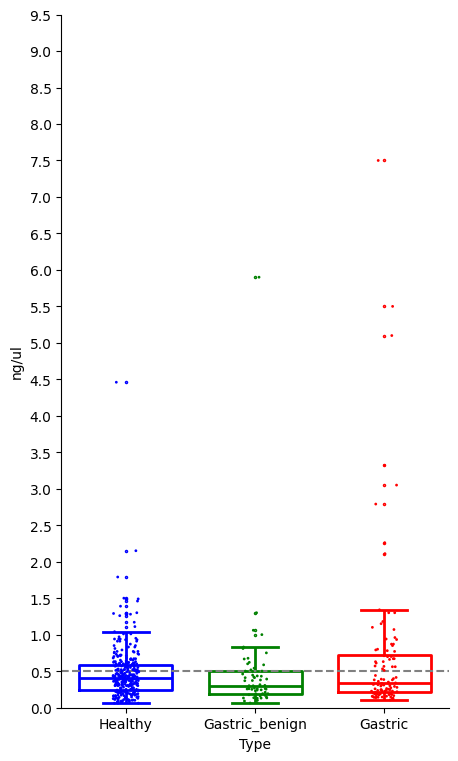

In [ ]:
plt.figure(figsize=(5,9))
sb.boxplot(data=sample_list_all,y='cfDNA conc',x='Type',
           palette=['b','g','r'],
           order=['Healthy','Gastric_benign','Gastric'],
           fill=False,linewidth=2,
           flierprops=dict(marker='.',markersize=3),
           showfliers=True,legend=False,
           dodge=False,width=0.8,gap=0.1)

sb.stripplot(data=sample_list_all,y='cfDNA conc',x='Type',
             palette=['b','g','r'],size=4,marker='.',linewidth=0,legend=False,
             dodge=False,
             order=['Healthy','Gastric_benign','Gastric'])
plt.ylim(2,9)
plt.yticks(np.arange(0,10,0.5))
plt.ylabel('ng/ul')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.axhline(y=0.5,ls='--',color='gray')

THỐNG KÊ

In [ ]:
FEATURES=[]
Group=[]
P_value=[]
for f in features:
    p_value=[]
    vector=[]
    for s in list(DATA[f]['SampleID']):
        if s in list(sample_list_all['SampleID']):
            vector+=[True]
        else:
            vector+=[False]
    data=DATA[f][vector]
    for c in data.columns[1:]:
        FEATURES+=[c]
        Group+=[f]
        p_value+=[shapiro(data[c])[1]]
    P_value+=list(fdrcorrection(p_value)[1])
df_norm=pd.DataFrame({
    'FEATURES':FEATURES,
    'Group':Group,
    'p_value':P_value
})
df_norm

C:\Users\VODACHO\AppData\Roaming\Python\Python38\site-packages\scipy\stats\_morestats.py:1813: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


FEATURES Group       p_value
0                       EM_AAAA    EM  4.291343e-07
1                       EM_AAAC    EM  4.139246e-02
2                       EM_AAAG    EM  8.592037e-06
3                       EM_AAAT    EM  1.548428e-09
4                       EM_AACA    EM  6.950232e-05
...                         ...   ...           ...
13513  CLE_22:47000001-48000000   CLE  5.597926e-01
13514  CLE_22:48000001-49000000   CLE  8.219958e-04
13515  CLE_22:49000001-50000000   CLE  4.290662e-05
13516  CLE_22:50000001-51000000   CLE  4.085718e-01
13517  CLE_22:51000001-51304566   CLE  2.480254e-02

[13518 rows x 3 columns]

In [ ]:
df_norm['Group'].value_counts()

Group
RATIOST    2874
RATIOSL    2872
CLE        2730
CNA        1942
SCNA       1942
NFP         601
FLEN        301
EM          256
Name: count, dtype: int64

In [ ]:
df_norm[df_norm['p_value']>0.05]['Group'].value_counts()

Group
SCNA    742
CLE     664
CNA     434
NFP     320
EM       25
FLEN      7
Name: count, dtype: int64

In [ ]:
df_norm[df_norm['p_value']>0.05]

FEATURES Group   p_value
11                      EM_AAGT    EM  0.494793
36                      EM_AGCA    EM  0.081044
65                      EM_CAAC    EM  0.345361
66                      EM_CAAG    EM  0.105993
68                      EM_CACA    EM  0.943099
...                         ...   ...       ...
13510  CLE_22:44000001-45000000   CLE  0.056712
13511  CLE_22:45000001-46000000   CLE  0.199621
13512  CLE_22:46000001-47000000   CLE  0.283826
13513  CLE_22:47000001-48000000   CLE  0.559793
13516  CLE_22:50000001-51000000   CLE  0.408572

[2192 rows x 3 columns]

In [ ]:
# list_columns_vlookup=[exp_id+'Cohort','Label','Class','Type','Age','Gender']

In [ ]:
# col_start=len(list_columns_vlookup)+1
# col_start

In [ ]:
PAIR=[
    'Healthy vs Gastric',
    'Gastric_benign vs Gastric',
    'Nongastric vs Gastric'
]

In [ ]:
# stats_fea={}
# for f in features:
#     result=pd.DataFrame()
#     for p in PAIR:
#         name_1=p.split(' vs ')[0]
#         name_2=p.split(' vs ')[1]

#         vector1=[]
#         for s in list(DATA[f]['SampleID']):
#             if s in list(SAMPLES[name_1]['SampleID']):
#                 vector1+=[True]
#             else:
#                 vector1+=[False]
#         df_1=DATA[f][vector1]

#         vector2=[]
#         for s in list(DATA[f]['SampleID']):
#             if s in list(SAMPLES[name_2]['SampleID']):
#                 vector2+=[True]
#             else:
#                 vector2+=[False]
#         df_2=DATA[f][vector2]

#         stats_bi=STATS_binary(df_1=df_1,df_2=df_2,col_start=1,name_1=name_1,name_2=name_2,groups_PADJ=[f])
#         result=pd.concat([result,stats_bi],axis=1)
#     else:
#         result = result.loc[:,~result.columns.duplicated()].copy()
#         stats_fea[f]=result


In [ ]:
# !!!! Chỉ chạy 1 lần xong khóa code lại 
# with pd.ExcelWriter(exp_id+'_STATS.xlsx') as writer:
#     for f in features:
#         # if f not in ['CONCAT','CONCAT21','CONCAT21TM']:
#             stats_fea[f].to_excel(writer,sheet_name=f,index=False)

In [ ]:
stats_fea={}
for f in features:
    stats_fea[f]=pd.read_excel(exp_id+'_STATS.xlsx',sheet_name=f)

In [ ]:
stats_fea['EM']

FEATURES  Mean of Healthy  Mean of Gastric  Median of Healthy  \
0    EM_AAAA         0.009974         0.009853           0.010034   
1    EM_AAAC         0.003898         0.003842           0.003898   
2    EM_AAAG         0.006057         0.006025           0.006066   
3    EM_AAAT         0.006300         0.006175           0.006339   
4    EM_AACA         0.004318         0.004216           0.004318   
..       ...              ...              ...                ...   
251  EM_TTGT         0.001663         0.001671           0.001650   
252  EM_TTTA         0.003739         0.003660           0.003788   
253  EM_TTTC         0.002614         0.002597           0.002637   
254  EM_TTTG         0.002052         0.002044           0.002042   
255  EM_TTTT         0.005686         0.005612           0.005744   

     Median of Gastric  SD of Healthy  SD of Gastric  CV% of Healthy  \
0             0.009908       0.000431       0.000499        4.322317   
1             0.003861       0.000119       0.000131        3.062776   
2             0.006044       0.000189       0.000227        3.116268   
3             0.006201       0.000275       0.000306        4.370630   
4             0.004241       0.000135       0.000158        3.124981   
..                 ...            ...            ...             ...   
251           0.001604       0.000129       0.000225        7.764785   
252           0.003672       0.000268       0.000348        7.155768   
253           0.002604       0.000134       0.000197        5.131833   
254           0.002009       0.000141       0.000210        6.869397   
255           0.005629       0.000391       0.000512        6.874196   

     CV% of Gastric  Entropy of Healthy  ...  Entropy of Nongastric  \
0          5.060155            4.297984  ...               4.453046   
1          3.413437            4.390649  ...               4.587198   
2          3.761037            4.164699  ...               4.285951   
3          4.950670            4.247742  ...               4.436735   
4          3.752826            4.531615  ...               4.522378   
..              ...                 ...  ...                    ...   
251       13.453650            4.455028  ...               4.641959   
252        9.504425            4.353832  ...               4.487851   
253        7.595545            4.407842  ...               4.585914   
254       10.266318            4.533050  ...               4.725997   
255        9.121056            4.165725  ...               4.356089   

     Log2FC of Nongastric vs Gastric  Log2FC Median of Nongastric vs Gastric  \
0                          -0.018604                               -0.018804   
1                          -0.018383                               -0.011268   
2                          -0.005820                               -0.005302   
3                          -0.030780                               -0.032627   
4                          -0.032531                               -0.023950   
..                               ...                                     ...   
251                         0.006987                               -0.043042   
252                        -0.034465                               -0.048057   
253                        -0.012523                               -0.018373   
254                        -0.009622                               -0.029320   
255                        -0.022929                               -0.031654   

     P of Nongastric vs Gastric  PADJ of Nongastric vs Gastric  \
0                  1.794834e-02                       0.034547   
1                  1.216858e-03                       0.003423   
2                  2.596153e-01                       0.330654   
3                  3.380964e-05                       0.000166   
4                  3.042864e-07                       0.000004   
..                          ...                            ...   
251                3.193822e-01   

In [ ]:
Thong_ke_stats_split=pd.DataFrame({'Pairs':PAIR})
for f in features:
    lst=[]
    df=stats_fea[f]
    for p in PAIR:
        lst+=[len(df[(df['PADJ of '+p]<0.05)&(df['Log2FC Median of '+p]<0)])]
    Thong_ke_stats_split[f]=lst
Thong_ke_stats_split

Pairs  EM  FLEN  NFP  CNA  SCNA  RATIOSL  RATIOST  CLE
0         Healthy vs Gastric  77    70   29    0     0        0        0    0
1  Gastric_benign vs Gastric  64    26    5    0     0        0        0    0
2      Nongastric vs Gastric  81    66   28    0     0        0        0    0

In [ ]:
Thong_ke_stats_split.to_clipboard(index=False)

In [ ]:
Thong_ke_stats_split=pd.DataFrame({'Pairs':PAIR})
for f in features:
    lst=[]
    df=stats_fea[f]
    for p in PAIR:
        lst+=[len(df[(df['PADJ of '+p]<0.05)&(df['Log2FC Median of '+p]>=0)])]
    Thong_ke_stats_split[f]=lst
Thong_ke_stats_split

Pairs  EM  FLEN  NFP  CNA  SCNA  RATIOSL  RATIOST  CLE
0         Healthy vs Gastric  50    35  114    0     0        0        0    0
1  Gastric_benign vs Gastric  56     7  113    0     0        0        0    0
2      Nongastric vs Gastric  55    32  143    0     0        0        0    0

In [ ]:
Thong_ke_stats_split.to_clipboard(index=False)

EM ven

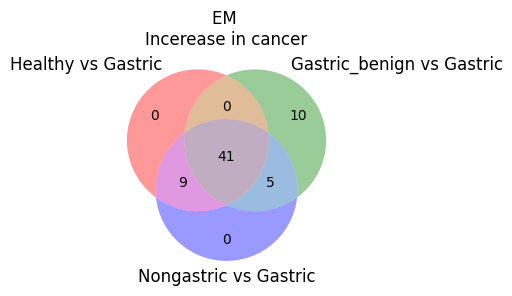

In [ ]:
f='EM'
df=stats_fea[f]
a=set(df[(df['PADJ of '+PAIR[0]]<0.05)&(df['Log2FC Median of '+PAIR[0]]>=0)]['FEATURES'])
b=set(df[(df['PADJ of '+PAIR[1]]<0.05)&(df['Log2FC Median of '+PAIR[1]]>=0)]['FEATURES'])
c=set(df[(df['PADJ of '+PAIR[2]]<0.05)&(df['Log2FC Median of '+PAIR[2]]>=0)]['FEATURES'])
plt.figure(figsize=(3,3))
matplotlib_venn.venn3_unweighted([a,b,c],[PAIR[0],PAIR[1],PAIR[2]])
plt.title(f+" \nIncerease in cancer")
overlap01=list(a&b-c)
overlap012=list(a&b&c)

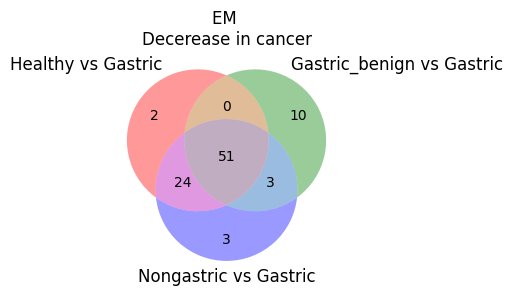

In [ ]:
f='EM'
df=stats_fea[f]
a=set(df[(df['PADJ of '+PAIR[0]]<0.05)&(df['Log2FC Median of '+PAIR[0]]<0)]['FEATURES'])
b=set(df[(df['PADJ of '+PAIR[1]]<0.05)&(df['Log2FC Median of '+PAIR[1]]<0)]['FEATURES'])
c=set(df[(df['PADJ of '+PAIR[2]]<0.05)&(df['Log2FC Median of '+PAIR[2]]<0)]['FEATURES'])
plt.figure(figsize=(3,3))
matplotlib_venn.venn3_unweighted([a,b,c],[PAIR[0],PAIR[1],PAIR[2]])
plt.title(f+" \nDecerease in cancer")
overlap01=list(a&b-c)
overlap012=list(a&b&c)

EM heatmap log2FC

In [ ]:
p=PAIR[0]
#p=PAIR[1]
#p=PAIR[2]

In [ ]:
sample_list=pd.concat([SAMPLES[p.split(' vs ')[0]],SAMPLES[p.split(' vs ')[1]]],axis=0)
sample_list

SampleID   Labcode  Label  Class     Type Subtype   AI   PI   Age  \
87    K0AAAE55  K0AAAE55    0.0    0.0  Healthy     NaN  NaN  NaN  63.0   
108   K0AAAE61  K0AAAE61    0.0    0.0  Healthy     NaN  NaN  NaN  58.0   
147   K0AAAB29  K0AAAB29    0.0    0.0  Healthy     NaN  NaN  NaN  51.0   
155   K2DAAC72  K2DAAC72    0.0    0.0  Healthy     NaN  NaN  NaN  63.0   
174   K0AAAC01  K0AAAC01    0.0    0.0  Healthy     NaN  NaN  NaN  51.0   
...        ...       ...    ...    ...      ...     ...  ...  ...   ...   
4834  ZLBG78NB     LBG78    1.0    4.0  Gastric     NaN  NaN  NaN  63.0   
4835  ZLBG80NB     LBG80    1.0    4.0  Gastric     NaN  NaN  NaN  37.0   
4851  ZLBG79NB     LBG79    1.0    4.0  Gastric     NaN  NaN  NaN  43.0   
5136     LBG84     LBG84    1.0    4.0  Gastric     NaN  NaN  NaN  34.0   
5340   HNGK002   HNGK002    1.0    4.0  Gastric   DHYHN  NaN  NaN  66.0   

     Gender  ... Gini v2.2 Cohort Gini v2.2 SMBM4_Cohort SMBM4_Pair  SMBM4_EM  \
87        M  ...              NaN       NaN          NaN        NaN       NaN   
108       M  ...              NaN       NaN          NaN        NaN       NaN   
147       M  ...              NaN       NaN          NaN        NaN       NaN   
155       F  ...            train       NaN          NaN        NaN       NaN   
174       F  ...              NaN       NaN          NaN        NaN       NaN   
...     ...  ...              ...       ...          ...        ...       ...   
4834      M  ...              NaN       NaN          NaN        NaN       NaN   
4835      F  ...              NaN       NaN          NaN        NaN       NaN   
4851      F  ...            train       NaN    Discovery        NaN  0.134044   
5136      F  ...            train       NaN    Discovery        NaN  0.977398   
5340      F  ...            train       NaN    Discovery        NaN  0.824366   

      SMBM4_FLEN SMBM4_NFP SMBM4_CNA SMBM4_FLEN_ratio_short_total  \
87           NaN       NaN       NaN                          NaN   
108          NaN       NaN       NaN                          NaN   
147          NaN       NaN       NaN                          NaN   
155          NaN       NaN       NaN                          NaN   
174          NaN       NaN       NaN                          NaN   
...          ...       ...       ...                          ...   
4834         NaN       NaN       NaN                          NaN   
4835         NaN       NaN       NaN                          NaN   
4851    0.555603  0.519553  0.179656                     0.542055   
5136    0.561465  0.678691  0.957840                     0.581652   
5340    0.720236  0.709702  0.132726                     0.529748   

     SMBM4_STACKED  
87             NaN  
108            NaN  
147            NaN  
155            NaN  
174            NaN  
...            ...  
4834           NaN  
4835           NaN  
4851      0.389803  
5136      0.650858  
5340      0.522349  

[419 rows x 47 columns]

In [ ]:
result=pd.DataFrame(stats_fea['EM'])
result['nu_start']=result.apply(lambda row: row['FEATURES'][-4],axis=1)
result.index=result.apply(lambda row: row['FEATURES'][-4:],axis=1)
result.sort_values(by=['nu_start','Mean of '+p.split(' vs ')[0],],ascending=True)
result

FEATURES  Mean of Healthy  Mean of Gastric  Median of Healthy  \
AAAA  EM_AAAA         0.009974         0.009853           0.010034   
AAAC  EM_AAAC         0.003898         0.003842           0.003898   
AAAG  EM_AAAG         0.006057         0.006025           0.006066   
AAAT  EM_AAAT         0.006300         0.006175           0.006339   
AACA  EM_AACA         0.004318         0.004216           0.004318   
...       ...              ...              ...                ...   
TTGT  EM_TTGT         0.001663         0.001671           0.001650   
TTTA  EM_TTTA         0.003739         0.003660           0.003788   
TTTC  EM_TTTC         0.002614         0.002597           0.002637   
TTTG  EM_TTTG         0.002052         0.002044           0.002042   
TTTT  EM_TTTT         0.005686         0.005612           0.005744   

      Median of Gastric  SD of Healthy  SD of Gastric  CV% of Healthy  \
AAAA           0.009908       0.000431       0.000499        4.322317   
AAAC           0.003861       0.000119       0.000131        3.062776   
AAAG           0.006044       0.000189       0.000227        3.116268   
AAAT           0.006201       0.000275       0.000306        4.370630   
AACA           0.004241       0.000135       0.000158        3.124981   
...                 ...            ...            ...             ...   
TTGT           0.001604       0.000129       0.000225        7.764785   
TTTA           0.003672       0.000268       0.000348        7.155768   
TTTC           0.002604       0.000134       0.000197        5.131833   
TTTG           0.002009       0.000141       0.000210        6.869397   
TTTT           0.005629       0.000391       0.000512        6.874196   

      CV% of Gastric  Entropy of Healthy  ...  \
AAAA        5.060155            4.297984  ...   
AAAC        3.413437            4.390649  ...   
AAAG        3.761037            4.164699  ...   
AAAT        4.950670            4.247742  ...   
AACA        3.752826            4.531615  ...   
...              ...                 ...  ...   
TTGT       13.453650            4.455028  ...   
TTTA        9.504425            4.353832  ...   
TTTC        7.595545            4.407842  ...   
TTTG       10.266318            4.533050  ...   
TTTT        9.121056            4.165725  ...   

      Log2FC of Nongastric vs Gastric  Log2FC Median of Nongastric vs Gastric  \
AAAA                        -0.018604                               -0.018804   
AAAC                        -0.018383                               -0.011268   
AAAG                        -0.005820                               -0.005302   
AAAT                        -0.030780                               -0.032627   
AACA                        -0.032531                               -0.023950   
...                               ...                                     ...   
TTGT                         0.006987                               -0.043042   
TTTA                        -0.034465                               -0.048057   
TTTC                        -0.012523                               -0.018373   
TTTG                        -0.009622                               -0.029320   
TTTT                        -0.022929                               -0.031654   

      P of Nongastric vs Gastric  PADJ of Nongastric vs Gastric  \
AAAA                1.794834e-02                       0.034547   
AAAC                1.216858e-03                       0.003423   
AAAG                2.596153e-01                       0.330654   
AAAT                3.380964e-05                       0.000166   
AACA                3.042864e-07                       0.000004   
...                          ...                            ...   
TTGT                3.193822e-01                       0.396902   
TTTA                3.484635e-03                       0.008416   
TTTC                7.062132e-02                       0.113705   
TTTG                1.648870e-01                       

In [ ]:
result['Log2FC_+-']=result.apply(lambda r: 0 if r['Log2FC Median of '+p]<0 else 1,axis=1)
result['ABS Log2FC Median of '+p]=result.apply(lambda r: abs(r['Log2FC Median of '+p]),axis=1)
result['Sig']=result.apply(lambda r: 0 if r['PADJ of '+p] <=0.05 else 1,axis=1)
nu_start_order=[]
for nu_start in result['nu_start']:
    if nu_start == 'A':
        nu_start_order+=[0]
    elif nu_start == 'T':
        nu_start_order+=[1]
    elif nu_start == 'G':
        nu_start_order+=[2]
    elif nu_start == 'C':
        nu_start_order+=[3]    
result['nu_start_order']=nu_start_order
result

FEATURES  Mean of Healthy  Mean of Gastric  Median of Healthy  \
AAAA  EM_AAAA         0.009974         0.009853           0.010034   
AAAC  EM_AAAC         0.003898         0.003842           0.003898   
AAAG  EM_AAAG         0.006057         0.006025           0.006066   
AAAT  EM_AAAT         0.006300         0.006175           0.006339   
AACA  EM_AACA         0.004318         0.004216           0.004318   
...       ...              ...              ...                ...   
TTGT  EM_TTGT         0.001663         0.001671           0.001650   
TTTA  EM_TTTA         0.003739         0.003660           0.003788   
TTTC  EM_TTTC         0.002614         0.002597           0.002637   
TTTG  EM_TTTG         0.002052         0.002044           0.002042   
TTTT  EM_TTTT         0.005686         0.005612           0.005744   

      Median of Gastric  SD of Healthy  SD of Gastric  CV% of Healthy  \
AAAA           0.009908       0.000431       0.000499        4.322317   
AAAC           0.003861       0.000119       0.000131        3.062776   
AAAG           0.006044       0.000189       0.000227        3.116268   
AAAT           0.006201       0.000275       0.000306        4.370630   
AACA           0.004241       0.000135       0.000158        3.124981   
...                 ...            ...            ...             ...   
TTGT           0.001604       0.000129       0.000225        7.764785   
TTTA           0.003672       0.000268       0.000348        7.155768   
TTTC           0.002604       0.000134       0.000197        5.131833   
TTTG           0.002009       0.000141       0.000210        6.869397   
TTTT           0.005629       0.000391       0.000512        6.874196   

      CV% of Gastric  Entropy of Healthy  ...  Round_Mean of Nongastric  \
AAAA        5.060155            4.297984  ...                      0.01   
AAAC        3.413437            4.390649  ...                      0.00   
AAAG        3.761037            4.164699  ...                      0.01   
AAAT        4.950670            4.247742  ...                      0.01   
AACA        3.752826            4.531615  ...                      0.00   
...              ...                 ...  ...                       ...   
TTGT       13.453650            4.455028  ...                      0.00   
TTTA        9.504425            4.353832  ...                      0.00   
TTTC        7.595545            4.407842  ...                      0.00   
TTTG       10.266318            4.533050  ...                      0.00   
TTTT        9.121056            4.165725  ...                      0.01   

      -log10(p-value) of Nongastric vs Gastric  \
AAAA                                  1.461587   
AAAC                                  2.465561   
AAAG                                  0.480626   
AAAT                                  3.778723   
AACA                                  5.370407   
...                                        ...   
TTGT                                  0.401317   
TTTA                                  2.074909   
TTTC                                  0.944221   
TTTG                                  0.639392   
TTTT                                  1.114880   

      Distance of Nongastric vs Gastric  AUC of Nongastric vs Gastric  \
AAAA                          -0.000128                      0.423113   
AAAC                          -0.000049                      0.394908   
AAAG                          -0.000024                      0.463377   
AAAT                          -0.000133                      0.365303   
AACA                          -0.000096                      0.333641   
...                                 ...                           ...   
TTGT                           0.000008                      0.467652   
TTTA                          -0.000088                      0.405092   
TTTC                          -0.000023                      0.441266   
TTTG                          -0.000014                

C:\Users\VODACHO\AppData\Local\Temp\ipykernel_21408\772452825.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g1=sb.barplot(data=data[['FEATURES','AUCADJ of '+p]][64*(n-1):64*n],x='FEATURES',y='AUCADJ of '+p,
C:\Users\VODACHO\AppData\Local\Temp\ipykernel_21408\772452825.py:87: UserWarning: 
The palette list has fewer values (1) than needed (64) and will cycle, which may produce an uninterpretable plot.
  g1=sb.barplot(data=data[['FEATURES','AUCADJ of '+p]][64*(n-1):64*n],x='FEATURES',y='AUCADJ of '+p,
C:\Users\VODACHO\AppData\Local\Temp\ipykernel_21408\772452825.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g1=sb.barplot(data=data[['FEATURES','AUCADJ of '+p]][64*(n-1):64*n],x='FEATURES',y='AUCADJ of '

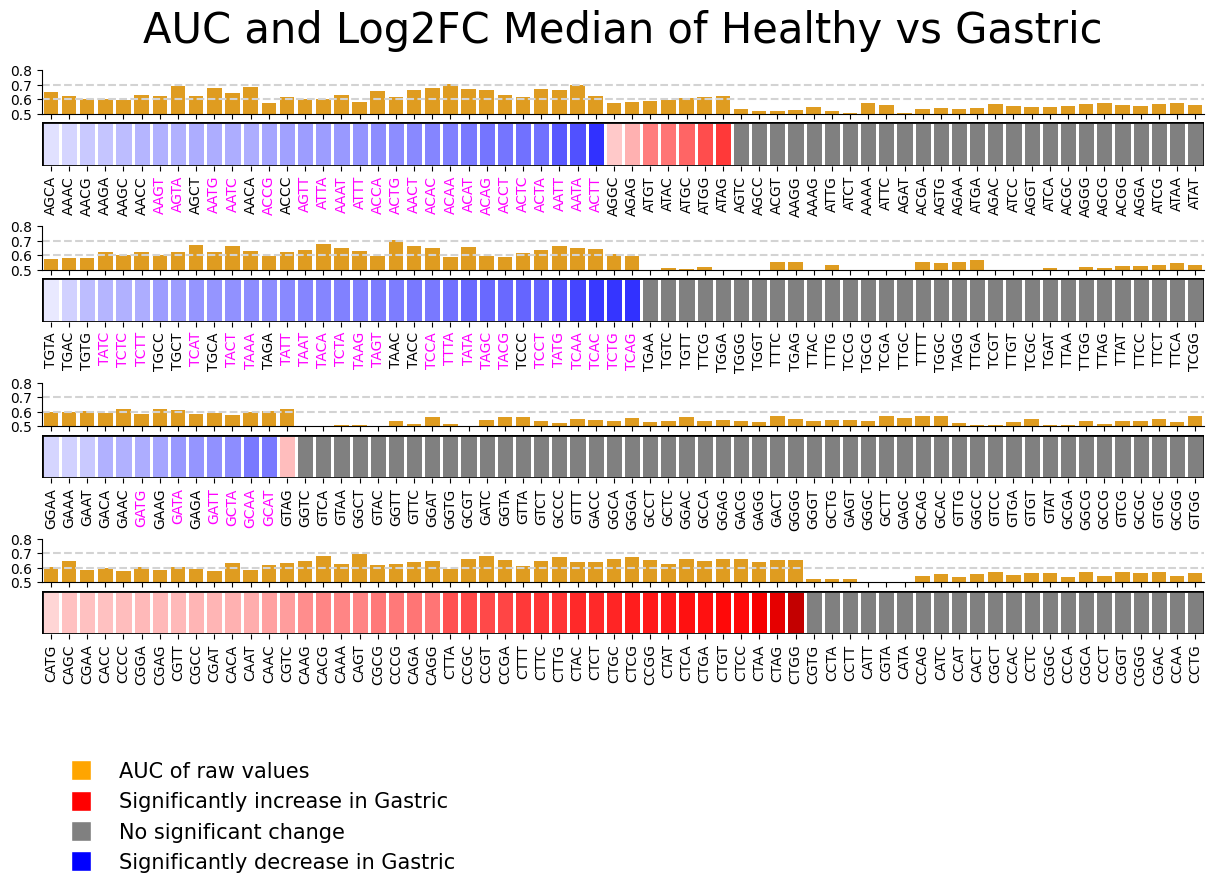

In [ ]:
# data=result.sort_values(by=['nu_start','PlusMinus_Log2FC_'+p.split('-')[0]+'_'+p.split('-')[1],'ABS_Log2FC_'+p.split('-')[0]+'_'+p.split('-')[1]],ascending=True)
data=result.sort_values(by=['nu_start_order','Sig','Log2FC_+-','ABS Log2FC Median of '+p,],ascending=True)
# data=result
# cols=['Mean_F_Healthy','Mean_M_Healthy']
lst_PDAJ=list(data[data['PADJ of '+p.split(' vs ')[0]+' vs '+p.split(' vs ')[1]]<0.05]['FEATURES'])
set1=lst_PDAJ
# for n in [1,2,3,4,5,6,7,8]:
fig, axs = plt.subplots(12, 1, figsize=(15, 8))

for n in [1,2,3,4]:
        # A=data[cols][32*(n-1):32*n].T
        # A=data[['Mean of '+p.split(' vs ')[0],'Mean of '+p.split(' vs ')[1]]][64*(n-1):64*n].T
        # cmap = matplotlib.colormaps["Greens"]
        #         # Set the under color to white
        #         # cmap.set_under("yellow")
        #         # # Set the voer color to white
        #         # cmap.set_over("black")
        # # Set the background color
        # plt.figure(figsize=(15,1))
        # g = sb.heatmap(A,
        #                 # vmin=0,
        #                 # vmax=0.0125,
        #                 cmap=cmap,
        #                 # mask=mask_array,
        #                 yticklabels=True,
        #                 linewidths=2)
        # Set color of masked region
        # g.set_facecolor('gray')
        # if n==1: plt.title(col)
        # plt.title(col)

        lst_out=[]
        for i in list(np.arange(64*(n-1),64*n)):
                # if data['FEATURES'].iloc[i] not in lst_PDAJ:
                if data['FEATURES'].iloc[i] not in set(stats_fea['EM'][stats_fea['EM']['PADJ of '+p]<0.05]['FEATURES']):
                        lst_out+=[i-64*(n-1)]


        col = 'Log2FC Median of '+p.split(' vs ')[0]+' vs '+p.split(' vs ')[1]




        B = data[[col]][64*(n-1):64*n].T
        B.index=[B.columns[0][0]]
        mask_array = np.zeros((1, 64), dtype=bool)
        mask_array[:, lst_out] = True
        cmap = matplotlib.colormaps["seismic"]
        # Set the under color to white
        # cmap.set_under("yellow")
        # # Set the voer color to white
        # cmap.set_over("black")
        # Set the background color
        # plt.figure(figsize=(15,0.7))
        # cbar=True if n==1 else False
        g = sb.heatmap(B,
                        # vmin=-max([abs(min(data[col])),abs(max(data[col]))]),
                        # vmax=max([abs(min(data[col])),abs(max(data[col]))]),
                        vmin=-0.16,
                        vmax=0.16,
                        cmap=cmap,
                        mask=mask_array,
                        yticklabels=False,
                        linewidths=2,
                        # linecolor='black',
                        cbar=False,
                        # cbar_kws={'shrink': 1, 'fraction': 0.5, 'pad': 0.03},
                        # ax=axs[n-1])
                        # ax=axs[2*n-1])
                        ax=axs[(n-1)*3+1])
        # Set color of masked region
        g.set_facecolor('gray')
        # plt.title(col)ax.axhline(y=0, color='k',linewidth=10)
        g.axhline(y=0, color='k',linewidth=2)
        g.axhline(y=1, color='k',linewidth=2)
        g.axvline(x=0, color='k',linewidth=2)
        g.axvline(x=64, color='k',linewidth=2)
        for labe in g.get_xticklabels():
                text = 'EM_'+labe.get_text()
                if text in overlap012:
                        labe.set_color('magenta')
                elif text in overlap01:
                        labe.set_color('g')



        g1=sb.barplot(data=data[['FEATURES','AUCADJ of '+p]][64*(n-1):64*n],x='FEATURES',y='AUCADJ of '+p,
                #       ax=axs[2*n-2],
                      ax=axs[(n-1)*3],
                      palette=['orange'])
        g1.axhline(y=0.6,ls='--',color='lightgray')
        g1.axhline(y=0.7,ls='--',color='lightgray')
        g1.spines['top'].set_visible(False)
        g1.spines['right'].set_visible(False)
        g1.tick_params(axis='x', labelrotation=90,labelbottom=False)
        g1.set_xlabel('')
        g1.set_ylabel('')
        g1.set_yticks([0.5,0.6,0.7,0.8])
        # sb.despine(left=True)
        g1.set_xlim(left=-0.5)
        g1.set_ylim([0.5,0.8])

        if n==1: g1.set_title('AUC and '+col,pad=20,fontsize=30)

        axs[(n-1)*3+2].axis('off')
plt.tight_layout()
custom_lines = [Line2D([0], [0],marker='s', color='w', markerfacecolor='orange', markersize=15),
        Line2D([0], [0],marker='s', color='w', markerfacecolor='r', markersize=15),
                Line2D([0], [0],marker='s', color='w', markerfacecolor='gray', markersize=15),
                    Line2D([0], [0],marker='s', color='w', markerfacecolor='b', markersize=15),
                    ]
plt.legend(custom_lines,['AUC of raw values','Significantly increase in '+p.split(' vs ')[1],'No significant change','Significantly decrease in '+p.split(' vs ')[1]],loc='upper left',fontsize=15, bbox_to_anchor=(0, -1.3),frameon=False)
# plt.savefig('.\Figure\EM.png', dpi=600, bbox_inches='tight')
plt.subplots_adjust(hspace=0.2)

EM top sig

In [ ]:
stats_fea['EM'].sort_values(by='Log2FC Median of '+p).reset_index(drop=True).head(5)[['PADJ of '+PAIR[0],'PADJ of '+PAIR[1],'PADJ of '+PAIR[2]]]

PADJ of Healthy vs Gastric  PADJ of Gastric_benign vs Gastric  \
0                    0.008617                           0.011358   
1                    0.000690                           0.003120   
2                    0.002436                           0.003103   
3                    0.000066                           0.016960   
4                    0.000057                           0.009095   

   PADJ of Nongastric vs Gastric  
0                       0.003824  
1                       0.000266  
2                       0.000889  
3                       0.000054  
4                       0.000038

In [ ]:
stats_fea['EM'].sort_values(by='Log2FC Median of '+p,ascending=False).reset_index(drop=True)

FEATURES  Mean of Healthy  Mean of Gastric  Median of Healthy  \
0    EM_CTGG         0.005403         0.005874           0.005335   
1    EM_CTAG         0.004163         0.004457           0.004111   
2    EM_CTAA         0.006525         0.006856           0.006453   
3    EM_CTCC         0.003712         0.003903           0.003656   
4    EM_CTGT         0.005535         0.005870           0.005502   
..       ...              ...              ...                ...   
251  EM_TCAA         0.003951         0.003835           0.003976   
252  EM_TCAC         0.003381         0.003290           0.003405   
253  EM_TCTG         0.004458         0.004347           0.004483   
254  EM_ACTT         0.004583         0.004396           0.004540   
255  EM_TCAG         0.003303         0.003222           0.003325   

     Median of Gastric  SD of Healthy  SD of Gastric  CV% of Healthy  \
0             0.005785       0.000634       0.000977       11.731701   
1             0.004393       0.000465       0.000610       11.179018   
2             0.006845       0.000690       0.000752       10.569121   
3             0.003855       0.000338       0.000372        9.093460   
4             0.005802       0.000493       0.000670        8.908640   
..                 ...            ...            ...             ...   
251           0.003819       0.000217       0.000269        5.489095   
252           0.003263       0.000185       0.000213        5.469184   
253           0.004292       0.000318       0.000392        7.139224   
254           0.004344       0.000467       0.000543       10.178970   
255           0.003182       0.000311       0.000381        9.405372   

     CV% of Gastric  Entropy of Healthy  ...  Entropy of Nongastric  \
0         16.630874            4.288070  ...               4.415066   
1         13.692806            4.363191  ...               4.504806   
2         10.969891            4.395758  ...               4.508808   
3          9.539238            4.458388  ...               4.591877   
4         11.416790            4.410991  ...               4.521643   
..              ...                 ...  ...                    ...   
251        7.003903            4.505461  ...               4.702758   
252        6.475666            4.507758  ...               4.421500   
253        9.010468            4.404161  ...               4.365391   
254       12.353675            4.326246  ...               3.870553   
255       11.832617            4.481741  ...               4.529714   

     Log2FC of Nongastric vs Gastric  Log2FC Median of Nongastric vs Gastric  \
0                           0.123712                                0.119041   
1                           0.099319                                0.092396   
2                           0.070559                                0.082486   
3                           0.071663                                0.073867   
4                           0.086374                                0.076296   
..                               ...                                     ...   
251                        -0.042761                               -0.058945   
252                        -0.038901                               -0.057100   
253                        -0.041267                               -0.065891   
254                        -0.074834                               -0.065063   
255                        -0.041537                               -0.067351   

     P of Nongastric vs Gastric  PADJ of Nongastric vs Gastric  \
0                  6.677359e-07                       0.000007   
1                  2.392056e-06                       0.000017   
2                  4.512056e-05                       0.000203   
3                  1.098835e-06                       0.000009   
4                  1.024539e-06                       0.000009   
..                          ...                            ...   
251                6.120061e-06   

In [ ]:
EM_top=list(stats_fea['EM'].sort_values(by='Log2FC Median of '+p).reset_index(drop=True)['FEATURES'][0:5])+list(stats_fea['EM'].sort_values(by='Log2FC Median of '+p,ascending=False).reset_index(drop=True)['FEATURES'][0:5])
EM_top

['EM_TCAG',
 'EM_ACTT',
 'EM_TCTG',
 'EM_TCAC',
 'EM_TCAA',
 'EM_CTGG',
 'EM_CTAG',
 'EM_CTAA',
 'EM_CTCC',
 'EM_CTGT']

In [ ]:
vector=[]
for s in list(DATA[f]['SampleID']):
    if s in list(sample_list['SampleID']):
        vector+=[True]
    else:
        vector+=[False]
data=DATA[f][vector]
labels=[]
for s in list(data['SampleID']):
    labels+=[list(sample_list[sample_list['SampleID']==s]['Label'])[0]]
data.insert(loc=1,column='Label',value=labels)
data.sort_values(by='SampleID',inplace=True)
data.reset_index(drop=True,inplace=True)
EM_plot1=data[['Label']+EM_top[0:5]].melt(id_vars="Label")
EM_plot1['x']=EM_plot1.apply(lambda r: r['variable'][3:]+'_'+str(int(r['Label'])),axis=1)
EM_plot1.sort_values(by='x',inplace=True)
EM_plot1

C:\Users\VODACHO\AppData\Local\Temp\ipykernel_21408\3132616749.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.sort_values(by='SampleID',inplace=True)


Label variable     value       x
787     0.0  EM_ACTT  0.004648  ACTT_0
556     0.0  EM_ACTT  0.004537  ACTT_0
557     0.0  EM_ACTT  0.004703  ACTT_0
558     0.0  EM_ACTT  0.004587  ACTT_0
559     0.0  EM_ACTT  0.004370  ACTT_0
...     ...      ...       ...     ...
1145    1.0  EM_TCTG  0.004688  TCTG_1
1143    1.0  EM_TCTG  0.004817  TCTG_1
1142    1.0  EM_TCTG  0.004049  TCTG_1
855     1.0  EM_TCTG  0.004395  TCTG_1
1255    1.0  EM_TCTG  0.004544  TCTG_1

[2095 rows x 4 columns]

In [ ]:
EM_plot2=data[['Label']+EM_top[5:10]].melt(id_vars="Label")
EM_plot2

Label variable     value
0       1.0  EM_CTGG  0.007276
1       1.0  EM_CTGG  0.005483
2       1.0  EM_CTGG  0.005892
3       1.0  EM_CTGG  0.004778
4       1.0  EM_CTGG  0.004633
...     ...      ...       ...
2090    1.0  EM_CTGT  0.005717
2091    1.0  EM_CTGT  0.005954
2092    1.0  EM_CTGT  0.006039
2093    1.0  EM_CTGT  0.005199
2094    1.0  EM_CTGT  0.005970

[2095 rows x 3 columns]

Text(0.5, 1.0, 'Healthy vs Gastric')

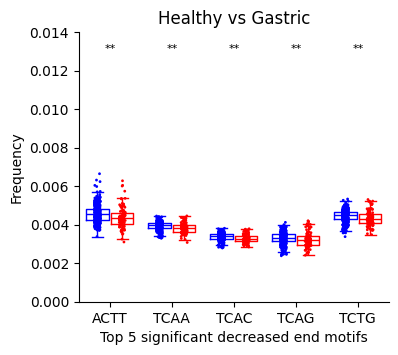

In [ ]:
plt.figure(figsize=(4,3.5))
sb.boxplot(data=EM_plot1,y='value',x='variable',hue='Label',
           palette=['b','r'],hue_order=[0,1],fill=False,linewidth=1,
           flierprops=dict(marker='.',markersize=3),
           showfliers=False,legend=False,
           dodge=True,width=0.8,gap=0.1)
sb.stripplot(data=EM_plot1,y='value',x='variable',hue='Label',
             palette=['b','r'],hue_order=[0,1],
             marker='.',size=4,linewidth=0,legend=False,
             dodge=True
             )
plt.yticks(np.arange(0,0.016,0.002))
plt.ylim(0,0.014)
plt.xticks(ticks=[0,1,2,3,4],labels=[em.split('_')[1] for em in list(EM_plot1['variable'].unique())])
plt.ylabel('Frequency')
plt.xlabel('Top 5 significant decreased end motifs')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
custom_lines = [
                    # Line2D([0], [0], color='w', lw=0, marker='*', markersize=00),
                    Line2D([0], [0],marker='s', color='b', markerfacecolor='w', markersize=5),     
                    Line2D([0], [0],marker='s', color='r', markerfacecolor='w', markersize=5),
                    ]
# plt.legend(custom_lines,['p-value < 0.00001','Control (n=168)','Lung cancer (n=99)'],bbox_to_anchor=(1.3, .8),loc='center right',frameon=False)
# plt.legend(custom_lines,['Control (n=168)','Lung cancer (n=99)'],bbox_to_anchor=(1.05, .1),loc='center right',frameon=False)

plt.text(x=0,y=0.013,s='**',ha='center',fontsize=8)
plt.text(x=1,y=0.013,s='**',ha='center',fontsize=8)
plt.text(x=2,y=0.013,s='**',ha='center',fontsize=8)
plt.text(x=3,y=0.013,s='**',ha='center',fontsize=8)
plt.text(x=4,y=0.013,s='**',ha='center',fontsize=8)
plt.title(p)
# plt.text(x=4.7,y=0.007,s='**',fontsize=8)
# plt.savefig('.\Figure/EM_top5_1.png',dpi=600,bbox_inches='tight')

Text(-1.1, -0.0065, '**  p-value < 0.05')

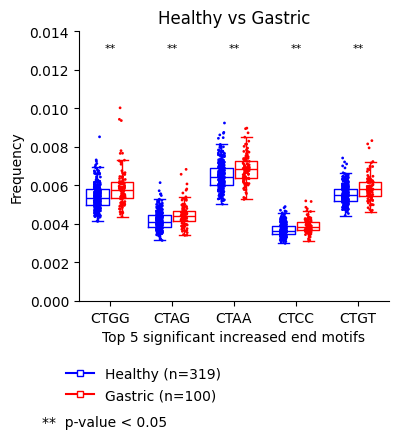

In [ ]:
plt.figure(figsize=(4,3.5))
sb.boxplot(data=EM_plot2,y='value',x='variable',hue='Label',
           palette=['b','r'],hue_order=[0,1],fill=False,linewidth=1,
           flierprops=dict(marker='.',markersize=3),
           showfliers=False,
           dodge=True,width=0.8,gap=0.1)
sb.stripplot(data=EM_plot2,y='value',x='variable',hue='Label',
             palette=['b','r'],hue_order=[0,1],
             marker='.',size=4,linewidth=0,
             dodge=True
             )
plt.yticks(np.arange(0,0.016,0.002))
plt.ylim(0,0.014)
plt.xticks(ticks=[0,1,2,3,4],labels=[em.split('_')[1] for em in list(EM_plot2['variable'].unique())])
plt.ylabel('Frequency')
plt.xlabel('Top 5 significant increased end motifs')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
custom_lines = [
                    # Line2D([0], [0], color='w', lw=0, marker='*', markersize=00),
                    Line2D([0], [0],marker='s', color='b', markerfacecolor='w', markersize=5),     
                    Line2D([0], [0],marker='s', color='r', markerfacecolor='w', markersize=5),
                    ]
# plt.legend(custom_lines,['p_value < 0.00001','Healthy','Lung'],bbox_to_anchor=(1, .8),frameon=False)
# plt.legend(custom_lines,['Control \n(n=168)','Lung cancer \n(n=99)'],bbox_to_anchor=(1.45, .8),loc='center right',frameon=False)
tys=[p.split(' vs ')[0]+' (n='+str(len(SAMPLES[p.split(' vs ')[0]]))+')',
     p.split(' vs ')[1]+' (n='+str(len(SAMPLES[p.split(' vs ')[1]]))+')']
plt.legend(custom_lines,tys,frameon=False,loc='upper right', bbox_to_anchor=(0.5, -0.2))
plt.text(x=0,y=0.013,s='**',ha='center',fontsize=8)
plt.text(x=1,y=0.013,s='**',ha='center',fontsize=8)
plt.text(x=2,y=0.013,s='**',ha='center',fontsize=8)
plt.text(x=3,y=0.013,s='**',ha='center',fontsize=8)
plt.text(x=4,y=0.013,s='**',ha='center',fontsize=8)
# plt.text(x=4.7,y=0.0021,s='*****',fontsize=8)
# plt.savefig('.\Figure/EM_top5_2.png',dpi=600,bbox_inches='tight')
plt.title(p)
plt.text(x=-1.1,y=-0.0065,s='**  p-value < 0.05')

In [ ]:
# for

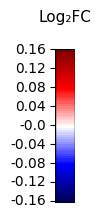

In [ ]:
a=0.16
step1=0.005
Cbar=pd.DataFrame({u'log\u2082(fold change)':np.arange(a,-(a+step1),-step1)})
Cbar.index=[round(x,2) for x in Cbar[u'log\u2082(fold change)']]
plt.figure(figsize=(0.25,2))
Cbar_g=sb.heatmap(Cbar,
           cbar=False,
           cmap = matplotlib.colormaps["seismic"],
           xticklabels=False,
           )
labels=[round(i,2) for i in np.arange(a,-(a+0.04),-0.04)]
step=(len(Cbar)-1)/(len(labels)-1)
ticks=list(np.arange(0,len(Cbar),step))
plt.yticks(ticks=ticks,labels=labels)
plt.title(u'Log\u2082FC',pad=20,fontsize=11)
Cbar_g.axhline(y=0, color='k',linewidth=1)
Cbar_g.axhline(y=len(Cbar), color='k',linewidth=1)
Cbar_g.axvline(x=0, color='k',linewidth=1)
Cbar_g.axvline(x=1, color='k',linewidth=1)

FLEN distribution

In [ ]:
f='FLEN'

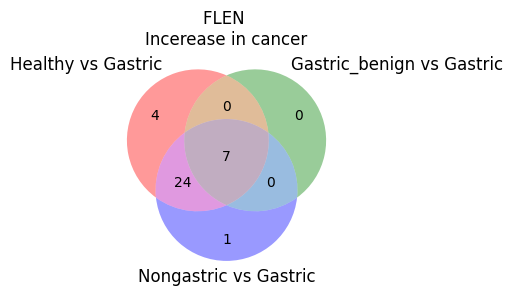

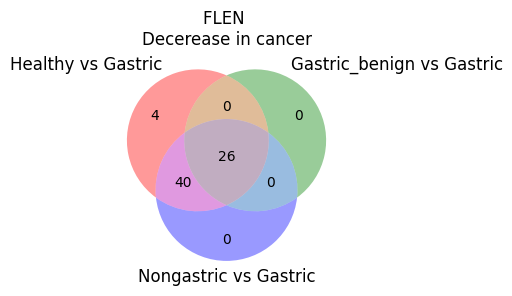

In [ ]:
df=stats_fea[f]
a=set(df[(df['PADJ of '+PAIR[0]]<0.05)&(df['Log2FC Median of '+PAIR[0]]>=0)]['FEATURES'])
b=set(df[(df['PADJ of '+PAIR[1]]<0.05)&(df['Log2FC Median of '+PAIR[1]]>=0)]['FEATURES'])
c=set(df[(df['PADJ of '+PAIR[2]]<0.05)&(df['Log2FC Median of '+PAIR[2]]>=0)]['FEATURES'])
plt.figure(figsize=(3,3))
matplotlib_venn.venn3_unweighted([a,b,c],[PAIR[0],PAIR[1],PAIR[2]])
plt.title(f+" \nIncerease in cancer")
overlap01=list(a&b-c)
overlap012=list(a&b&c)

df=stats_fea[f]
a=set(df[(df['PADJ of '+PAIR[0]]<0.05)&(df['Log2FC Median of '+PAIR[0]]<0)]['FEATURES'])
b=set(df[(df['PADJ of '+PAIR[1]]<0.05)&(df['Log2FC Median of '+PAIR[1]]<0)]['FEATURES'])
c=set(df[(df['PADJ of '+PAIR[2]]<0.05)&(df['Log2FC Median of '+PAIR[2]]<0)]['FEATURES'])
plt.figure(figsize=(3,3))
matplotlib_venn.venn3_unweighted([a,b,c],[PAIR[0],PAIR[1],PAIR[2]])
plt.title(f+" \nDecerease in cancer")
overlap01=list(a&b-c)
overlap012=list(a&b&c)

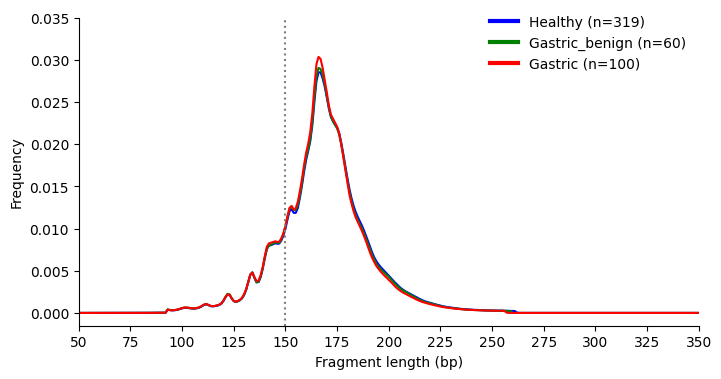

In [ ]:
G={
    'Healthy':'b',
    'Gastric_benign':'g',
    'Gastric':'r'
    }
plt.figure(figsize=(8,4))
custom_lines=[]
# x=np.arange(100,251,1)
x=np.arange(50,351,1)

for g in list(G.keys()):
    y1=stats_fea['FLEN']['Median of '+g]
    sb.lineplot(x=x,y=y1,color=G[g],lw=1.5)
    custom_lines += [Line2D([0], [0], color=G[g], lw=3)]

plt.axvline(x=150, color='gray', label='axvline - full height',ls=':')
tys=['Healthy (n='+str(len(SAMPLES['Healthy']))+')',
     'Gastric_benign (n='+str(len(SAMPLES['Gastric_benign']))+')',
     'Gastric (n='+str(len(SAMPLES['Gastric']))+')']
plt.legend(custom_lines,tys,bbox_to_anchor=(1, 1.05),frameon=False)
plt.ylabel('Frequency')
plt.xlabel('Fragment length (bp)')
# plt.xticks(np.arange(100,275,25))
plt.xlim(50,350)
plt.xticks(np.arange(50,375,25))
plt.yticks(np.arange(0,0.04,0.005))
# plt.title('Fragment length distribution')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.savefig('.\Figure/FLEN_50-350_distribution.png', dpi=600, bbox_inches='tight')

([<matplotlib.axis.XTick at 0x1d0d749c310>,
 [Text(50, 0, '50'),
  Text(75, 0, '75'),
  Text(100, 0, '100'),
  Text(125, 0, '125'),
  Text(150, 0, '150'),
  Text(175, 0, '175'),
  Text(200, 0, '200'),
  Text(225, 0, '225'),
  Text(250, 0, '250'),
  Text(275, 0, '275'),
  Text(300, 0, '300'),
  Text(325, 0, '325'),
  Text(350, 0, '350')])

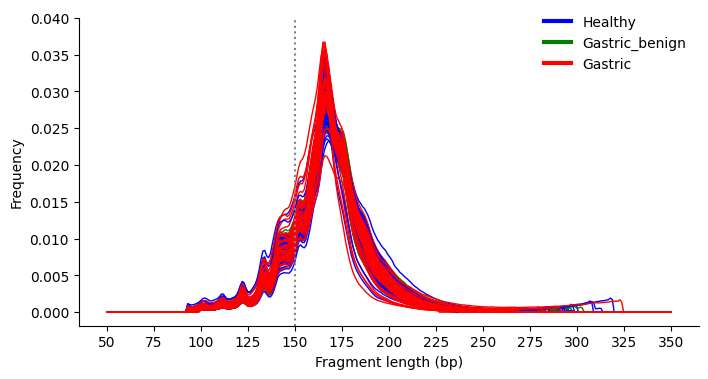

In [ ]:
G2={
    'Healthy':'blue',
    'Gastric_benign':'g',
    'Gastric':'r'
    }
plt.figure(figsize=(8,4))
custom_lines=[Line2D([0], [0], color='b', lw=3),
              Line2D([0], [0], color='g', lw=3),
              Line2D([0], [0], color='r', lw=3)]
vector=[]
for s in list(DATA[f]['SampleID']):
    if s in list(sample_list_all['SampleID']):
        vector+=[True]
    else:
        vector+=[False]
data=DATA[f][vector]
labels=[]
for s in list(data['SampleID']):
    labels+=[list(sample_list_all[sample_list_all['SampleID']==s]['Type'])[0]]
data.insert(loc=1,column='Type',value=labels)
data.sort_values(by='Type',ascending=False)
data.reset_index(drop=True,inplace=True)

x=np.arange(50,351,1)
for i in range(len(data)):
    g=data['Type'][i]
    y2=data.iloc[i,2:]
    sb.lineplot(x=x,y=y2,color=G2[g],lw=1)
plt.legend(custom_lines,['Healthy','Gastric_benign','Gastric'],bbox_to_anchor=(1, 1.05),frameon=False)
plt.ylabel('Frequency')
plt.xlabel('Fragment length (bp)')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.axvline(x=150, color='gray', label='axvline - full height',ls=':')
# sb.lineplot(x=x,y=stats_fea['FLEN100']['Mean of Lung'],color='b',lw=2)
# sb.lineplot(x=x,y=stats_fea['FLEN100']['Mean of Healthy'],color='r',lw=2)
# plt.title(fea['FLEN100']['SampleID'][r])
plt.yticks(np.arange(0,0.045,0.005))
plt.xticks(np.arange(50,375,25))

In [ ]:
df=pd.DataFrame(data[data['Type']=='Healthy'])[['SampleID','FLEN_200']].sort_values(by='FLEN_200')
df

SampleID  FLEN_200
22      K2DAAA79  0.001414
229     K0GAAK74  0.002041
421     K0CAAK99  0.002440
41      K7GAAA06  0.002493
24      K2DAAA85  0.002623
..           ...       ...
36      K2GAAC35  0.006042
438     K0GAAL76  0.006069
105  ZK0CAAH81NB  0.006116
20      K2AAAB60  0.006169
189     K0DAAF26  0.007670

[319 rows x 2 columns]

([<matplotlib.axis.XTick at 0x1d0daff16a0>,
 [Text(50, 0, '50'),
  Text(75, 0, '75'),
  Text(100, 0, '100'),
  Text(125, 0, '125'),
  Text(150, 0, '150'),
  Text(175, 0, '175'),
  Text(200, 0, '200'),
  Text(225, 0, '225'),
  Text(250, 0, '250'),
  Text(275, 0, '275'),
  Text(300, 0, '300'),
  Text(325, 0, '325'),
  Text(350, 0, '350')])

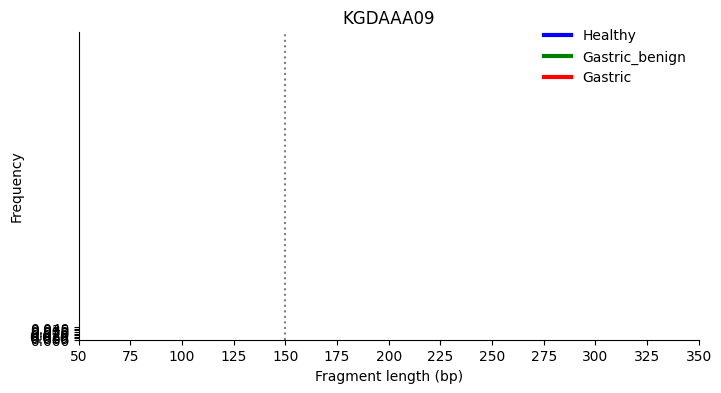

In [ ]:
special_sample='KGDAAA09'
G2={
    'Healthy':'blue',
    'Gastric_benign':'g',
    'Gastric':'r'
    }
plt.figure(figsize=(8,4))
custom_lines=[Line2D([0], [0], color='b', lw=3),
              Line2D([0], [0], color='g', lw=3),
              Line2D([0], [0], color='r', lw=3)]
vector=[]
for s in list(DATA[f]['SampleID']):
    if s in list(sample_list_all['SampleID']):
        vector+=[True]
    else:
        vector+=[False]
data=DATA[f][vector]
labels=[]
for s in list(data['SampleID']):
    labels+=[list(sample_list_all[sample_list_all['SampleID']==s]['Type'])[0]]
data.insert(loc=1,column='Type',value=labels)
data.sort_values(by='Type',ascending=False)
data.reset_index(drop=True,inplace=True)

x=np.arange(50,351,1)
for i in range(len(data)):
    g=data['Type'][i]
    y2=data.iloc[i,2:]
    if data['SampleID'][i]==special_sample:
        sb.lineplot(x=x,y=y2,color=G2[g],lw=1)
plt.legend(custom_lines,['Healthy','Gastric_benign','Gastric'],bbox_to_anchor=(1, 1.05),frameon=False)
plt.ylabel('Frequency')
plt.xlabel('Fragment length (bp)')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.axvline(x=150, color='gray', label='axvline - full height',ls=':')
# sb.lineplot(x=x,y=stats_fea['FLEN100']['Mean of Lung'],color='b',lw=2)
# sb.lineplot(x=x,y=stats_fea['FLEN100']['Mean of Healthy'],color='r',lw=2)
plt.title(special_sample)
plt.yticks(np.arange(0,0.045,0.005))
plt.xticks(np.arange(50,375,25))

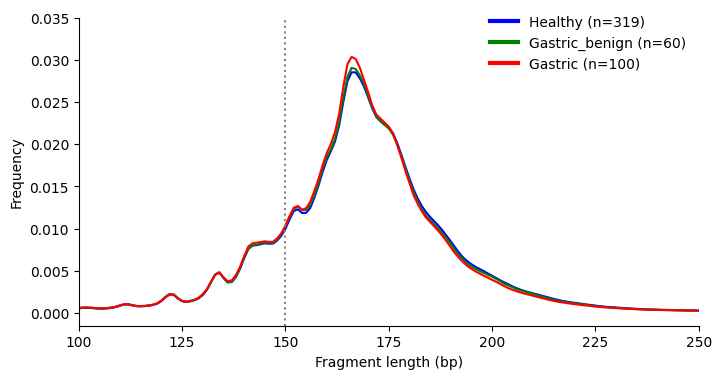

In [ ]:
G={
    'Healthy':'b',
    'Gastric_benign':'g',
    'Gastric':'r'
    }
plt.figure(figsize=(8,4))
custom_lines=[]
# x=np.arange(100,251,1)
x=np.arange(50,351,1)

for g in list(G.keys()):
    y1=stats_fea['FLEN']['Median of '+g]
    sb.lineplot(x=x,y=y1,color=G[g],lw=1.5)
    custom_lines += [Line2D([0], [0], color=G[g], lw=3)]

plt.axvline(x=150, color='gray', label='axvline - full height',ls=':')
tys=['Healthy (n='+str(len(SAMPLES['Healthy']))+')',
     'Gastric_benign (n='+str(len(SAMPLES['Gastric_benign']))+')',
     'Gastric (n='+str(len(SAMPLES['Gastric']))+')']
plt.legend(custom_lines,tys,bbox_to_anchor=(1, 1.05),frameon=False)
plt.ylabel('Frequency')
plt.xlabel('Fragment length (bp)')
# plt.xticks(np.arange(100,275,25))
plt.xticks(np.arange(50,375,25))
plt.xlim(100,250)
plt.yticks(np.arange(0,0.04,0.005))
# plt.title('Fragment length distribution')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.savefig('.\Figure/FLEN_50-350_distribution.png', dpi=600, bbox_inches='tight')

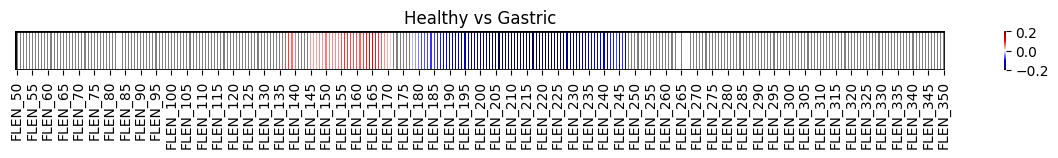

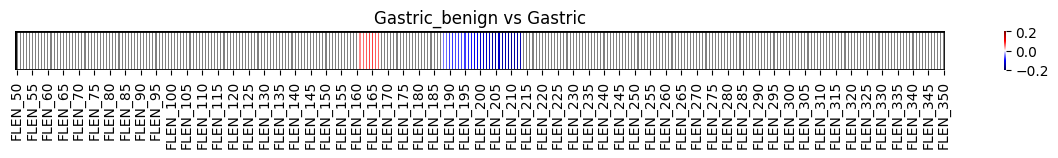

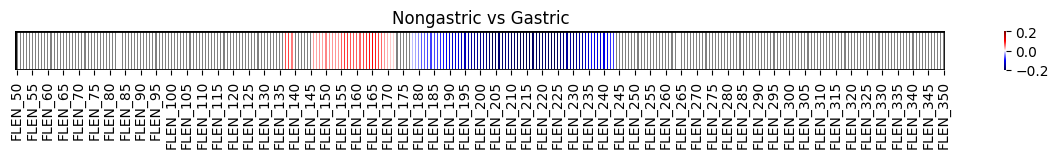

In [ ]:
for p in PAIR:
    df=stats_fea['FLEN']
    set_Overlap=df[df['PADJ of '+p]<=0.05]['FEATURES']
    # df.index=df.apply(lambda row: row['FEATURES'].split('_')[1],axis=1)
    df.index=df.apply(lambda row: row['FEATURES'],axis=1)
    lst_in_out=[]
    for i in range(len(df['FEATURES'])):
        if df['FEATURES'].iloc[i] not in list(set_Overlap):
            lst_in_out+=[i]
    len(lst_in_out)

    A = df[['Log2FC Median of '+p]].T
    mask_array = np.zeros((1, df.shape[0]), dtype=bool)
    mask_array[:, lst_in_out] = True
    cmap = matplotlib.colormaps["seismic"]
    # Set the under color to white
    # cmap.set_under("yellow")
    # # Set the voer color to white
    # cmap.set_over("black")
    # Set the background color
    plt.figure(figsize=(15,0.5))
    g = sb.heatmap(A,
                    # vmin=-max([abs(min(df[col])),abs(max(df[col]))]),
                    # vmax=max([abs(min(df[col])),abs(max(df[col]))]),
                   vmin=-0.2,vmax=0.2,
                   cmap=cmap, mask=mask_array,yticklabels=False,
                   cbar=True,linewidths=0.003,linecolor='w',
                #    cbar_kws={'label': u'log\u2082(fold change)'}
                )
    # Set color of masked region
    g.set_facecolor('gray')
    g.axhline(y=0, color='k',linewidth=2)
    g.axhline(y=1, color='k',linewidth=2)
    g.axvline(x=0, color='k',linewidth=2)
    g.axvline(x=301, color='k',linewidth=2)
    g.set_title(p)
    # colorbar = g.collections[0].colorbar
    # colorbar.set_label('Colorbar Title', fontsize=12, labelpad=10)
    # colorbar.ax.invert_yaxis()
    # colorbar.set_label(u'log\u2082(fold change)', fontsize=12, rotation=0)
    # plt.title(p)
    # plt.savefig('.\Figure/FLEN_50-350_heatmap.png', dpi=600, bbox_inches='tight')

NFP distribution

In [ ]:
f='NFP'

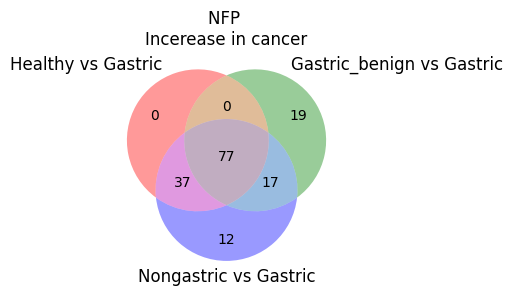

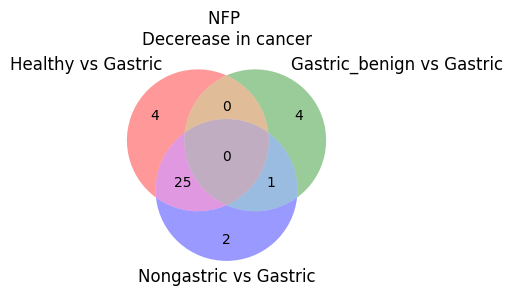

In [ ]:
df=stats_fea[f]
a=set(df[(df['PADJ of '+PAIR[0]]<0.05)&(df['Log2FC Median of '+PAIR[0]]>=0)]['FEATURES'])
b=set(df[(df['PADJ of '+PAIR[1]]<0.05)&(df['Log2FC Median of '+PAIR[1]]>=0)]['FEATURES'])
c=set(df[(df['PADJ of '+PAIR[2]]<0.05)&(df['Log2FC Median of '+PAIR[2]]>=0)]['FEATURES'])
plt.figure(figsize=(3,3))
matplotlib_venn.venn3_unweighted([a,b,c],[PAIR[0],PAIR[1],PAIR[2]])
plt.title(f+" \nIncerease in cancer")
overlap01=list(a&b-c)
overlap012=list(a&b&c)

df=stats_fea[f]
a=set(df[(df['PADJ of '+PAIR[0]]<0.05)&(df['Log2FC Median of '+PAIR[0]]<0)]['FEATURES'])
b=set(df[(df['PADJ of '+PAIR[1]]<0.05)&(df['Log2FC Median of '+PAIR[1]]<0)]['FEATURES'])
c=set(df[(df['PADJ of '+PAIR[2]]<0.05)&(df['Log2FC Median of '+PAIR[2]]<0)]['FEATURES'])
plt.figure(figsize=(3,3))
matplotlib_venn.venn3_unweighted([a,b,c],[PAIR[0],PAIR[1],PAIR[2]])
plt.title(f+" \nDecerease in cancer")
overlap01=list(a&b-c)
overlap012=list(a&b&c)

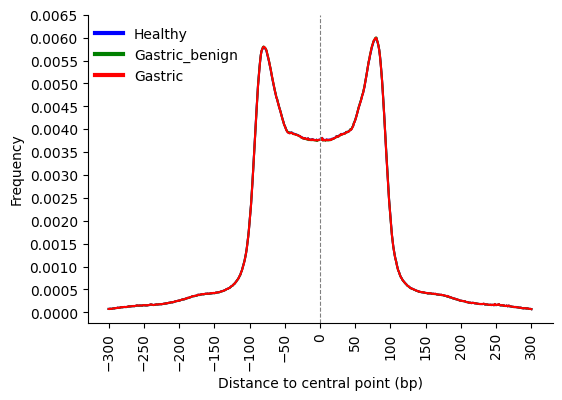

In [ ]:
G={
    'Healthy':'b',
    'Gastric_benign':'g',
    'Gastric':'r'
    }
plt.figure(figsize=(6,4))
custom_lines=[]
x=np.arange(-300,301,1)

for g in list(G.keys()):
    y1=stats_fea['NFP']['Median of '+g]
    ax=sb.lineplot(x=x,y=y1,color=G[g])
    custom_lines += [Line2D([0], [0], color=G[g], lw=3)]

plt.legend(custom_lines,G,bbox_to_anchor=(0.35, 1.),frameon=False)
plt.ylabel('Frequency')
plt.yticks(np.arange(0,0.007,0.0005))
plt.xlabel('Distance to central point (bp)')
plt.xticks(np.arange(-300,350,50),rotation=90)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.axvline(x=0, color='gray', label='axvline - full height',ls='--',lw=0.8)

# plt.axvline(x=-90, ymin=0.0035/0.0070, ymax=0.0065/0.0070,ls='-',lw=0.8,color='gray')
# plt.axvline(x=90, ymin=0.0035/0.0070, ymax=0.0065/0.0070,ls='-',lw=0.8,color='gray')
# plt.axhline(y=0.0035-0.00011, xmin=(300-90+9)/601, xmax=(300+90-7)/601,ls='-',lw=0.8,color='gray')
# plt.axhline(y=0.0065, xmin=(300-90+9)/601, xmax=(300+90-7)/601,ls='-',lw=0.8,color='gray')

# plt.savefig('.\Figure/NFP_distribution.png', dpi=600, bbox_inches='tight')

C:\Users\VODACHO\AppData\Local\Temp\ipykernel_21408\2640780323.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.sort_values(by='order',ascending=True,inplace=True)


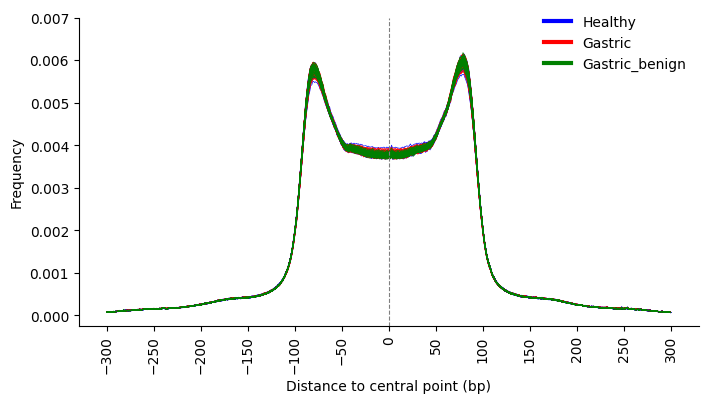

In [ ]:
G2={
    'Healthy':'blue',
    'Gastric':'r',
    'Gastric_benign':'g',   
    }
plt.figure(figsize=(8,4))
custom_lines=[Line2D([0], [0], color='b', lw=3),
              Line2D([0], [0], color='r', lw=3),
              Line2D([0], [0], color='g', lw=3)
              ]
vector=[]
for s in list(DATA[f]['SampleID']):
    if s in list(sample_list_all['SampleID']):
        vector+=[True]
    else:
        vector+=[False]
data=DATA[f][vector]
labels=[]
for s in list(data['SampleID']):
    labels+=[list(sample_list_all[sample_list_all['SampleID']==s]['Type'])[0]]
data.insert(loc=1,column='Type',value=labels)
data.sort_values(by='Type',ascending=False)

order=[]
for s in list(data['SampleID']):
    if list(data[data['SampleID']==s]['Type'])[0]=='Healthy':
        order+=[0]
    elif list(data[data['SampleID']==s]['Type'])[0]=='Gastric':
        order+=[1]
    elif list(data[data['SampleID']==s]['Type'])[0]=='Gastric_benign':
        order+=[2]
data.insert(loc=1,column='order',value=order)
data.sort_values(by='order',ascending=True,inplace=True)          
data.reset_index(drop=True,inplace=True)

x=np.arange(-300,301,1)

# for g in list(G.keys()):
#     y1=stats_fea['NFP']['Mean of '+g]
#     ax=sb.lineplot(x=x,y=y1,color=G[g],lw=2)
#     custom_lines += [Line2D([0], [0], color=G[g], lw=3)]
for i in range(len(data)):
    g=data['Type'][i]
    y2=data.iloc[i,3:]
    sb.lineplot(x=x,y=y2,color=G2[g],lw=0.5)
# sb.lineplot(x=x,y=stats_fea['NFP']['Mean of Lung'],color='b',lw=2)
# sb.lineplot(x=x,y=stats_fea['NFP']['Mean of Healthy'],color='r',lw=2)

plt.legend(custom_lines,['Healthy','Gastric','Gastric_benign'],bbox_to_anchor=(1, 1.05),frameon=False)
plt.ylabel('Frequency')
plt.yticks(np.arange(0,0.008,0.001))
plt.xlabel('Distance to central point (bp)')
plt.xticks(np.arange(-300,350,50),rotation=90)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.axvline(x=0, color='gray', label='axvline - full height',ls='--',lw=0.8)

# plt.axvline(x=-90, ymin=0.0035/0.0070, ymax=0.0065/0.0070,ls='-',lw=0.8,color='gray')
# plt.axvline(x=90, ymin=0.0035/0.0070, ymax=0.0065/0.0070,ls='-',lw=0.8,color='gray')
# plt.axhline(y=0.0035-0.00011, xmin=(300-90+9)/601, xmax=(300+90-7)/601,ls='-',lw=0.8,color='gray')
# plt.axhline(y=0.0065, xmin=(300-90+9)/601, xmax=(300+90-7)/601,ls='-',lw=0.8,color='gray')
# square=patches.Rectangle((0.003, 0.003), 0.006, 0.006, edgecolor='orange', facecolor='none')
# ax.add_patch(square)
# plt.title('Nucleosome footprint partern')
# plt.savefig('.\Figure/NFP_distribution_all.png', dpi=600, bbox_inches='tight')

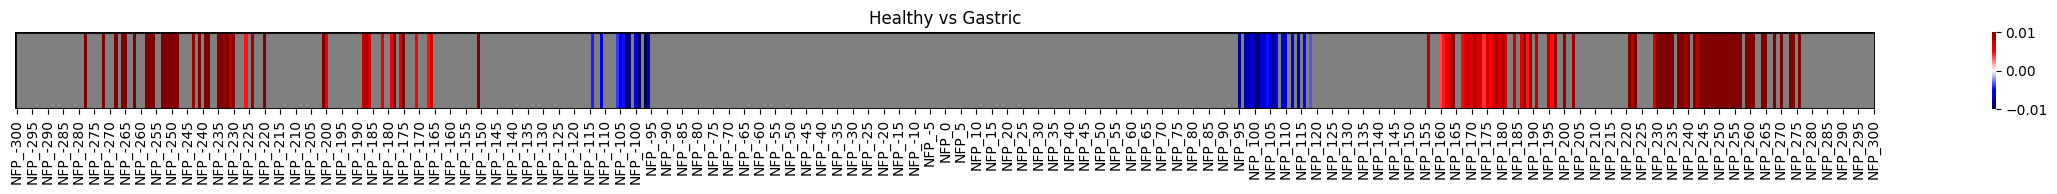

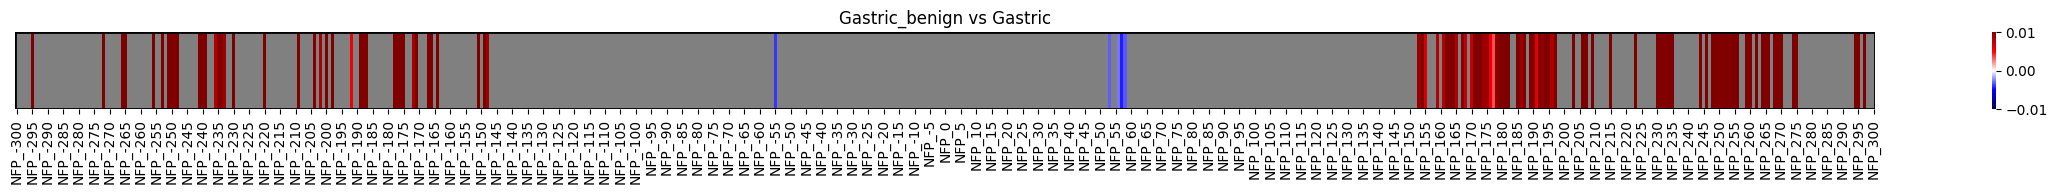

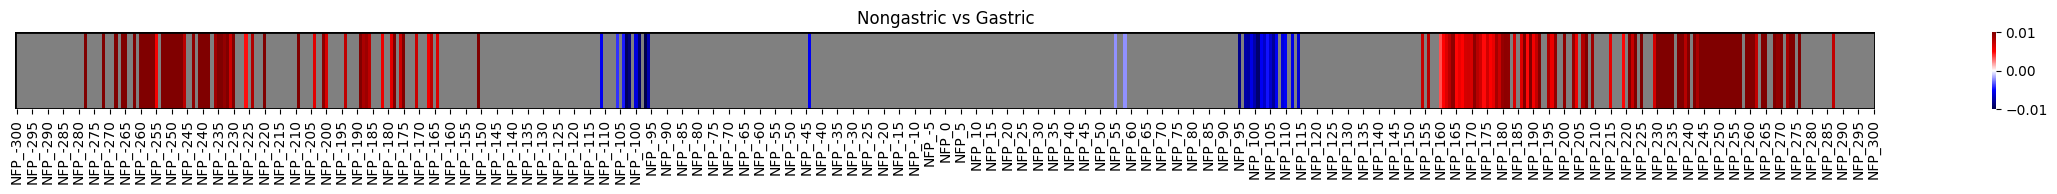

In [ ]:
for p in PAIR:
    df=stats_fea['NFP']
    set_Overlap=df[df['PADJ of '+p]<=0.05]['FEATURES']
    # df.index=df.apply(lambda row: row['FEATURES'].split('_')[1],axis=1)
    df.index=df.apply(lambda row: row['FEATURES'],axis=1)
    lst_in_out=[]
    for i in range(len(df['FEATURES'])):
        if df['FEATURES'].iloc[i] not in list(set_Overlap):
            lst_in_out+=[i]
    len(lst_in_out)

    A = df[['Log2FC Median of '+p]].T
    mask_array = np.zeros((1, df.shape[0]), dtype=bool)
    mask_array[:, lst_in_out] = True
    cmap = matplotlib.colormaps["seismic"]
    # Set the under color to white
    # cmap.set_under("yellow")
    # # Set the voer color to white
    # cmap.set_over("black")
    # Set the background color
    plt.figure(figsize=(30,1))
    g = sb.heatmap(A,
                    # vmin=-max([abs(min(df[col])),abs(max(df[col]))]),
                    # vmax=max([abs(min(df[col])),abs(max(df[col]))]),
                   vmin=-0.01,vmax=0.01,
                   cmap=cmap, mask=mask_array,yticklabels=False,
                   cbar=True,linewidths=0.00,linecolor='w',
                #    cbar_kws={'label': u'log\u2082(fold change)'}
                )
    # Set color of masked region
    g.set_facecolor('gray')
    g.axhline(y=0, color='k',linewidth=2)
    g.axhline(y=1, color='k',linewidth=2)
    g.axvline(x=0, color='k',linewidth=2)
    g.axvline(x=601, color='k',linewidth=2)
    g.set_title(p)
    # colorbar = g.collections[0].colorbar
    # colorbar.set_label('Colorbar Title', fontsize=12, labelpad=10)
    # colorbar.ax.invert_yaxis()
    # colorbar.set_label(u'log\u2082(fold change)', fontsize=12, rotation=0)
    # plt.title(p)
    # plt.savefig('.\Figure/FLEN_50-350_heatmap.png', dpi=600, bbox_inches='tight')

In [ ]:
df=pd.DataFrame(data[data['Type']=='Healthy'])[['SampleID','NFP_75']].sort_values(by='NFP_75')
df

SampleID    NFP_75
125     K0GAAL74  0.005592
87      K2GAAD03  0.005665
300     K0CAAI51  0.005677
113     K2AAAM52  0.005681
115     K2AAAM55  0.005687
..           ...       ...
288     K2AAAC66  0.005966
211     K2DAAB13  0.005973
277  ZK0AAAL06NB  0.005974
136     K2AAAM56  0.005978
308     K0AAAW20  0.005991

[319 rows x 2 columns]

C:\Users\VODACHO\AppData\Local\Temp\ipykernel_21408\1935119429.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.sort_values(by='order',ascending=True,inplace=True)


Text(0.5, 1.0, 'KGDAAA09')

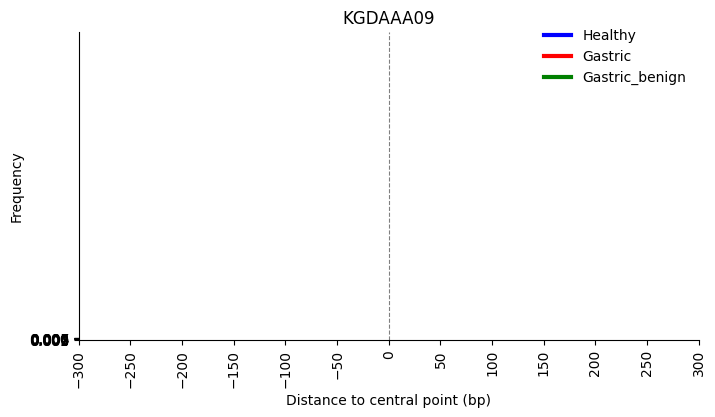

In [ ]:
special_sample='KGDAAA09'
G2={
    'Healthy':'blue',
    'Gastric':'r',
    'Gastric_benign':'g'
    }
plt.figure(figsize=(8,4))
custom_lines=[Line2D([0], [0], color='b', lw=3),
              Line2D([0], [0], color='r', lw=3),
              Line2D([0], [0], color='g', lw=3)
              ]
vector=[]
for s in list(DATA[f]['SampleID']):
    if s in list(sample_list_all['SampleID']):
        vector+=[True]
    else:
        vector+=[False]
data=DATA[f][vector]
labels=[]
for s in list(data['SampleID']):
    labels+=[list(sample_list_all[sample_list_all['SampleID']==s]['Type'])[0]]
data.insert(loc=1,column='Type',value=labels)
data.sort_values(by='Type',ascending=False)

order=[]
for s in list(data['SampleID']):
    if list(data[data['SampleID']==s]['Type'])[0]=='Healthy':
        order+=[0]
    elif list(data[data['SampleID']==s]['Type'])[0]=='Gastric':
        order+=[1]
    elif list(data[data['SampleID']==s]['Type'])[0]=='Gastric_benign':
        order+=[2]
data.insert(loc=1,column='order',value=order)
data.sort_values(by='order',ascending=True,inplace=True)          
data.reset_index(drop=True,inplace=True)

x=np.arange(-300,301,1)

# for g in list(G.keys()):
#     y1=stats_fea['NFP']['Mean of '+g]
#     ax=sb.lineplot(x=x,y=y1,color=G[g],lw=2)
#     custom_lines += [Line2D([0], [0], color=G[g], lw=3)]
for i in range(len(data)):
    g=data['Type'][i]
    y2=data.iloc[i,3:]
    if data['SampleID'][i]==special_sample:
        sb.lineplot(x=x,y=y2,color=G2[g],lw=0.5)
# sb.lineplot(x=x,y=stats_fea['NFP']['Mean of Lung'],color='b',lw=2)
# sb.lineplot(x=x,y=stats_fea['NFP']['Mean of Healthy'],color='r',lw=2)

plt.legend(custom_lines,['Healthy','Gastric','Gastric_benign'],bbox_to_anchor=(1, 1.05),frameon=False)
plt.ylabel('Frequency')
plt.yticks(np.arange(0,0.008,0.001))
plt.xlabel('Distance to central point (bp)')
plt.xticks(np.arange(-300,350,50),rotation=90)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.axvline(x=0, color='gray', label='axvline - full height',ls='--',lw=0.8)

# plt.axvline(x=-90, ymin=0.0035/0.0070, ymax=0.0065/0.0070,ls='-',lw=0.8,color='gray')
# plt.axvline(x=90, ymin=0.0035/0.0070, ymax=0.0065/0.0070,ls='-',lw=0.8,color='gray')
# plt.axhline(y=0.0035-0.00011, xmin=(300-90+9)/601, xmax=(300+90-7)/601,ls='-',lw=0.8,color='gray')
# plt.axhline(y=0.0065, xmin=(300-90+9)/601, xmax=(300+90-7)/601,ls='-',lw=0.8,color='gray')
# square=patches.Rectangle((0.003, 0.003), 0.006, 0.006, edgecolor='orange', facecolor='none')
# ax.add_patch(square)
plt.title(special_sample)
# plt.savefig('.\Figure/NFP_distribution_all.png', dpi=600, bbox_inches='tight')

CNA bins

In [ ]:
def vectorcolor(p,f):
    data_split=stats_fea[f]
    # data_concatenate=stats_fea['All_features']
    col_PADJ='PADJ of '+p
    col_L2FC='Log2FC of '+p
    cols=[]
    for i in list(data_split.iloc[:,0]):
        PADJ_split=data_split[data_split[data_split.columns[0]]==i][col_PADJ].reset_index(drop=True)[0]
        # PADJ_concatenate=data_concatenate[data_concatenate[data_concatenate.columns[0]]==i][col_PADJ].reset_index(drop=True)[0]

        L2FC_split=data_split[data_split[data_split.columns[0]]==i][col_L2FC].reset_index(drop=True)[0]

        if L2FC_split <0 and PADJ_split<=0.05:
            cols.append('b')
        elif L2FC_split >=0 and PADJ_split<=0.05:
            cols.append('red')
        elif PADJ_split>0.05:
            cols.append('gray')
    return cols

In [ ]:
#Tạo position cho chromosome
Chromosome=[]
for i in range(len(stats_fea['CNA'])):
    chromosome=int(stats_fea['CNA']['FEATURES'].iloc[i].split(":")[0].split("_")[1])
    Chromosome+=[chromosome]
results=pd.DataFrame({'Chromosome':Chromosome})
results=results['Chromosome'].value_counts().sort_index()
results=pd.DataFrame({'Count':results})
lst=[]
for i in range(len(results)):
    # lst+=[sum(results.iloc[:i,0])+round(results.iloc[i,0]/2,0)]
    lst+=[sum(results.iloc[:i+1,0])]
results['Vline']=lst

Position=[]
for i in range(1,23,1):
    if i ==1:
        posit=int(results['Vline'][i]/4)
    else:
        posit=int((results['Vline'][i]+results['Vline'][i-1])/2)
    Position+=[posit]
results['Position']=Position
results

Count  Vline  Position
Chromosome                        
1             159    159        39
2             162    321       240
3             148    469       395
4             140    609       539
5             136    745       677
6             120    865       805
7             111    976       920
8             108   1084      1030
9              83   1167      1125
10             93   1260      1213
11             97   1357      1308
12             95   1452      1404
13             75   1527      1489
14             65   1592      1559
15             62   1654      1623
16             52   1706      1680
17             53   1759      1732
18             55   1814      1786
19             33   1847      1830
20             47   1894      1870
21             21   1915      1904
22             27   1942      1928

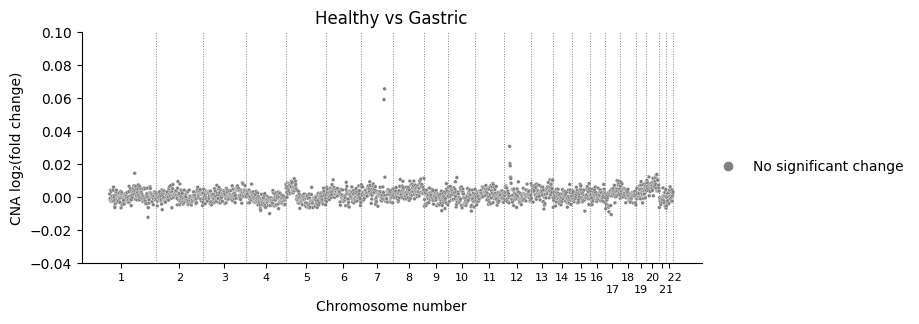

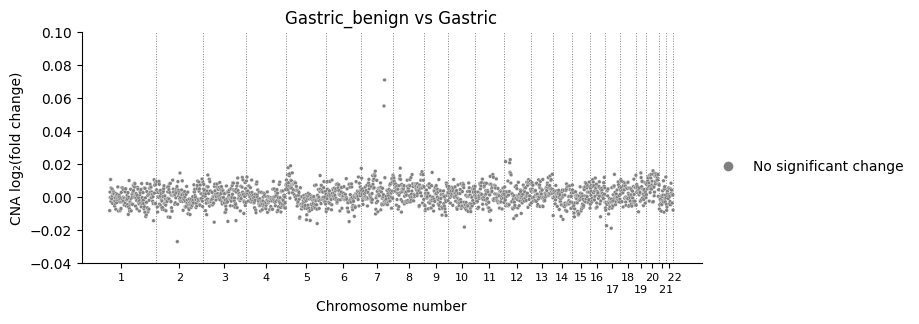

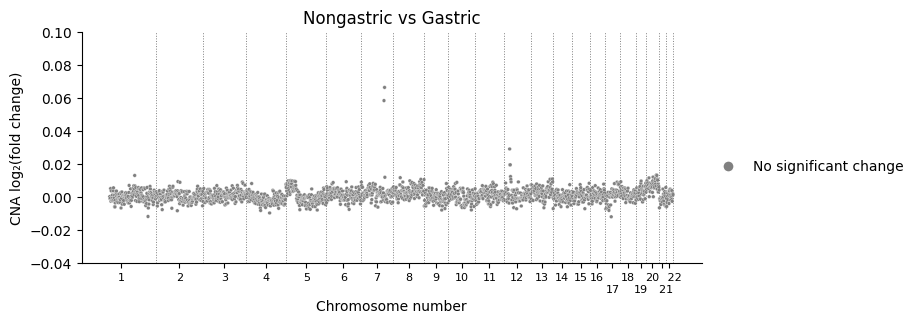

In [ ]:
f='CNA'
custom_lines = [
    # Line2D([0], [0],marker='o', color='w', markerfacecolor='r', markersize=8,mec='w'),
                Line2D([0], [0],marker='o', color='w', markerfacecolor='gray', markersize=8,mec='w'),
                    # Line2D([0], [0],marker='o', color='w', markerfacecolor='b', markersize=8,mec='w'),
                    ]
data=stats_fea[f]
for p in PAIR:
    col_log='Log2FC of '+p
    if col_log not in data.columns:
        col_log='Distance of '+p
    col_PADJ='PADJ of '+p 
    cols=vectorcolor(p,f)

    plt.figure(figsize=(8, 3))
    # plt.figure(figsize=(6/1.4,3/1.5))
    xlabels=['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','\n17','18','\n19','20','\n  21','   22']
    x=data['FEATURES']
    y=data[col_log]

    for vline in results['Vline']:
        plt.axvline(x=vline, color='gray', label='axvline - full height',ls=':',lw=0.7)
        
    sb.scatterplot(x=x,y=y,c=cols,s=7,edgecolor='w')
    # lst_name_show=["CNA_10:135000001-135534747"]
    # region_name = list(data['FEATURES'])
    # for i, txt in enumerate(region_name):
    #     if txt in lst_name_show:
    #         plt.text(x[i],y[i],txt,fontsize=8,color='red')
   
    
    plt.xticks(ticks=results['Position'],labels=xlabels,fontsize=8)
    plt.yticks(np.arange(-0.04,0.1,0.02))
    plt.xlabel('Chromosome number')
    plt.ylabel('CNA '+u'log\u2082(fold change)')
    plt.title(p)
    # n_gain=pd.DataFrame(cols)[0].value_counts()['red']
    # n_loss=pd.DataFrame(cols)[0].value_counts()['b']
    # plt.legend(custom_lines,['CNA gain (n='+str(n_gain)+')','No significant change','CNA loss (n='+str(n_loss)+')'],loc='upper left', bbox_to_anchor=(1, 0.5),frameon=False)
    plt.legend(custom_lines,['No significant change'],loc='upper left', bbox_to_anchor=(1, 0.5),frameon=False)
    # plt.legend(custom_lines,['CNA gain (n='+str(n_gain)+')','No significant change','CNA loss (n='+str(n_loss)+')'],loc='upper right', bbox_to_anchor=(0.5, -0.3),frameon=False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    # plt.savefig('.\Figure\CNA_bins.png', dpi=600, bbox_inches='tight')

SCNA bins

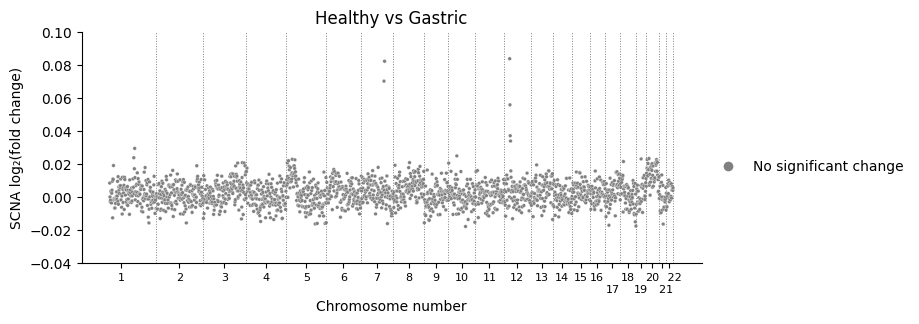

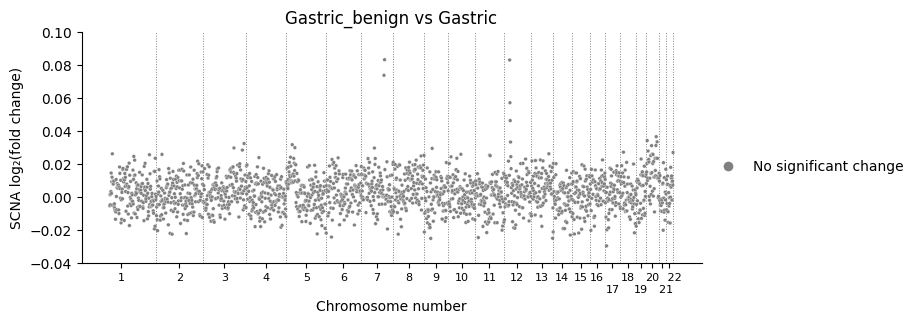

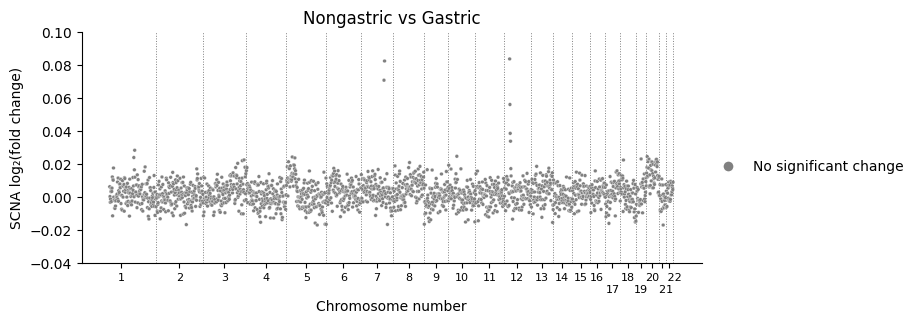

In [ ]:
f='SCNA'
custom_lines = [
    # Line2D([0], [0],marker='o', color='w', markerfacecolor='r', markersize=8,mec='w'),
                Line2D([0], [0],marker='o', color='w', markerfacecolor='gray', markersize=8,mec='w'),
                    # Line2D([0], [0],marker='o', color='w', markerfacecolor='b', markersize=8,mec='w'),
                    ]
data=stats_fea[f]
for p in PAIR:
    col_log='Log2FC of '+p
    if col_log not in data.columns:
        col_log='Distance of '+p
    col_PADJ='PADJ of '+p 
    cols=vectorcolor(p,f)

    plt.figure(figsize=(8, 3))
    # plt.figure(figsize=(6/1.4,3/1.5))
    xlabels=['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','\n17','18','\n19','20','\n  21','   22']
    x=data['FEATURES']
    y=data[col_log]

    for vline in results['Vline']:
        plt.axvline(x=vline, color='gray', label='axvline - full height',ls=':',lw=0.7)
        
    sb.scatterplot(x=x,y=y,c=cols,s=7,edgecolor='w')
    # lst_name_show=["CNA_10:135000001-135534747"]
    # region_name = list(data['FEATURES'])
    # for i, txt in enumerate(region_name):
    #     if txt in lst_name_show:
    #         plt.text(x[i],y[i],txt,fontsize=8,color='red')
   
    
    plt.xticks(ticks=results['Position'],labels=xlabels,fontsize=8)
    plt.yticks(np.arange(-0.04,0.1,0.02))
    plt.xlabel('Chromosome number')
    plt.ylabel('SCNA '+u'log\u2082(fold change)')
    plt.title(p)
    # n_gain=pd.DataFrame(cols)[0].value_counts()['red']
    # n_loss=pd.DataFrame(cols)[0].value_counts()['b']
    # plt.legend(custom_lines,['CNA gain (n='+str(n_gain)+')','No significant change','CNA loss (n='+str(n_loss)+')'],loc='upper left', bbox_to_anchor=(1, 0.5),frameon=False)
    plt.legend(custom_lines,['No significant change'],loc='upper left', bbox_to_anchor=(1, 0.5),frameon=False)
    # plt.legend(custom_lines,['CNA gain (n='+str(n_gain)+')','No significant change','CNA loss (n='+str(n_loss)+')'],loc='upper right', bbox_to_anchor=(0.5, -0.3),frameon=False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    # plt.savefig('.\Figure\CNA_bins.png', dpi=600, bbox_inches='tight')

RATIOSL

In [ ]:
#Tạo position cho chromosome
GWFP=stats_fea['RATIOSL']
GWFP=GWFP[~GWFP['FEATURES'].str.contains('X|Y', case=False, na=False)]
Chromosome=[]
for i in range(len(GWFP)):
    chromosome=GWFP['FEATURES'].iloc[i].split("_")[1].split(':')[0]
    chromosome=int(chromosome)
    Chromosome+=[chromosome]
results=pd.DataFrame({'Chromosome':Chromosome})
results=results['Chromosome'].value_counts().sort_index()
results=pd.DataFrame({'Count':results})
lst=[]
for i in range(len(results)):
    # lst+=[sum(results.iloc[:i,0])+round(results.iloc[i,0]/2,0)]
    lst+=[sum(results.iloc[:i+1,0])]
results['Vline']=lst

Position=[]
for i in range(1,23,1):
    if i ==1:
        posit=int(results['Vline'][i]/4)
    else:
        posit=int((results['Vline'][i]+results['Vline'][i-1])/2)
    Position+=[posit]
results['Position']=Position
results

Count  Vline  Position
Chromosome                        
1             230    230        57
2             241    471       350
3             196    667       569
4             190    857       762
5             178   1035       946
6             165   1200      1117
7             158   1358      1279
8             144   1502      1430
9             117   1619      1560
10            134   1753      1686
11            133   1886      1819
12            132   2018      1952
13             96   2114      2066
14             89   2203      2158
15             83   2286      2244
16             81   2367      2326
17             80   2447      2407
18             76   2523      2485
19             58   2581      2552
20             61   2642      2611
21             38   2680      2661
22             36   2716      2698

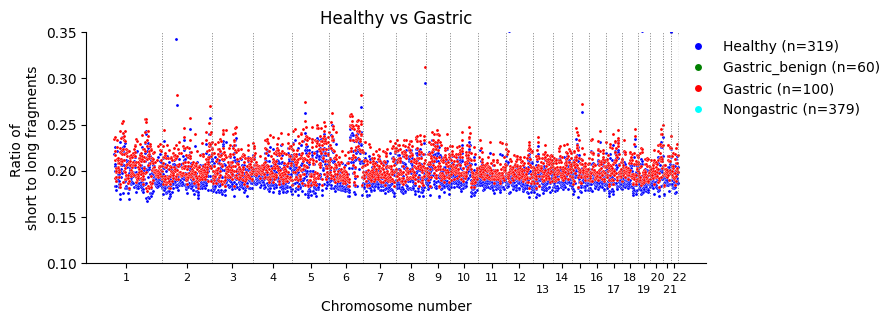

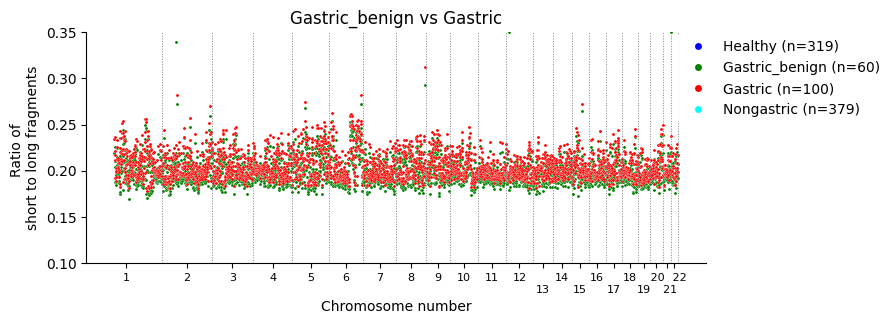

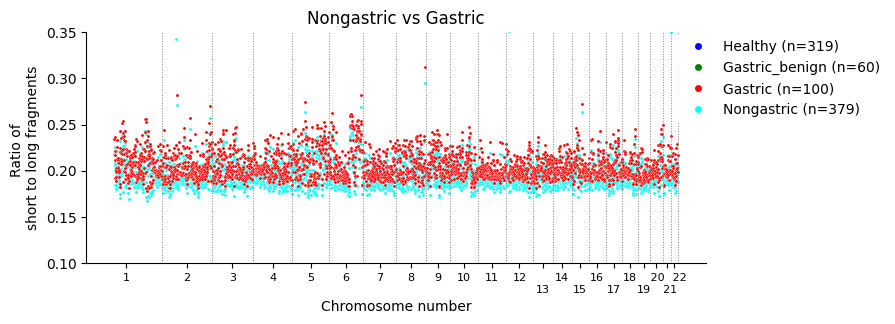

In [ ]:
G['Nongastric']='cyan'
for p in PAIR:
    col1='Mean of '+p.split(" vs ")[0]
    col2='Mean of '+p.split(" vs ")[1]
    # col_log='Log2FC_'+p 
    # col_PADJ='PADJ_'+p 
    # vectorcolorCNA=[]
    # for i in range(len(stat_GWFP_ratio)):
    #     if stat_CNA[col_PADJ].iloc[i] >= 0.05:
    #         vectorcolorCNA+=['gray']
    #     elif stat_CNA[col_log].iloc[i] > 0:
    #         vectorcolorCNA+=['red']
    #     else:
    #         vectorcolorCNA+=['blue']
    plt.figure(figsize=(8,3))
    for vline in results['Vline']:
        plt.axvline(x=vline, color='gray', label='axvline - full height',ls=':',lw=0.7)
    xlabels=['1','2','3','4','5','6','7','8','9','10','11','12','\n13','14','\n15','16','\n17','18','\n19',' 20','\n  21','   22']
    sb.scatterplot(x=GWFP['FEATURES'],y=GWFP[col1],c=G[p.split(" vs ")[0]],s=5,edgecolor='w')
    sb.scatterplot(x=GWFP['FEATURES'],y=GWFP[col2],c=G[p.split(" vs ")[1]],s=5,edgecolor='w')
    plt.xticks(ticks=results['Position'],labels=xlabels,fontsize=8)
    plt.yticks(np.arange(0.1,0.4,0.05))
    plt.ylim((0.1,0.35))
    plt.xlabel('Chromosome number')
    plt.ylabel('Ratio of \nshort to long fragments')
    plt.title(p)
    custom_lines = [Line2D([0], [0],marker='o',color='w', markerfacecolor='b', markersize=6,mec='w'),
                    Line2D([0], [0],marker='o', color='w', markerfacecolor='g', markersize=6,mec='w'),
                    Line2D([0], [0],marker='o', color='w', markerfacecolor='r', markersize=6,mec='w'),
                    Line2D([0], [0],marker='o', color='w', markerfacecolor='cyan', markersize=6,mec='w')]
    # plt.legend(custom_lines,[p.split(" vs ")[1],p.split(" vs ")[0]],loc='upper right', bbox_to_anchor=(0.5, -0.3),frameon=False)
    # plt.legend(custom_lines,[p.split(" vs ")[1],p.split(" vs ")[0]],loc='upper left', bbox_to_anchor=(1, 0.5),frameon=False)
    plt.legend(custom_lines,['Healthy (n='+str(len(healthy))+')','Gastric_benign (n='+str(len(gastric_benign))+')','Gastric (n='+str(len(gastric))+')','Nongastric (n='+str(len(Nongastric))+')'],loc='center right',bbox_to_anchor=(1.3, 0.8),frameon=True,edgecolor='w')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    # plt.savefig('.\Figure\FLEN_ratio_short_total.png', dpi=600, bbox_inches='tight')

RATIOST

In [ ]:
#Tạo position cho chromosome
GWFP=stats_fea['RATIOST']
GWFP=GWFP[~GWFP['FEATURES'].str.contains('X|Y', case=False, na=False)]
Chromosome=[]
for i in range(len(GWFP)):
    chromosome=GWFP['FEATURES'].iloc[i].split("_")[1].split(':')[0]
    chromosome=int(chromosome)
    Chromosome+=[chromosome]
results=pd.DataFrame({'Chromosome':Chromosome})
results=results['Chromosome'].value_counts().sort_index()
results=pd.DataFrame({'Count':results})
lst=[]
for i in range(len(results)):
    # lst+=[sum(results.iloc[:i,0])+round(results.iloc[i,0]/2,0)]
    lst+=[sum(results.iloc[:i+1,0])]
results['Vline']=lst

Position=[]
for i in range(1,23,1):
    if i ==1:
        posit=int(results['Vline'][i]/4)
    else:
        posit=int((results['Vline'][i]+results['Vline'][i-1])/2)
    Position+=[posit]
results['Position']=Position
# results

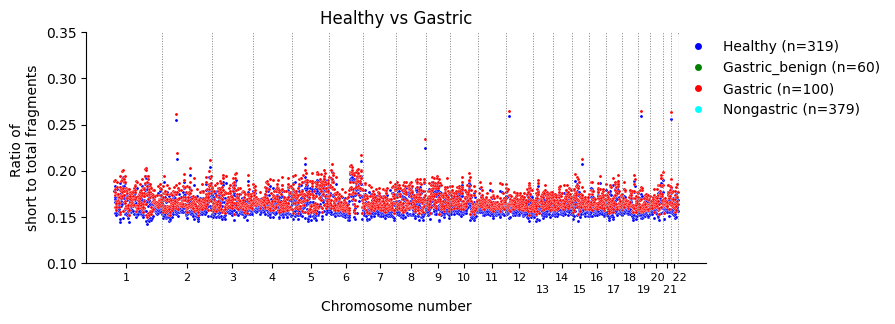

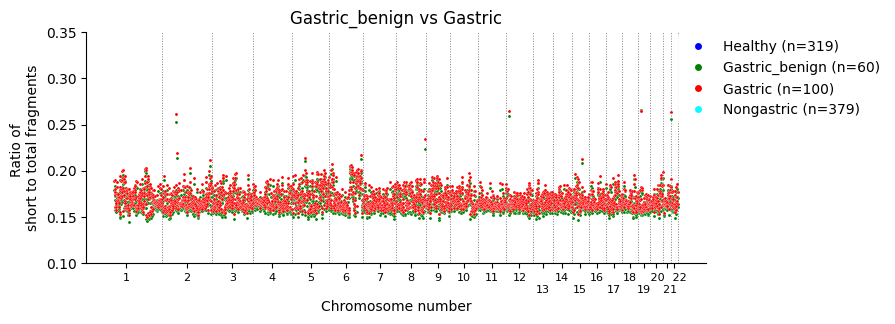

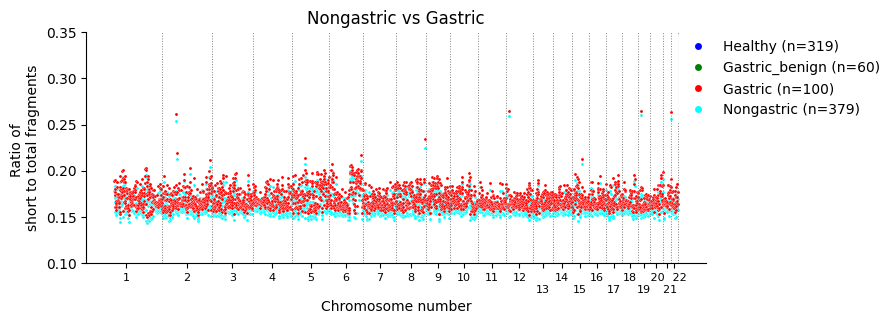

In [ ]:
G['Nongastric']='cyan'
for p in PAIR:
    col1='Mean of '+p.split(" vs ")[0]
    col2='Mean of '+p.split(" vs ")[1]
    # col_log='Log2FC_'+p 
    # col_PADJ='PADJ_'+p 
    # vectorcolorCNA=[]
    # for i in range(len(stat_GWFP_ratio)):
    #     if stat_CNA[col_PADJ].iloc[i] >= 0.05:
    #         vectorcolorCNA+=['gray']
    #     elif stat_CNA[col_log].iloc[i] > 0:
    #         vectorcolorCNA+=['red']
    #     else:
    #         vectorcolorCNA+=['blue']
    plt.figure(figsize=(8,3))
    for vline in results['Vline']:
        plt.axvline(x=vline, color='gray', label='axvline - full height',ls=':',lw=0.7)
    xlabels=['1','2','3','4','5','6','7','8','9','10','11','12','\n13','14','\n15','16','\n17','18','\n19',' 20','\n  21','   22']
    sb.scatterplot(x=GWFP['FEATURES'],y=GWFP[col1],c=G[p.split(" vs ")[0]],s=5,edgecolor='w')
    sb.scatterplot(x=GWFP['FEATURES'],y=GWFP[col2],c=G[p.split(" vs ")[1]],s=5,edgecolor='w')
    plt.xticks(ticks=results['Position'],labels=xlabels,fontsize=8)
    plt.yticks(np.arange(0.1,0.4,0.05))
    plt.ylim((0.1,0.35))
    plt.xlabel('Chromosome number')
    plt.ylabel('Ratio of \nshort to total fragments')
    plt.title(p)
    custom_lines = [Line2D([0], [0],marker='o',color='w', markerfacecolor='b', markersize=6,mec='w'),
                    Line2D([0], [0],marker='o', color='w', markerfacecolor='g', markersize=6,mec='w'),
                    Line2D([0], [0],marker='o', color='w', markerfacecolor='r', markersize=6,mec='w'),
                    Line2D([0], [0],marker='o', color='w', markerfacecolor='cyan', markersize=6,mec='w')]
    # plt.legend(custom_lines,[p.split(" vs ")[1],p.split(" vs ")[0]],loc='upper right', bbox_to_anchor=(0.5, -0.3),frameon=False)
    # plt.legend(custom_lines,[p.split(" vs ")[1],p.split(" vs ")[0]],loc='upper left', bbox_to_anchor=(1, 0.5),frameon=False)
    plt.legend(custom_lines,['Healthy (n='+str(len(healthy))+')','Gastric_benign (n='+str(len(gastric_benign))+')','Gastric (n='+str(len(gastric))+')','Nongastric (n='+str(len(Nongastric))+')'],loc='center right',bbox_to_anchor=(1.3, 0.8),frameon=True,edgecolor='w')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    # plt.savefig('.\Figure\FLEN_ratio_short_total.png', dpi=600, bbox_inches='tight')

In [ ]:
stats_fea['RATIOSL']

FEATURES  Mean of Healthy  Mean of Gastric  \
0               RATIOSL_1:1-1000000         0.217675         0.234115   
1     RATIOSL_1:100000001-101000000         0.205603         0.217509   
2       RATIOSL_1:10000001-11000000         0.207732         0.221165   
3         RATIOSL_1:1000001-2000000         0.225196         0.236552   
4     RATIOSL_1:101000001-102000000         0.199708         0.211346   
...                             ...              ...              ...   
2867    RATIOSL_Y:10000001-11000000         0.251547         0.260393   
2868    RATIOSL_Y:13000001-14000000         0.495483         0.497391   
2869    RATIOSL_Y:58000001-59000000         0.346504         0.358033   
2870    RATIOSL_Y:59000001-59373566         0.209941         0.222536   
2871     RATIOSL_Y:9000001-10000000         0.203464         0.212209   

      Median of Healthy  Median of Gastric  SD of Healthy  SD of Gastric  \
0              0.215281           0.231111       0.038445       0.050406   
1              0.201555           0.207635       0.035587       0.047517   
2              0.205726           0.218320       0.035696       0.048340   
3              0.223347           0.229240       0.035812       0.049418   
4              0.199259           0.211458       0.035338       0.045522   
...                 ...                ...            ...            ...   
2867           0.244027           0.251631       0.051101       0.062617   
2868           0.456017           0.471951       0.126239       0.136472   
2869           0.337955           0.343120       0.063903       0.080431   
2870           0.207895           0.218738       0.045755       0.065428   
2871           0.197416           0.210225       0.045903       0.055341   

      CV% of Healthy  CV% of Gastric  Entropy of Healthy  ...  \
0          17.661545       21.530610            4.172072  ...   
1          17.308672       21.845849            3.969864  ...   
2          17.183765       21.856897            4.002479  ...   
3          15.902490       20.890838            4.190566  ...   
4          17.694743       21.539214            3.990331  ...   
...              ...             ...                 ...  ...   
2867       20.314554       24.047114            4.261867  ...   
2868       25.477919       27.437625            4.461305  ...   
2869       18.442236       22.464687            4.183372  ...   
2870       21.794288       29.401069            4.195533  ...   
2871       22.560548       26.078790            4.305053  ...   

      Entropy of Nongastric  Log2FC of Nongastric vs Gastric  \
0                  4.340555                         0.103934   
1                  4.135923                         0.075947   
2                  4.164791                         0.087123   
3                  4.332365                         0.070394   
4                  4.142337                         0.077112   
...                     ...                              ...   
2867               4.445605                         0.043531   
2868               4.654601                        -0.000584   
2869               4.354731                         0.048515   
2870               4.368585                         0.074519   
2871               4.485767                         0.046788   

      Log2FC Median of Nongastric vs Gastric  P of Nongastric vs Gastric  \
0                                   0.104227                    0.004284   
1                                   0.028951                    0.059861   
2                                   0.084131                    0.021033   
3                                   0.037572                    0.105519   
4                                   0.086911                    0.044935   
...                                      ...                         ...   
2867                                0.040631                    0.443988   
2868                                0.032333                    0.944315   
286

In [ ]:
GWFP

FEATURES  Mean of Healthy  Mean of Gastric  \
0               RATIOST_1:1-1000000         0.177967         0.188401   
1     RATIOST_1:100000001-101000000         0.169850         0.177455   
2       RATIOST_1:10000001-11000000         0.171309         0.179883   
3         RATIOST_1:1000001-2000000         0.183128         0.190066   
4     RATIOST_1:101000001-102000000         0.165768         0.173347   
...                             ...              ...              ...   
2713    RATIOST_9:95000001-96000000         0.177081         0.185359   
2714    RATIOST_9:96000001-97000000         0.160644         0.167631   
2715    RATIOST_9:97000001-98000000         0.163482         0.171271   
2716    RATIOST_9:98000001-99000000         0.156595         0.164428   
2717   RATIOST_9:99000001-100000000         0.168786         0.177199   

      Median of Healthy  Median of Gastric  SD of Healthy  SD of Gastric  \
0              0.177145           0.187725       0.025263       0.031944   
1              0.167745           0.171935       0.023449       0.030722   
2              0.170624           0.179197       0.023495       0.031061   
3              0.182570           0.186489       0.023174       0.030949   
4              0.166152           0.174549       0.023677       0.030005   
...                 ...                ...            ...            ...   
2713           0.177389           0.183391       0.022503       0.031444   
2714           0.159745           0.165914       0.022063       0.030548   
2715           0.161930           0.168617       0.023448       0.031357   
2716           0.155732           0.162648       0.022317       0.029733   
2717           0.167192           0.176568       0.023570       0.030683   

      CV% of Healthy  CV% of Gastric  Entropy of Healthy  ...  \
0          14.195591       16.955370            4.240231  ...   
1          13.805901       17.312583            4.055821  ...   
2          13.715028       17.267254            4.112610  ...   
3          12.654571       16.283134            4.294609  ...   
4          14.283043       17.309101            4.045323  ...   
...              ...             ...                 ...  ...   
2713       12.707736       16.963907            4.099550  ...   
2714       13.734202       18.223526            4.021438  ...   
2715       14.342689       18.308214            4.115939  ...   
2716       14.251707       18.082730            4.052352  ...   
2717       13.964237       17.315462            4.136333  ...   

      Entropy of Nongastric  Log2FC of Nongastric vs Gastric  \
0                  4.382990                         0.081172   
1                  4.246391                         0.058725   
2                  4.270243                         0.067507   
3                  4.398919                         0.053080   
4                  4.247718                         0.060414   
...                     ...                              ...   
2713               4.276467                         0.062416   
2714               4.179347                         0.059528   
2715               4.303790                         0.066149   
2716               4.236349                         0.064246   
2717               4.323780                         0.067177   

      Log2FC Median of Nongastric vs Gastric  P of Nongastric vs Gastric  \
0                                   0.085226                    0.004284   
1                                   0.024014                    0.059861   
2                                   0.069406                    0.021033   
3                                   0.030637                    0.105519   
4                                   0.072113                    0.044935   
...                                      ...                         ...   
2713                                0.044609                    0.045986   
2714                                0.053283                    0.056574   
271

CLE

In [ ]:
#Tạo position cho chromosome
GWFP=stats_fea['CLE']
GWFP=GWFP[~GWFP['FEATURES'].str.contains('X|Y', case=False, na=False)]
Chromosome=[]
for i in range(len(GWFP)):
    chromosome=GWFP['FEATURES'].iloc[i].split("_")[1].split(':')[0]
    chromosome=int(chromosome)
    Chromosome+=[chromosome]
results=pd.DataFrame({'Chromosome':Chromosome})
results=results['Chromosome'].value_counts().sort_index()
results=pd.DataFrame({'Count':results})
lst=[]
for i in range(len(results)):
    # lst+=[sum(results.iloc[:i,0])+round(results.iloc[i,0]/2,0)]
    lst+=[sum(results.iloc[:i+1,0])]
results['Vline']=lst

Position=[]
for i in range(1,23,1):
    if i ==1:
        posit=int(results['Vline'][i]/4)
    else:
        posit=int((results['Vline'][i]+results['Vline'][i-1])/2)
    Position+=[posit]
results['Position']=Position
results

Count  Vline  Position
Chromosome                        
1             230    230        57
2             242    472       351
3             196    668       570
4             190    858       763
5             179   1037       947
6             168   1205      1121
7             157   1362      1283
8             145   1507      1434
9             125   1632      1569
10            134   1766      1699
11            133   1899      1832
12            132   2031      1965
13             97   2128      2079
14             89   2217      2172
15             83   2300      2258
16             81   2381      2340
17             80   2461      2421
18             76   2537      2499
19             58   2595      2566
20             61   2656      2625
21             38   2694      2675
22             36   2730      2712

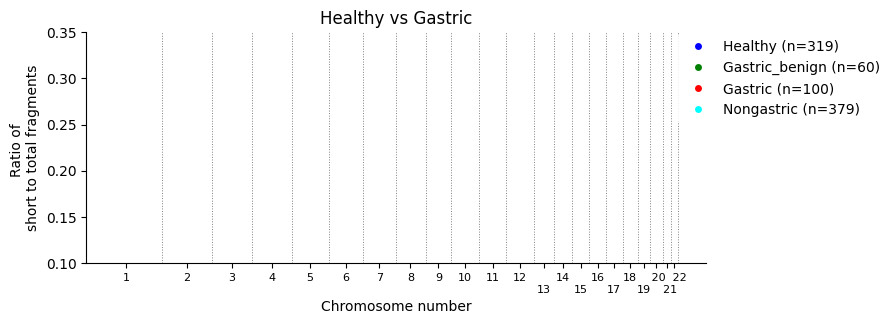

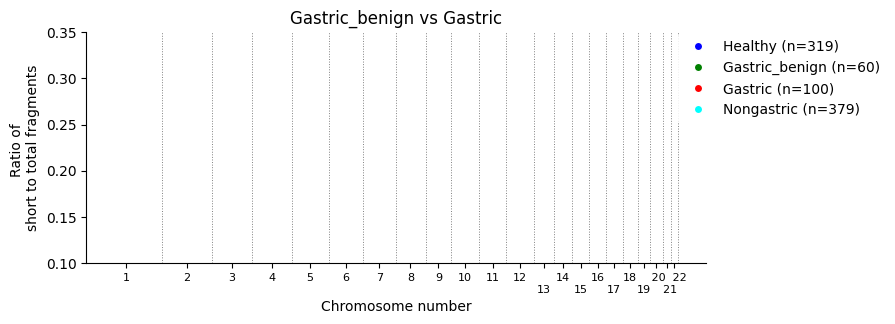

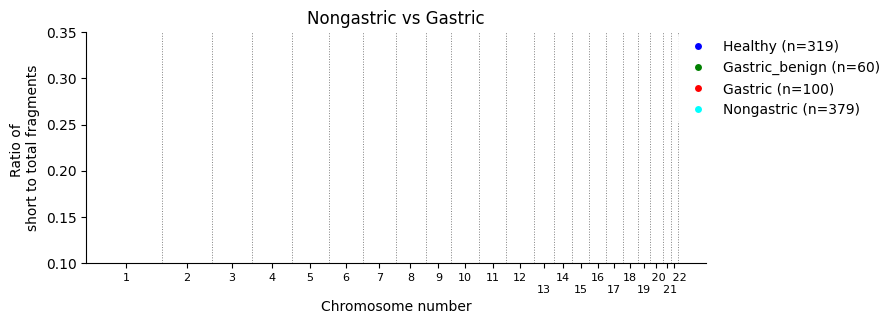

In [ ]:
G['Nongastric']='cyan'
for p in PAIR:
    col1='Mean of '+p.split(" vs ")[0]
    col2='Mean of '+p.split(" vs ")[1]
    # col_log='Log2FC_'+p 
    # col_PADJ='PADJ_'+p 
    # vectorcolorCNA=[]
    # for i in range(len(stat_GWFP_ratio)):
    #     if stat_CNA[col_PADJ].iloc[i] >= 0.05:
    #         vectorcolorCNA+=['gray']
    #     elif stat_CNA[col_log].iloc[i] > 0:
    #         vectorcolorCNA+=['red']
    #     else:
    #         vectorcolorCNA+=['blue']
    plt.figure(figsize=(8,3))
    for vline in results['Vline']:
        plt.axvline(x=vline, color='gray', label='axvline - full height',ls=':',lw=0.7)
    xlabels=['1','2','3','4','5','6','7','8','9','10','11','12','\n13','14','\n15','16','\n17','18','\n19',' 20','\n  21','   22']
    sb.scatterplot(x=GWFP['FEATURES'],y=GWFP[col1],c=G[p.split(" vs ")[0]],s=5,edgecolor='w')
    sb.scatterplot(x=GWFP['FEATURES'],y=GWFP[col2],c=G[p.split(" vs ")[1]],s=5,edgecolor='w')
    plt.xticks(ticks=results['Position'],labels=xlabels,fontsize=8)
    plt.yticks(np.arange(0.1,0.4,0.05))
    # plt.ylim((0.1,0.35))
    plt.xlabel('Chromosome number')
    plt.ylabel('Ratio of \nshort to total fragments')
    plt.title(p)
    custom_lines = [Line2D([0], [0],marker='o',color='w', markerfacecolor='b', markersize=6,mec='w'),
                    Line2D([0], [0],marker='o', color='w', markerfacecolor='g', markersize=6,mec='w'),
                    Line2D([0], [0],marker='o', color='w', markerfacecolor='r', markersize=6,mec='w'),
                    Line2D([0], [0],marker='o', color='w', markerfacecolor='cyan', markersize=6,mec='w')]
    # plt.legend(custom_lines,[p.split(" vs ")[1],p.split(" vs ")[0]],loc='upper right', bbox_to_anchor=(0.5, -0.3),frameon=False)
    # plt.legend(custom_lines,[p.split(" vs ")[1],p.split(" vs ")[0]],loc='upper left', bbox_to_anchor=(1, 0.5),frameon=False)
    plt.legend(custom_lines,['Healthy (n='+str(len(healthy))+')','Gastric_benign (n='+str(len(gastric_benign))+')','Gastric (n='+str(len(gastric))+')','Nongastric (n='+str(len(Nongastric))+')'],loc='center right',bbox_to_anchor=(1.3, 0.8),frameon=True,edgecolor='w')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    # plt.savefig('.\Figure\FLEN_ratio_short_total.png', dpi=600, bbox_inches='tight')

PCA

In [ ]:
G={
    'Healthy':'b',
    'Gastric_benign':'g',
    'Gastric':'r'
    }

In [ ]:
special_samples=['KGDAAA09','MG168','ZK0AAAI07NB','ZMG050NB']
special_samples

['KGDAAA09', 'MG168', 'ZK0AAAI07NB', 'ZMG050NB']

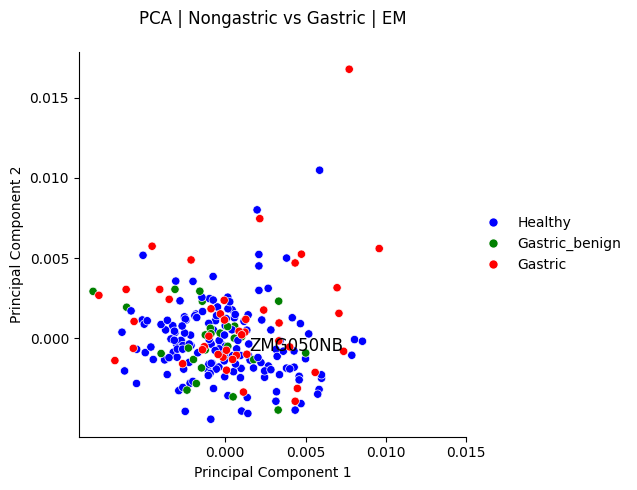

In [ ]:
f='EM'
# for f in features:
PCAsigfea(
      DATA,
      SAMPLES,
      stats_fea,
      dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
      p='Nongastric vs Gastric',
      f=f,
      sig=False,alpha=0.05,
      show_ID=True,IDs=special_samples,
      plot_pct_explain=False,top_pc=2,
      yticks=[0,0.02,0.005],xticks=[0,0.02,0.005],
      save=False,figname='PCA.png'
            )

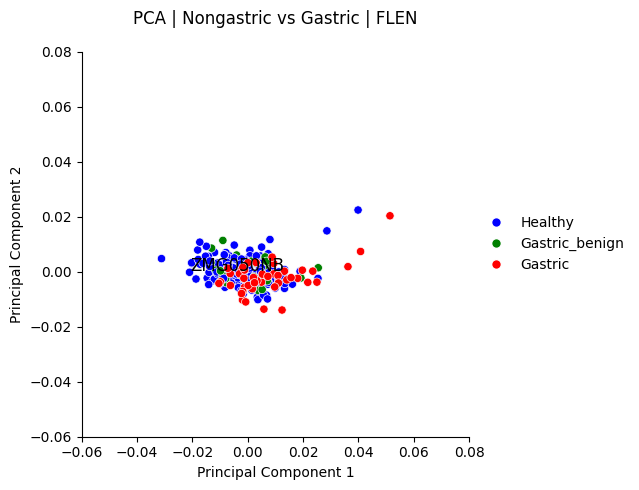

In [ ]:
f='FLEN'
# for f in features:
PCAsigfea(
      DATA,
      SAMPLES,
      stats_fea,
      dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
      p='Nongastric vs Gastric',
      f=f,
      sig=False,alpha=0.05,
      show_ID=True,IDs=special_samples,
      plot_pct_explain=False,top_pc=2,
      yticks=[-0.06,0.08,0.02],xticks=[-0.06,0.08,0.02],
      save=False,figname='PCA.png'
            )

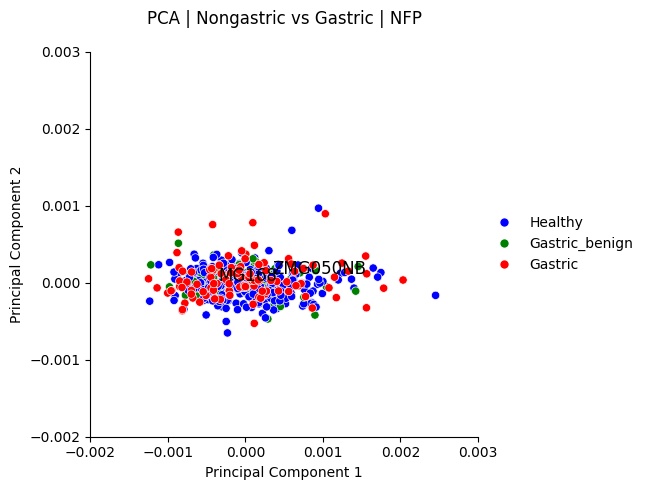

In [ ]:
f='NFP'
# for f in features:
PCAsigfea(
      DATA,
      SAMPLES,
      stats_fea,
      dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
      p='Nongastric vs Gastric',
      f=f,
      sig=False,alpha=0.05,
      show_ID=True,IDs=special_samples,
      plot_pct_explain=False,top_pc=2,
      yticks=[-0.002,0.004,0.001],xticks=[-0.002,0.004,0.001],
      save=False,figname='PCA.png'
            )

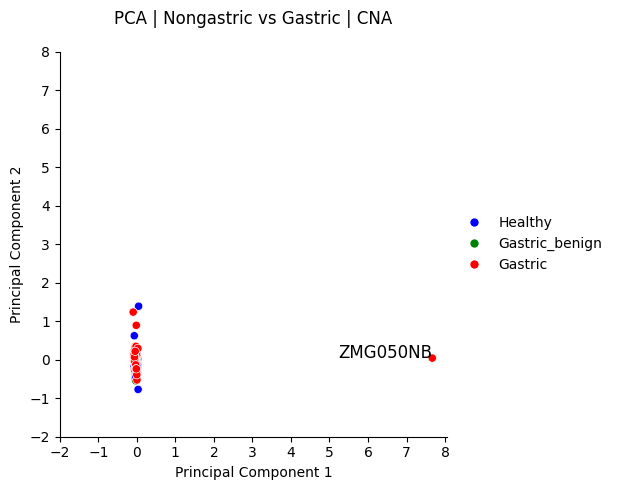

In [ ]:
f='CNA'
# for f in features:
PCAsigfea(
      DATA,
      SAMPLES,
      stats_fea,
      dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
      p='Nongastric vs Gastric',
      f=f,
      sig=False,alpha=0.05,
      show_ID=True,IDs=special_samples,
      plot_pct_explain=False,top_pc=2,
      yticks=[-2,9,1],xticks=[-2,9,1],
      save=False,figname='PCA.png'
            )

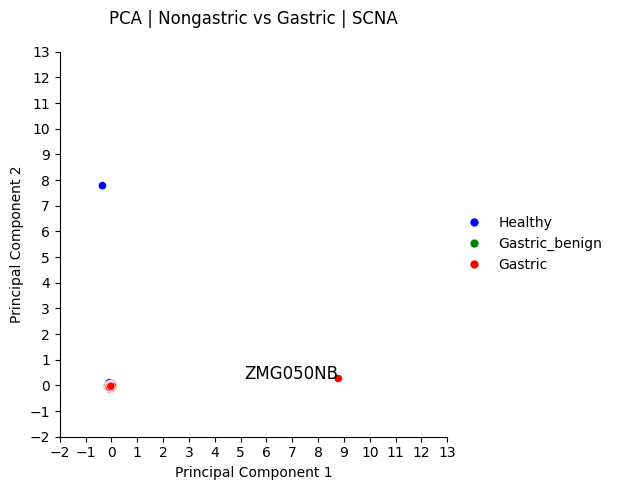

In [ ]:
f='SCNA'
# for f in features:
PCAsigfea(
      DATA,
      SAMPLES,
      stats_fea,
      dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
      p='Nongastric vs Gastric',
      f=f,
      sig=False,alpha=0.05,
      show_ID=True,IDs=special_samples,
      plot_pct_explain=False,top_pc=2,
      yticks=[-2,14,1],xticks=[-2,14,1],
      save=False,figname='PCA.png'
            )

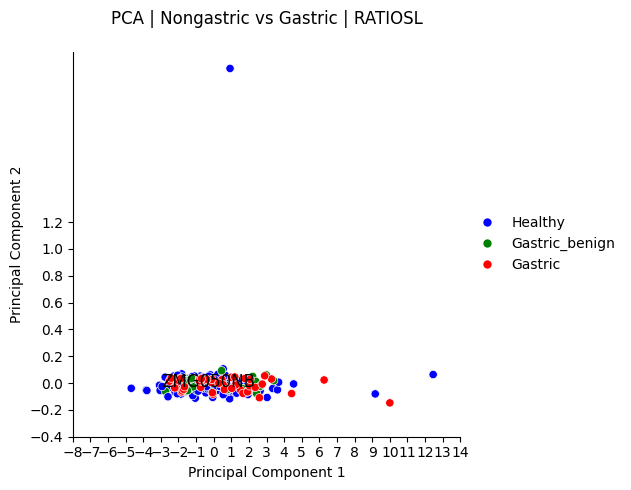

In [ ]:
f='RATIOSL'
# for f in features:
PCAsigfea(
      DATA,
      SAMPLES,
      stats_fea,
      dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
      p='Nongastric vs Gastric',
      f=f,
      sig=False,alpha=0.05,
      show_ID=True,IDs=special_samples,
      plot_pct_explain=False,top_pc=2,
      yticks=[-0.4,1.4,0.2],xticks=[-8,15,1],
      save=False,figname='PCA.png'
            )

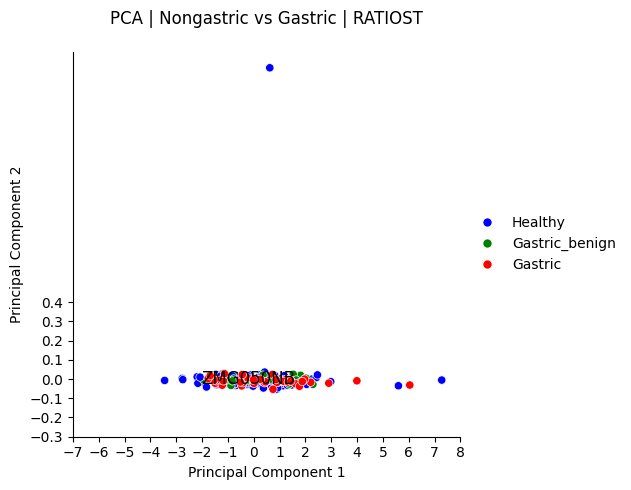

In [ ]:
f='RATIOST'
# for f in features:
PCAsigfea(
      DATA,
      SAMPLES,
      stats_fea,
      dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
      p='Nongastric vs Gastric',
      f=f,
      sig=False,alpha=0.05,
      show_ID=True,IDs=special_samples,
      plot_pct_explain=False,top_pc=2,
      yticks=[-0.3,0.5,0.1],xticks=[-7,9,1],
      save=False,figname='PCA.png'
            )

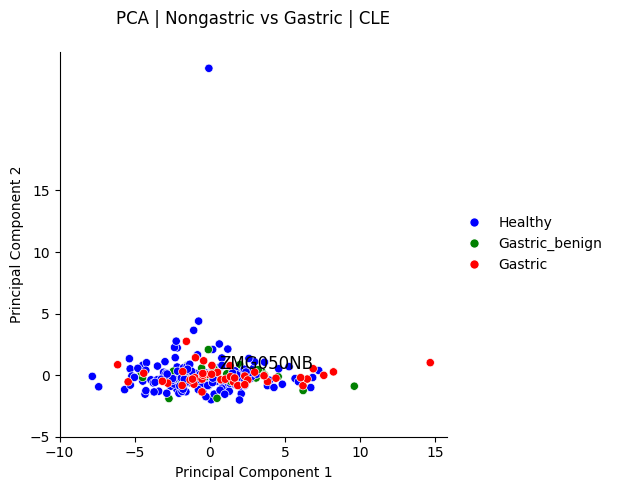

In [ ]:
f='CLE'
# for f in features:
PCAsigfea(
      DATA,
      SAMPLES,
      stats_fea,
      dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
      p='Nongastric vs Gastric',
      f=f,
      sig=False,alpha=0.05,
      show_ID=True,IDs=special_samples,
      plot_pct_explain=False,top_pc=2,
      yticks=[-5,20,5],xticks=[-10,20,5],
      save=False,figname='PCA.png'
            )

PCA filter

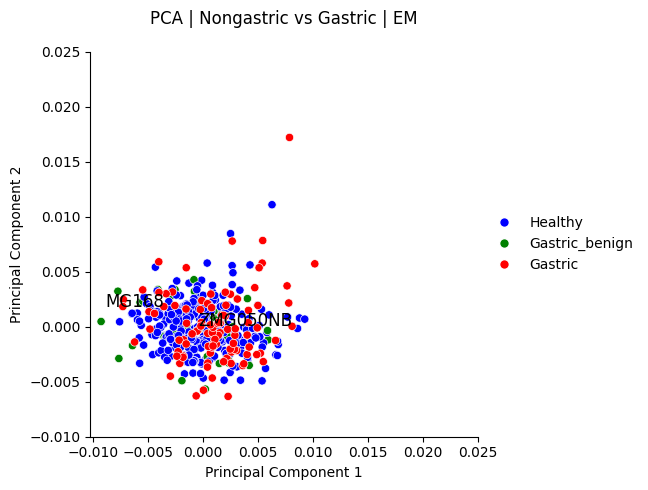

In [ ]:
f='EM'
healthy1=healthy[~healthy.iloc[:, 0].str.contains(special_sample, na=False)]
Nongastric1=pd.concat([healthy1,gastric_benign],axis=0)
PCAsigfea(
        DATA,
        SAMPLES={'Healthy':healthy1,'Gastric':gastric,'Gastric_benign':gastric_benign,'Nongastric':Nongastric1},
        stats_fea=stats_fea,
        dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
        p='Nongastric vs Gastric',
        f=f,
        sig=False,alpha=0.05,
        show_ID=True,IDs=special_samples,
        plot_pct_explain=False,top_pc=2,
        yticks=[-0.01,0.025,0.005],xticks=[-0.01,0.025,0.005],
        save=False,figname='PCA.png'
              )

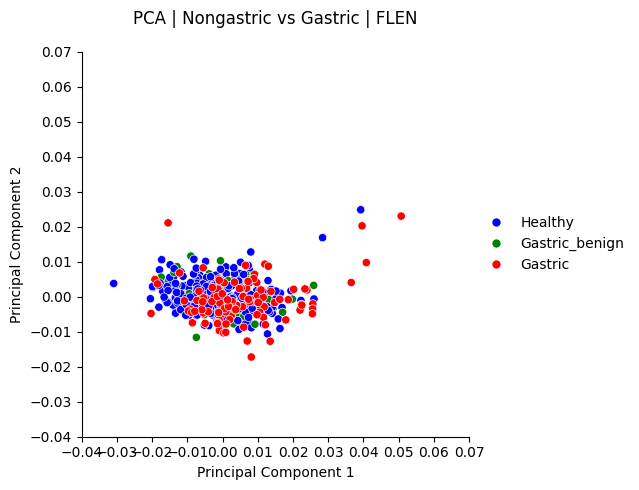

In [ ]:
f='FLEN'
healthy1=healthy[~healthy.iloc[:, 0].str.contains(special_sample, na=False)]
Nongastric1=pd.concat([healthy1,gastric_benign],axis=0)
PCAsigfea(
        DATA,
        SAMPLES={'Healthy':healthy1,'Gastric':gastric,'Gastric_benign':gastric_benign,'Nongastric':Nongastric1},
        stats_fea=stats_fea,
        dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
        p='Nongastric vs Gastric',
        f=f,
        sig=False,alpha=0.05,
        show_ID=True,IDs=[special_sample],
        plot_pct_explain=False,top_pc=2,
        yticks=[-0.04,0.07,0.01],xticks=[-0.04,0.07,0.01],
        save=False,figname='PCA.png'
              )

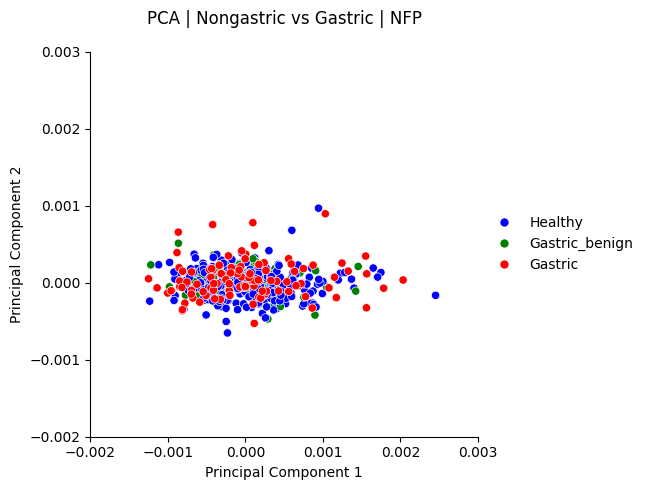

In [ ]:
f='NFP'
# for f in features:
PCAsigfea(
      DATA,
      SAMPLES={'Healthy':healthy1,'Gastric':gastric,'Gastric_benign':gastric_benign,'Nongastric':Nongastric1},
      stats_fea=stats_fea,
      dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
      p='Nongastric vs Gastric',
      f=f,
      sig=False,alpha=0.05,
      show_ID=True,IDs=[special_sample],
      plot_pct_explain=False,top_pc=2,
      yticks=[-0.002,0.004,0.001],xticks=[-0.002,0.004,0.001],
      save=False,figname='PCA.png'
            )

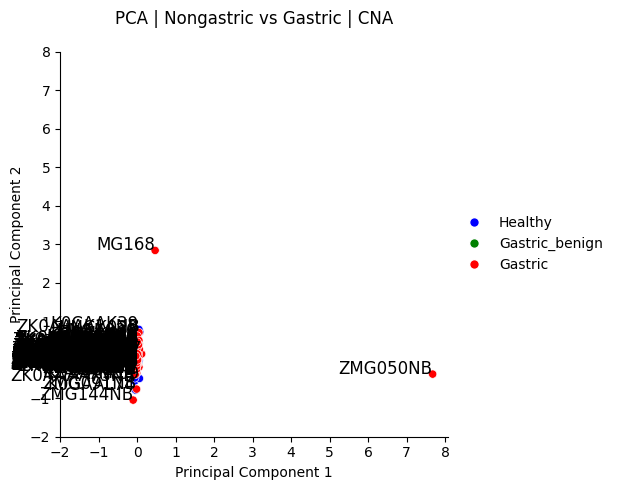

In [ ]:
f='CNA'
# for f in features:
PCAsigfea(
      DATA,
      SAMPLES={'Healthy':healthy1,'Gastric':gastric,'Gastric_benign':gastric_benign,'Nongastric':Nongastric1},
      stats_fea=stats_fea,
      dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
      p='Nongastric vs Gastric',
      f=f,
      sig=False,alpha=0.05,
      show_ID=True,IDs=list(set(sample_list_all['SampleID'])-set(special_sample)),
      plot_pct_explain=False,top_pc=2,
      yticks=[-2,9,1],xticks=[-2,9,1],
      save=False,figname='PCA.png'
            )

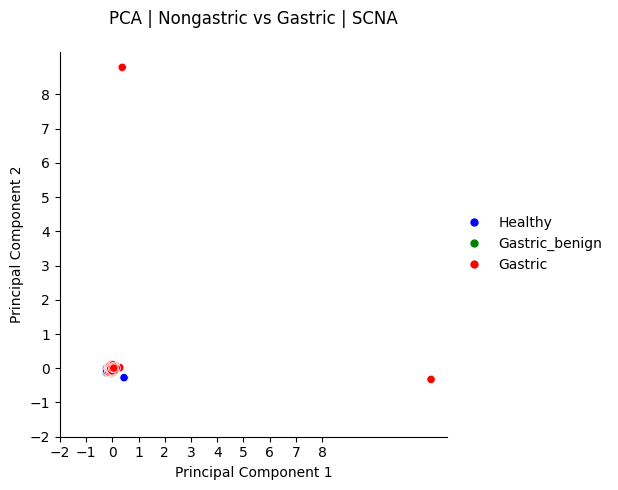

In [ ]:
f='SCNA'
# for f in features:
PCAsigfea(
      DATA,
      SAMPLES={'Healthy':healthy1,'Gastric':gastric,'Gastric_benign':gastric_benign,'Nongastric':Nongastric1},
      stats_fea=stats_fea,
      dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
      p='Nongastric vs Gastric',
      f=f,
      sig=False,alpha=0.05,
      show_ID=True,IDs=[special_sample],
      plot_pct_explain=False,top_pc=2,
      yticks=[-2,9,1],xticks=[-2,9,1],
      save=False,figname='PCA.png'
            )

t-SNE

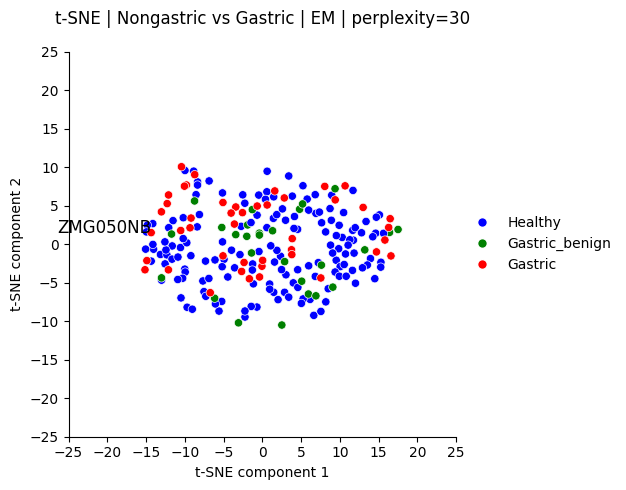

In [ ]:
f='EM'
TSNEfea(DATA, SAMPLES,stats_fea,
        dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
        f=f,
    p='Nongastric vs Gastric',
    sig=False,alpha=0.05,
    show_ID=True,IDs=special_samples,
    yticks=[-25,30,5],
    xticks=[-25,30,5],
    perplexity=30,
    save=False,
    figname='TSNE.png')

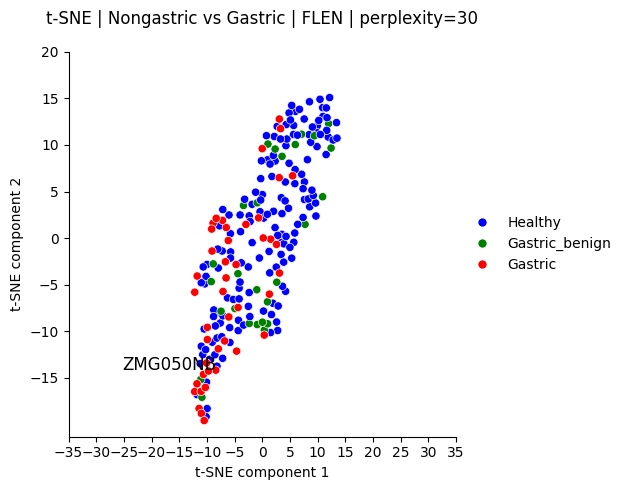

In [ ]:
f='FLEN'
TSNEfea(DATA, SAMPLES,stats_fea,
        dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
        f=f,
    p='Nongastric vs Gastric',
    sig=False,alpha=0.05,
    show_ID=True,IDs=special_samples,
    yticks=[-15,25,5],
    xticks=[-35,40,5],
    perplexity=30,
    save=False,
    figname='TSNE.png')

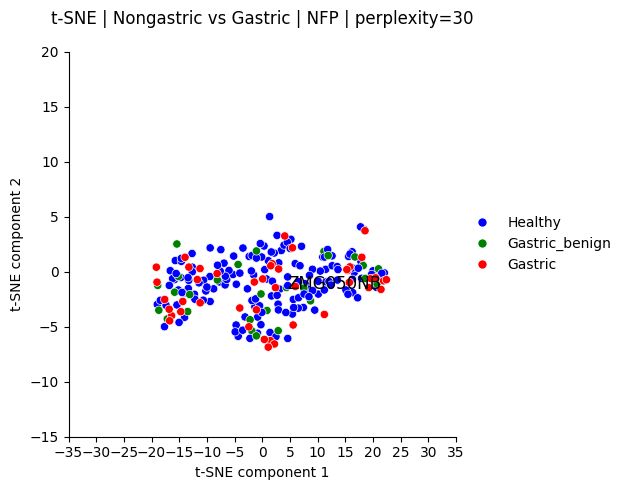

In [ ]:
f='NFP'
TSNEfea(DATA, SAMPLES,stats_fea,
        dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
        f=f,
    p='Nongastric vs Gastric',
    sig=False,alpha=0.05,
    show_ID=True,IDs=special_samples,
    yticks=[-15,25,5],
    xticks=[-35,40,5],
    perplexity=30,
    save=False,
    figname='TSNE.png')

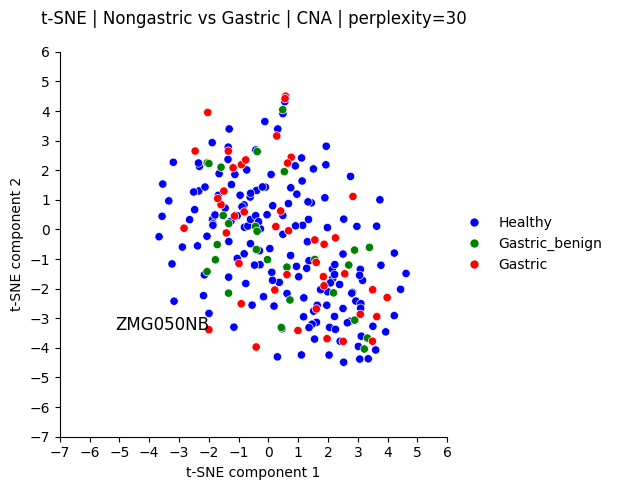

In [ ]:
f='CNA'
TSNEfea(DATA, SAMPLES,stats_fea,
        dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
        f=f,
    p='Nongastric vs Gastric',
    sig=False,alpha=0.05,
    show_ID=True,IDs=special_samples,
    yticks=[-7,7,1],
    xticks=[-7,7,1],
    perplexity=30,
    save=False,
    figname='TSNE.png')

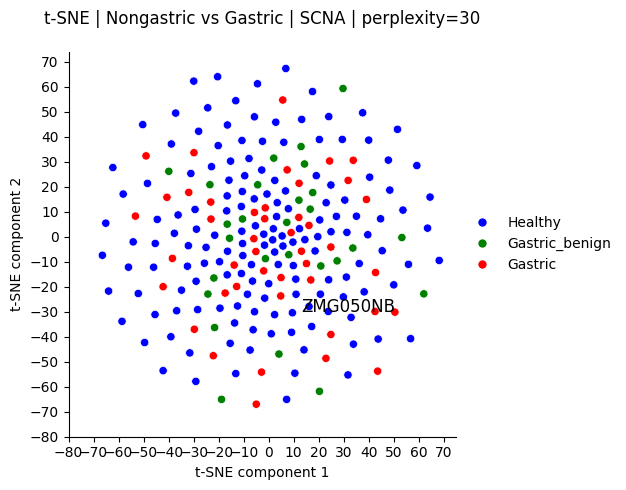

In [ ]:
f='SCNA'
TSNEfea(DATA, SAMPLES,stats_fea,
        dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
        f=f,
    p='Nongastric vs Gastric',
    sig=False,alpha=0.05,
    show_ID=True,IDs=special_samples,
    yticks=[-80,80,10],
    xticks=[-80,80,10],
    perplexity=30,
    save=False,
    figname='TSNE.png')

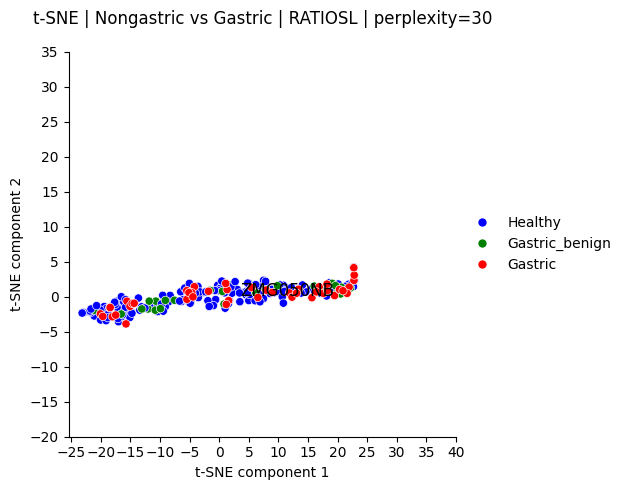

In [ ]:
f='RATIOSL'
TSNEfea(DATA, SAMPLES,stats_fea,
        dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
        f=f,
    p='Nongastric vs Gastric',
    sig=False,alpha=0.05,
    show_ID=True,IDs=special_samples,
    yticks=[-20,40,5],
    xticks=[-25,45,5],
    perplexity=30,
    save=False,
    figname='TSNE.png')

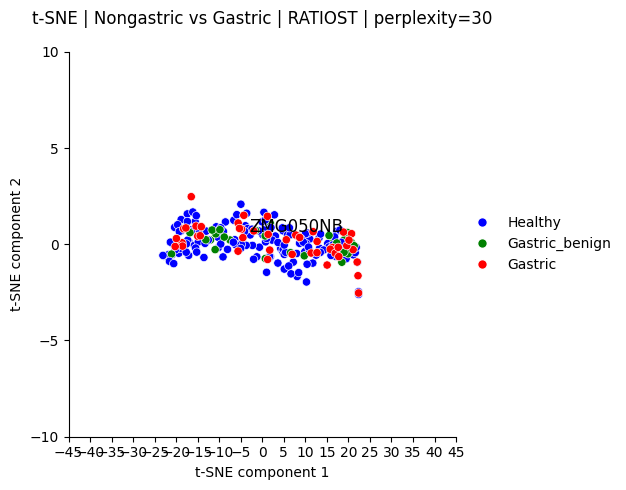

In [ ]:
f='RATIOST'
TSNEfea(DATA, SAMPLES,stats_fea,
        dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
        f=f,
    p='Nongastric vs Gastric',
    sig=False,alpha=0.05,
    show_ID=True,IDs=special_samples,
    yticks=[-10,15,5],
    xticks=[-45,50,5],
    perplexity=30,
    save=False,
    figname='TSNE.png')

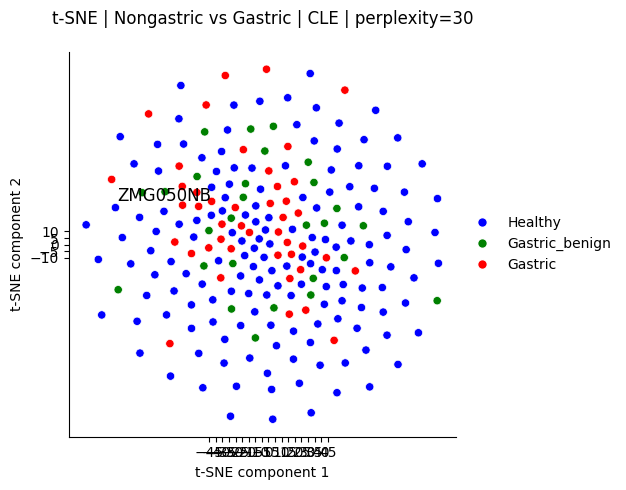

In [ ]:
f='CLE'
TSNEfea(DATA, SAMPLES,stats_fea,
        dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
        f=f,
    p='Nongastric vs Gastric',
    sig=False,alpha=0.05,
    show_ID=True,IDs=special_samples,
    yticks=[-10,15,5],
    xticks=[-45,50,5],
    perplexity=30,
    save=False,
    figname='TSNE.png')

UMAP

C:\Users\VODACHO\AppData\Roaming\Python\Python38\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


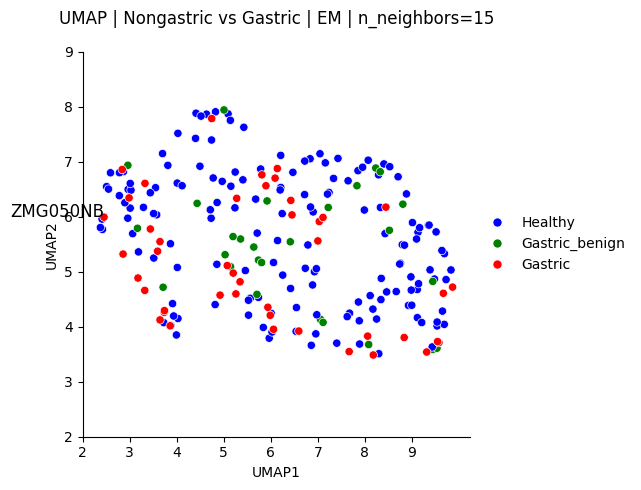

In [ ]:
f='EM'
UMAPfea(
        DATA, SAMPLES,stats_fea,
        dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
        f=f,p='Nongastric vs Gastric',
        sig=False,alpha=0.05,show_ID=True,IDs=special_samples,
        yticks=[2,10,1],
        xticks=[2,10,1],
        n_neighbors=15,n_components=2,
        save=False,figname='UMAP.png'
            )

C:\Users\VODACHO\AppData\Roaming\Python\Python38\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


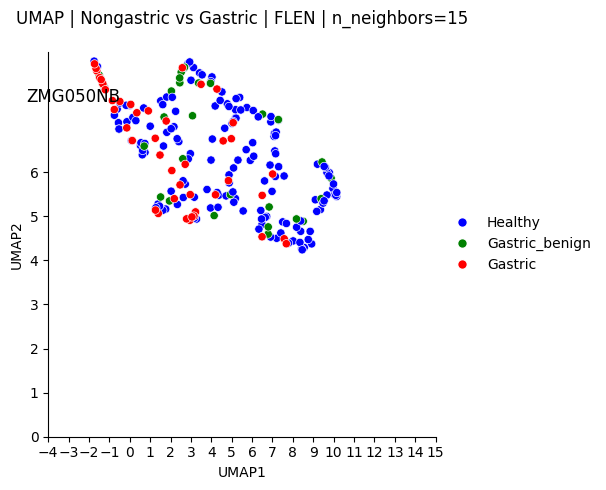

In [ ]:
f='FLEN'
UMAPfea(
        DATA, SAMPLES,stats_fea,
        dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
        f=f,p='Nongastric vs Gastric',
        sig=False,alpha=0.05,show_ID=True,IDs=special_samples,
        yticks=[0,7,1],
        xticks=[-4,16,1],
        n_neighbors=15,n_components=2,
        save=False,figname='UMAP.png'
            )

C:\Users\VODACHO\AppData\Roaming\Python\Python38\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


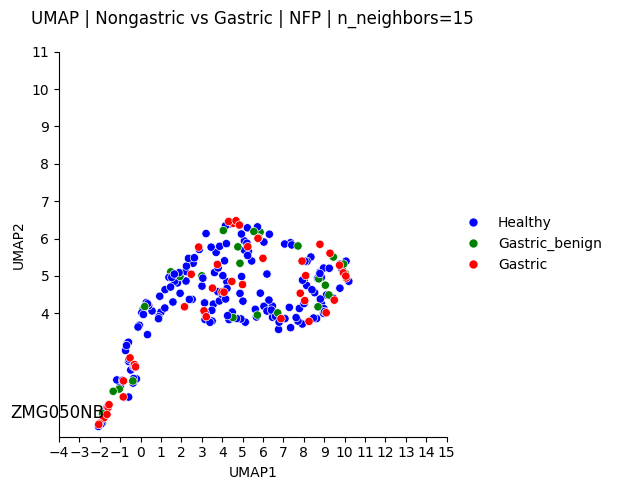

In [ ]:
f='NFP'
UMAPfea(
        DATA, SAMPLES,stats_fea,
        dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
        f=f,p='Nongastric vs Gastric',
        sig=False,alpha=0.05,show_ID=True,IDs=special_samples,
        yticks=[4,12,1],
        xticks=[-4,16,1],
        n_neighbors=15,n_components=2,
        save=False,figname='UMAP.png'
            )

C:\Users\VODACHO\AppData\Roaming\Python\Python38\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


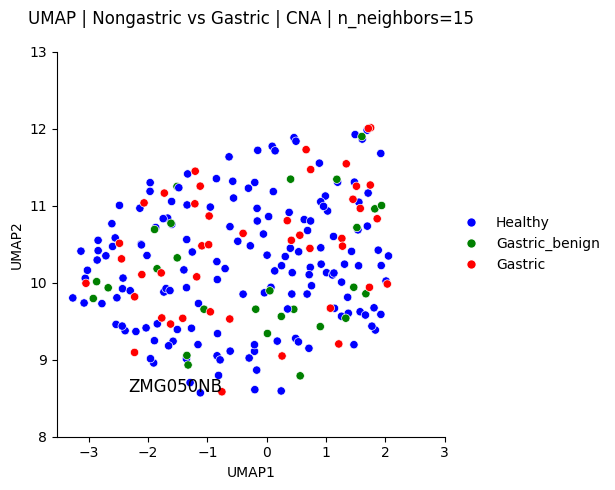

In [ ]:
f='CNA'
UMAPfea(
        DATA, SAMPLES,stats_fea,
        dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
        f=f,p='Nongastric vs Gastric',
        sig=False,alpha=0.05,show_ID=True,IDs=special_samples,
        yticks=[8,14,1],
        xticks=[-3,4,1],
        n_neighbors=15,n_components=2,
        save=False,figname='UMAP.png'
            )

C:\Users\VODACHO\AppData\Roaming\Python\Python38\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


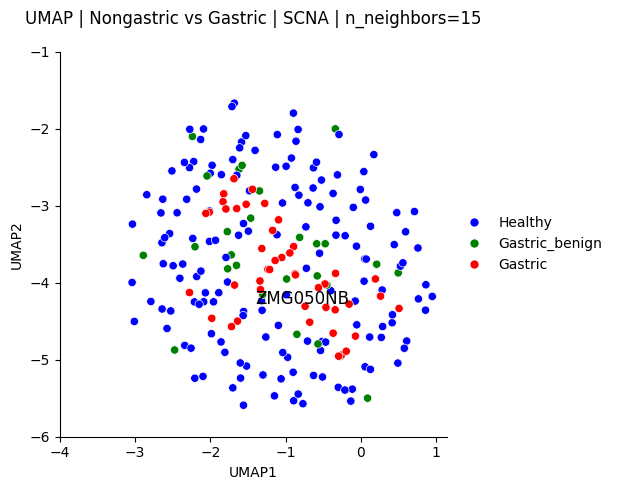

In [ ]:
f='SCNA'
UMAPfea(
        DATA, SAMPLES,stats_fea,
        dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
        f=f,p='Nongastric vs Gastric',
        sig=False,alpha=0.05,show_ID=True,IDs=special_samples,
        yticks=[-6,0,1],
        xticks=[-4,2,1],
        n_neighbors=15,n_components=2,
        save=False,figname='UMAP.png'
            )

C:\Users\VODACHO\AppData\Roaming\Python\Python38\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


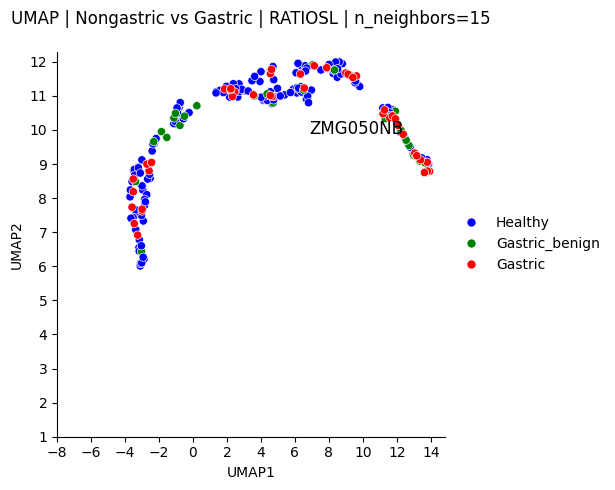

In [ ]:
f='RATIOSL'
UMAPfea(
        DATA, SAMPLES,stats_fea,
        dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
        f=f,p='Nongastric vs Gastric',
        sig=False,alpha=0.05,show_ID=True,IDs=special_samples,
        yticks=[1,13,1],
        xticks=[-8,16,2],
        n_neighbors=15,n_components=2,
        save=False,figname='UMAP.png'
            )

C:\Users\VODACHO\AppData\Roaming\Python\Python38\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


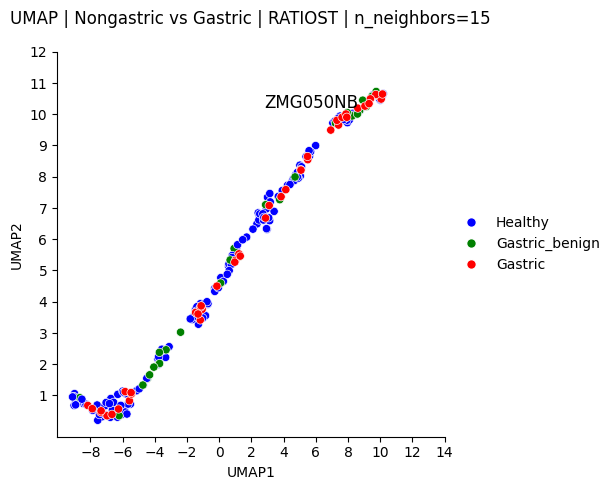

In [ ]:
f='RATIOST'
UMAPfea(
        DATA, SAMPLES,stats_fea,
        dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
        f=f,p='Nongastric vs Gastric',
        sig=False,alpha=0.05,show_ID=True,IDs=special_samples,
        yticks=[1,13,1],
        xticks=[-8,16,2],
        n_neighbors=15,n_components=2,
        save=False,figname='UMAP.png'
            )

C:\Users\VODACHO\AppData\Roaming\Python\Python38\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


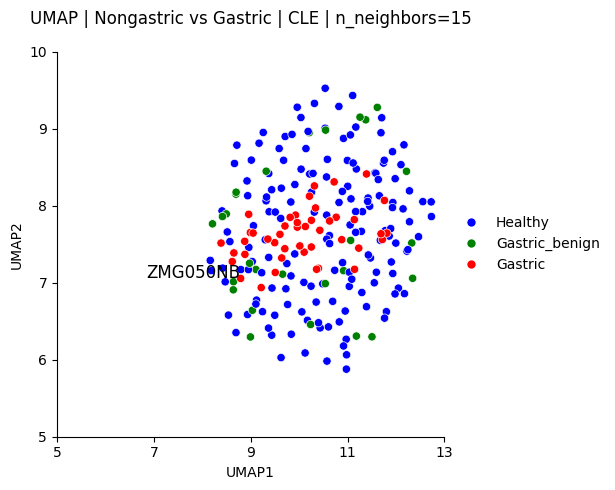

In [ ]:
f='CLE'
UMAPfea(
        DATA, SAMPLES,stats_fea,
        dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
        f=f,p='Nongastric vs Gastric',
        sig=False,alpha=0.05,show_ID=True,IDs=special_samples,
        yticks=[5,11,1],
        xticks=[5,14,2],
        n_neighbors=15,n_components=2,
        save=False,figname='UMAP.png'
            )

LDA

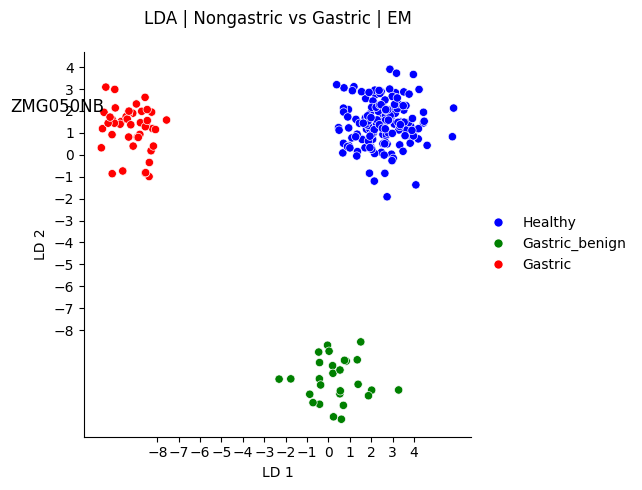

In [ ]:
f='EM'
LDAsigfea(DATA,SAMPLES,stats_fea=stats_fea,
          dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
          p='Nongastric vs Gastric',f=f,
              sig=False,alpha=0.05,show_ID=True,IDs=special_samples,
              yticks=[-8,5,1],xticks=[-8,5,1],
              save=False,figname='LDA.png'
              )

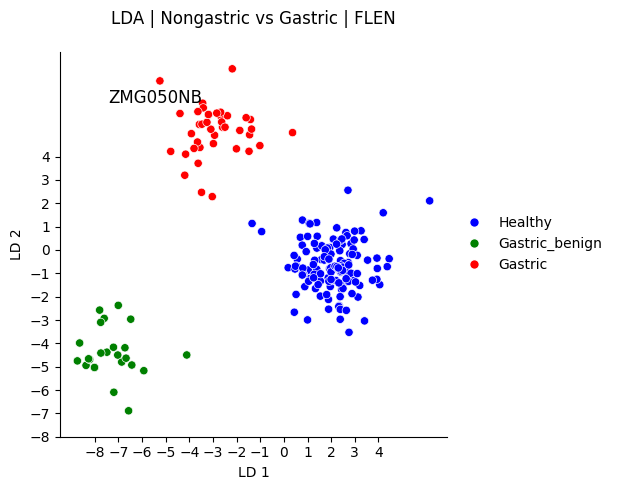

In [ ]:
f='FLEN'
LDAsigfea(DATA,SAMPLES,stats_fea=stats_fea,
          dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
          p='Nongastric vs Gastric',f=f,
              sig=False,alpha=0.05,show_ID=True,IDs=special_samples,
              yticks=[-8,5,1],xticks=[-8,5,1],
              save=False,figname='LDA.png'
              )

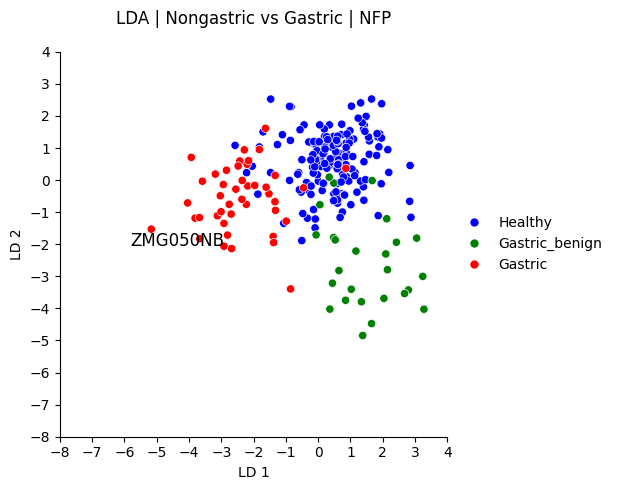

In [ ]:
f='NFP'
LDAsigfea(DATA,SAMPLES,stats_fea=stats_fea,
          dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
          p='Nongastric vs Gastric',f=f,
              sig=False,alpha=0.05,show_ID=True,IDs=special_samples,
              yticks=[-8,5,1],xticks=[-8,5,1],
              save=False,figname='LDA.png'
              )

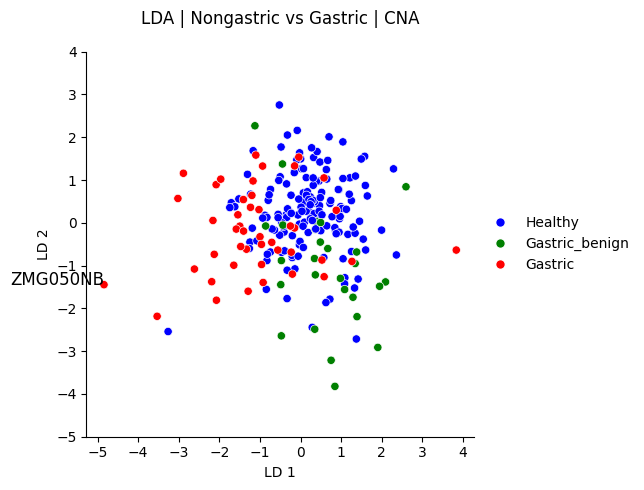

In [ ]:
f='CNA'
LDAsigfea(DATA,SAMPLES,stats_fea=stats_fea,
          dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
          p='Nongastric vs Gastric',f=f,
              sig=False,alpha=0.05,show_ID=True,IDs=special_samples,
              yticks=[-5,5,1],xticks=[-5,5,1],
              save=False,figname='LDA.png'
              )

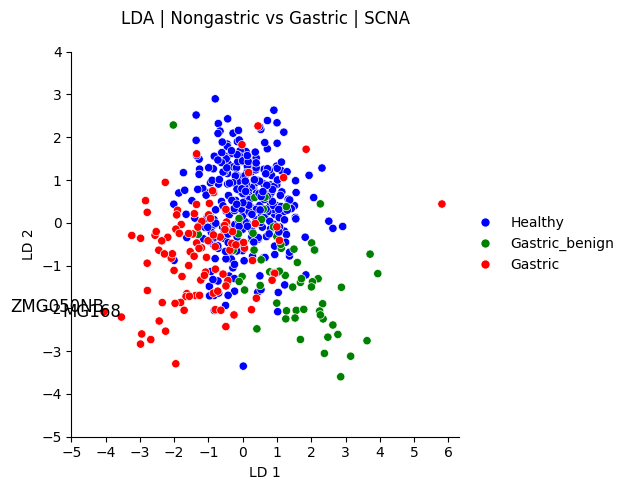

In [ ]:
f='SCNA'
LDAsigfea(DATA,SAMPLES,stats_fea=stats_fea,
          dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
          p='Nongastric vs Gastric',f=f,
              sig=False,alpha=0.05,show_ID=True,IDs=special_samples,
              yticks=[-5,5,1],xticks=[-5,7,1],
              save=False,figname='LDA.png'
              )

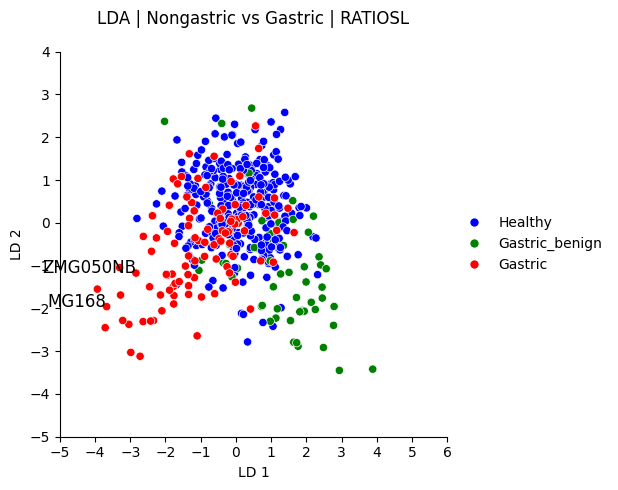

In [ ]:
f='RATIOSL'
LDAsigfea(DATA,SAMPLES,stats_fea=stats_fea,
          dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
          p='Nongastric vs Gastric',f=f,
              sig=False,alpha=0.05,show_ID=True,IDs=special_samples,
              yticks=[-5,5,1],xticks=[-5,7,1],
              save=False,figname='LDA.png'
              )

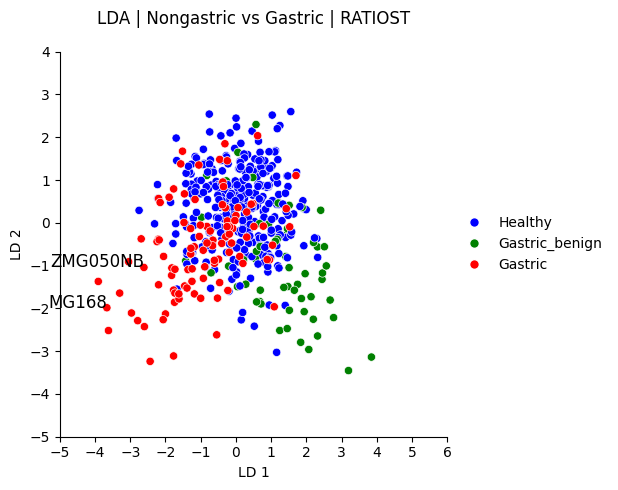

In [ ]:
f='RATIOST'
LDAsigfea(DATA,SAMPLES,stats_fea=stats_fea,
          dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
          p='Nongastric vs Gastric',f=f,
              sig=False,alpha=0.05,show_ID=True,IDs=special_samples,
              yticks=[-5,5,1],xticks=[-5,7,1],
              save=False)

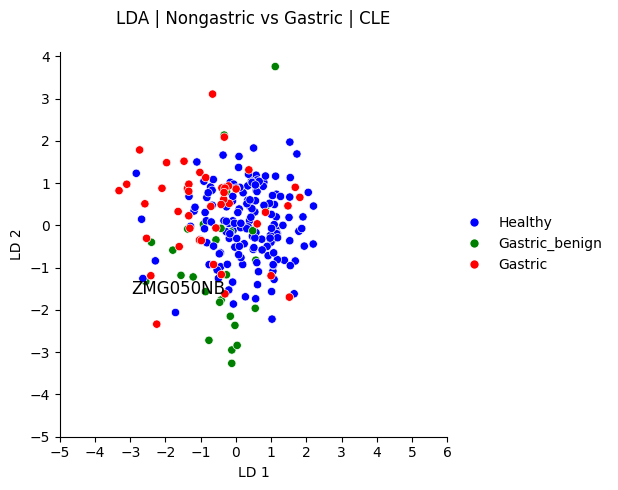

In [ ]:
f='CLE'
LDAsigfea(DATA,SAMPLES,stats_fea=stats_fea,
          dict_cols={'Healthy': 'b', 'Gastric_benign': 'g', 'Gastric': 'r'},
          p='Nongastric vs Gastric',f=f,
              sig=False,alpha=0.05,show_ID=True,IDs=special_samples,
              yticks=[-5,5,1],xticks=[-5,7,1],
              save=False)